Summary: Occurences of differences were observed for different ranges of feature LSTAT, which is mainly responsible for the differences.
- For values between 4 and 6.3, A may predict 1 while B predicts 2,
- for values between 5.9 and 9.1, A may predict 2 while B predicts 1,
- for values between 10.2 and 19.2, A may predict 0 while B predicts 1.

Aggregate ranges, where differences where found:
- $(0,1)$: $10.2 ≤ LSTAT < 19.2, ZN=0, 8.1 < INDUS < 21.9, CRIM < 3.9, 276 ≤ TAX, RM < 6.4, 4 ≤ RAD, DIS < 4.5, 1 ≤ AGE$, the mainly responsible feature being LSTAT.
- $(1,2)$: $4 < LSTAT < 6.3, ZN=0, INDUS=7.4, CRIM<9.3, RAD=6.3, TAX=287, DIS=5.4, RM=6.3, AGE=0$, the mainly responsible feature being LSTAT.
- $(2,1)$: $5.9 < LSTAT < 9.1, ZN ≤ 33, INDUS < 19.6, CRIM < 9.3, 222 ≤ TAX, RM < 6.8, 1.6 < DIS < 3.4, 1 ≤ AGE$, the mainly responsible feature being LSTAT.

Full explanations per cluster:
- $(0,1)$
    - Cluster: $8.9 < LSTAT, ZN ≤ 75, 2.1 < INDUS$ (132 instances)
        - Differences: $11.1 ≤ LSTAT < 18.8, ZN=0, 8.1 < INDUS < 21.9, CRIM < 3.9, 276 ≤ TAX, RM < 6.4, 4 ≤ RAD, DIS < 4.5, 1 ≤ AGE$ (13 instances)
        - $LSTAT=19.2 \rightarrow (0,0)$
        - $LSTAT=10.2 \rightarrow (1,1)$
- $(1,2)$
    - Cluster: $LSTAT ≤ 13, INDUS < 19.6, CRIM < 9.3$ (135 instances)
        - Differences: $LSTAT=6.2, ZN=0, INDUS=7.4, RAD=6.3, TAX=287, DIS=5.4, RM=6.3, AGE=0$ (1 instance)
        - $LSTAT=6.3 \rightarrow (1,1)$
        - $LSTAT=4 \rightarrow (2,2)$
- $(2,1)$
    - Cluster: $LSTAT ≤ 13, INDUS < 19.6, CRIM < 9.3, 193 ≤ TAX$ (135 instances)
        - Differences: $6.4 < LSTAT < 9.0, ZN ≤ 33, 222 ≤ TAX, RM < 6.8, 1.6 < DIS < 3.4, 1 ≤ AGE$ (3 instances)
        - $LSTAT=9.1 \rightarrow (1,1)$
        - $LSTAT=5.9 \rightarrow (2,2)$

In [5]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
import cloudpickle
import xgboost
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from helper_models import LogProbabilityMixin
from comparers import ModelComparer
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order,\
                       plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                       plot_feature_effects, plot_forces, merge_explanations, plot_decision,\
                       perform_hierarchical_clustering, plot_dendrogram, extract_clustering,\
                       get_class_occurences_in_clusters, plot_feature_influence_comparison,\
                       plot_class_importances, plot_feature_effects_comparison, ensure_shap_values_are_3d
from clustering import make_clustering
from tasks.boston_housing import make_task3 as make_task
import matplotlib.pyplot as plt
from IPython.display import display
import shap
shap.initjs()

In [4]:
try:
    with open('shap.expl', 'rb') as f:
        explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer = pickle.load(f)
    is_pred_diff = comparer.predict_bin_diff(explanations.data)
    mclass_diff = comparer.predict_mclass_diff(explanations.data)
    global_feature_order, _ = calc_feature_order(explanations.mclass_diff.log_odds)
except FileNotFoundError:
    pass

# Setup Task

In [6]:
clf_a, clf_b, X, y, feature_names = make_task()
comparer = ModelComparer(clf_a, clf_b, feature_names)

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


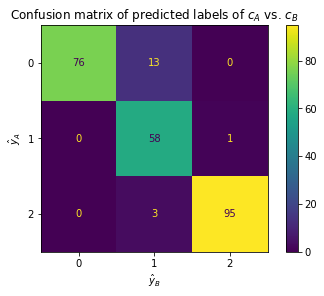

In [5]:
comparer.plot_confusion_matrix(X)

In [ ]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['log_odds'])
with open('shap.expl', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer),
                f, pickle.HIGHEST_PROTOCOL)

As we can see, no instances had infinite log-space predictions and no instances had infinite SHAP values:

In [9]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((246, 11), (0,), (0,))

In [ ]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
mclass_diff = comparer.predict_mclass_diff(explanations.data)

# Global Explanations

## SHAP-based Individual Classifiers' Explanations

Feature importances are pretty similar, with RAD being less important to A, AGE less important to B. NOX has nearly no importance to neither classifier.

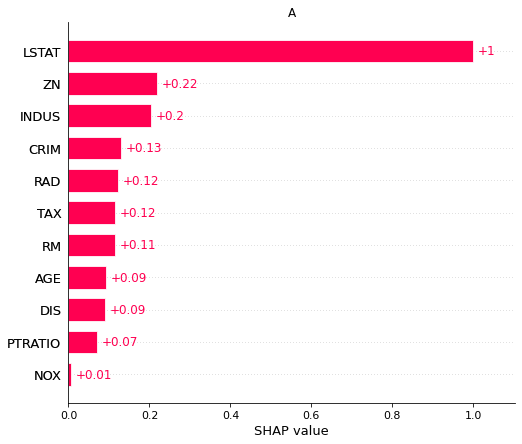

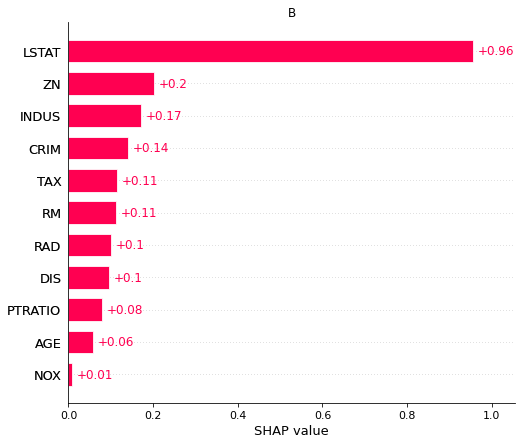

In [108]:
feature_order, feature_importances = calc_feature_order(explanations.indiv.log_odds.A)
plot_feature_importance_bar(feature_importances, 'A')
feature_order, feature_importances = calc_feature_order(explanations.indiv.log_odds.B)
plot_feature_importance_bar(feature_importances, 'B')

In [109]:
feature_order, _ = calc_feature_order(explanations.indiv.log_odds)

In [110]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_effects_comparison(color=is_pred_diff,
                                    **{'A': explanations.indiv.log_odds.A[:, [feature_idx]],
                                       'B': explanations.indiv.log_odds.B[:, [feature_idx]]})
it = iter(feature_order)

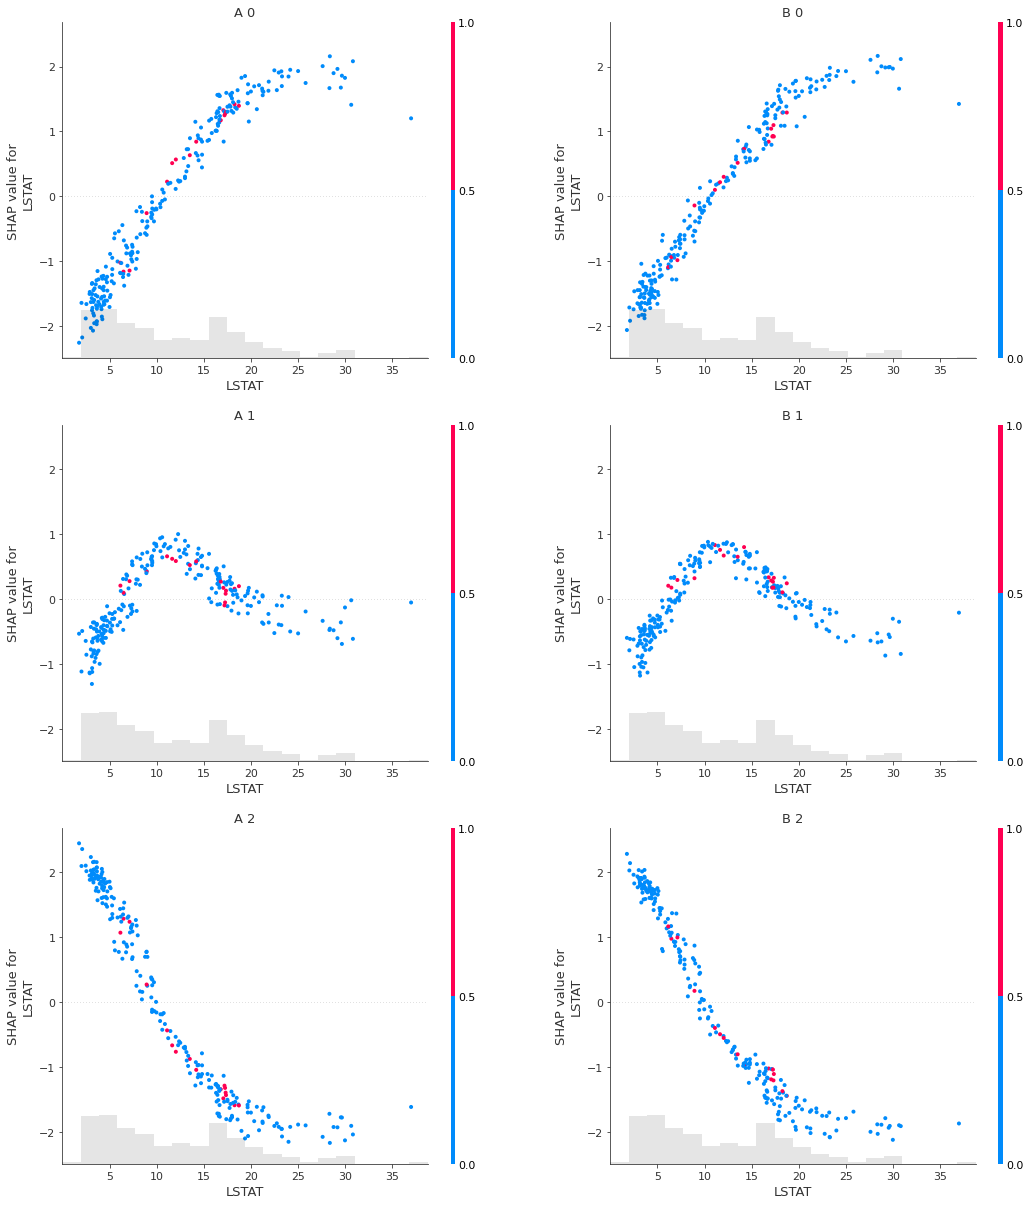

In [111]:
plot_next_feature()

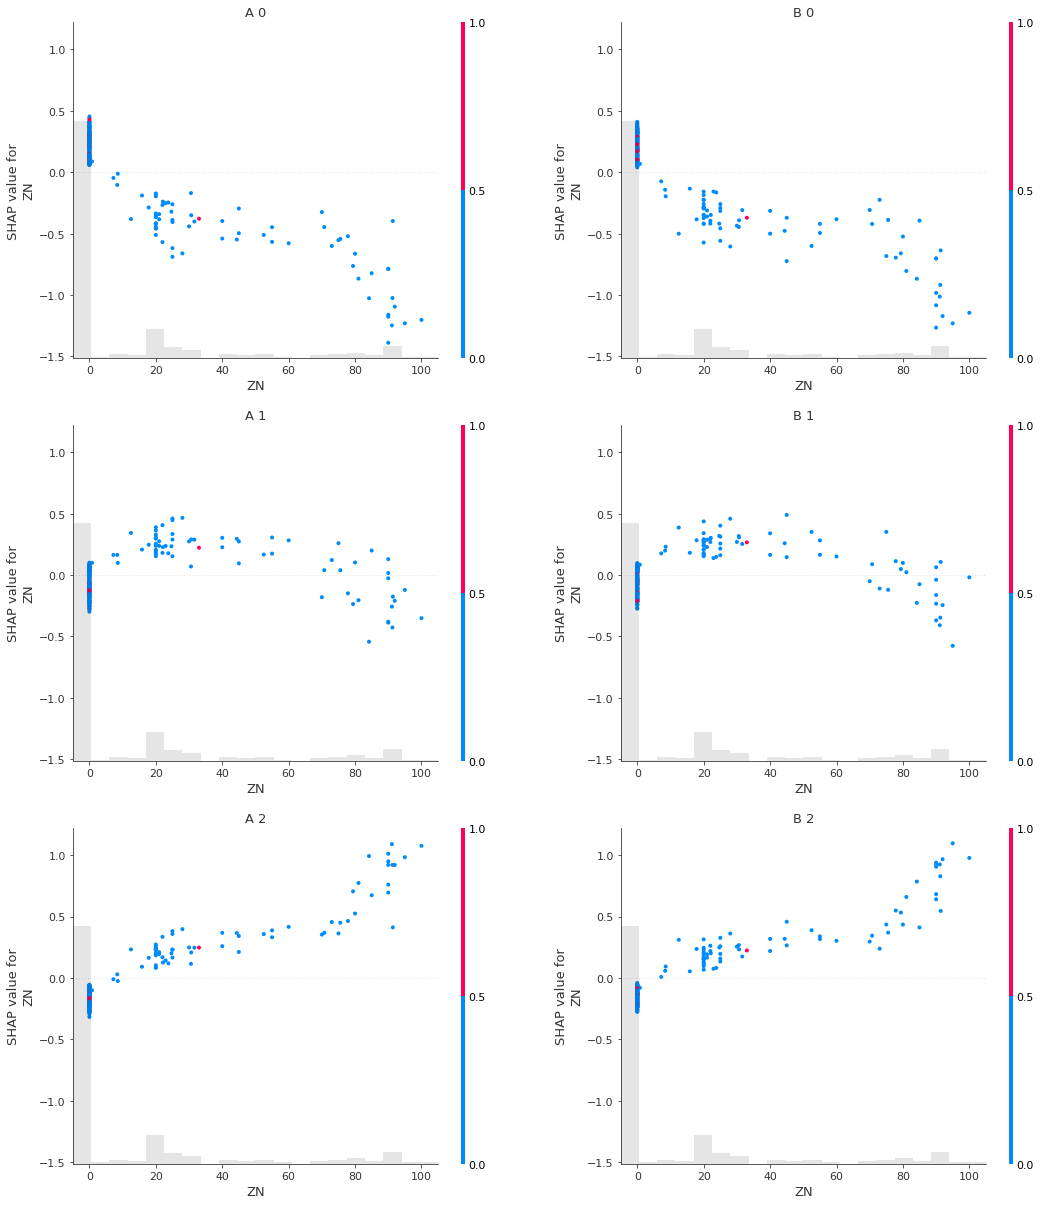

In [112]:
plot_next_feature()

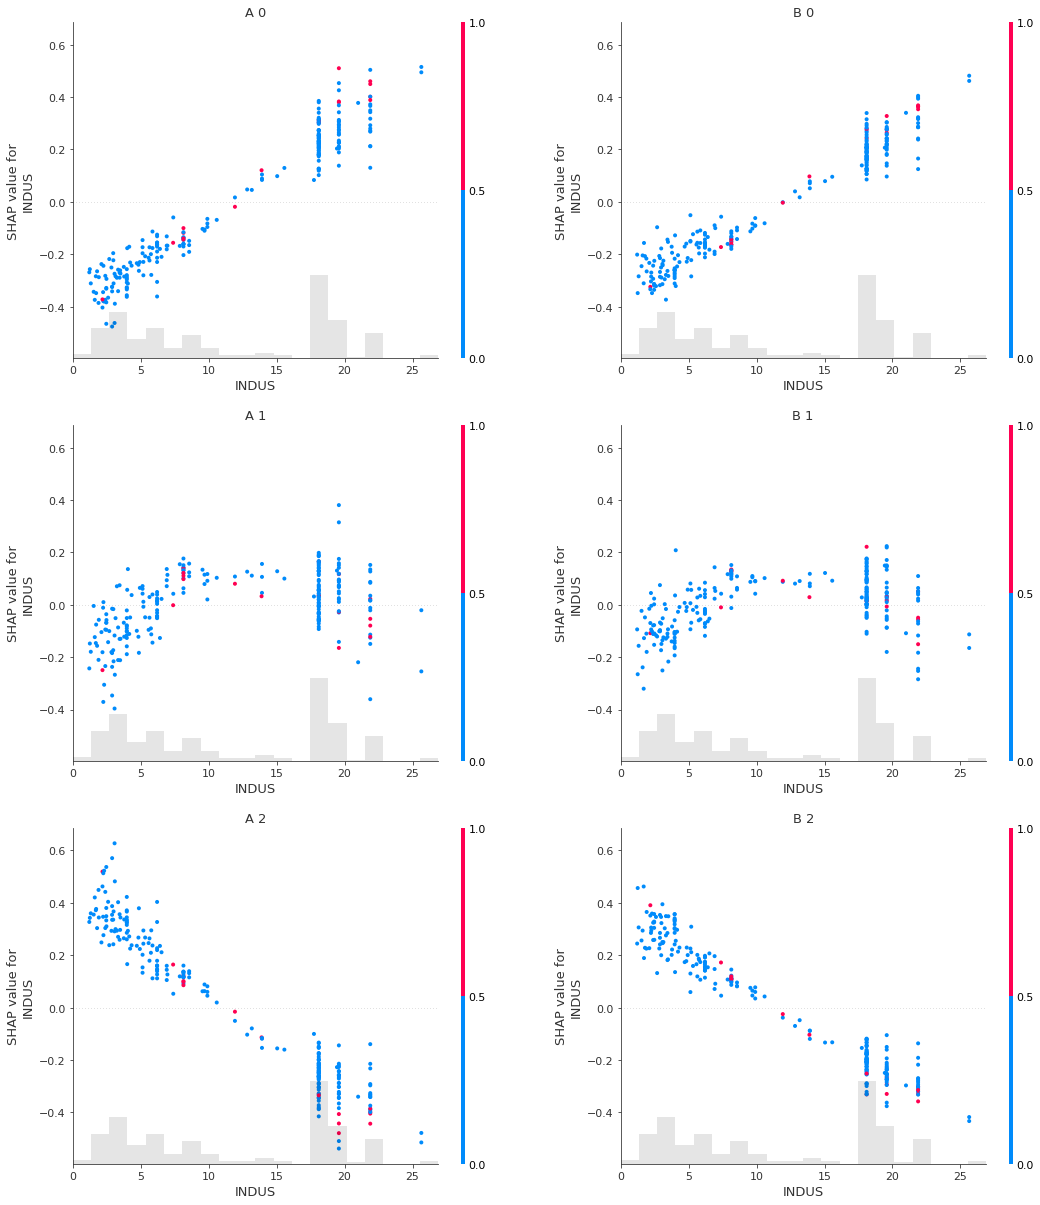

In [113]:
plot_next_feature()

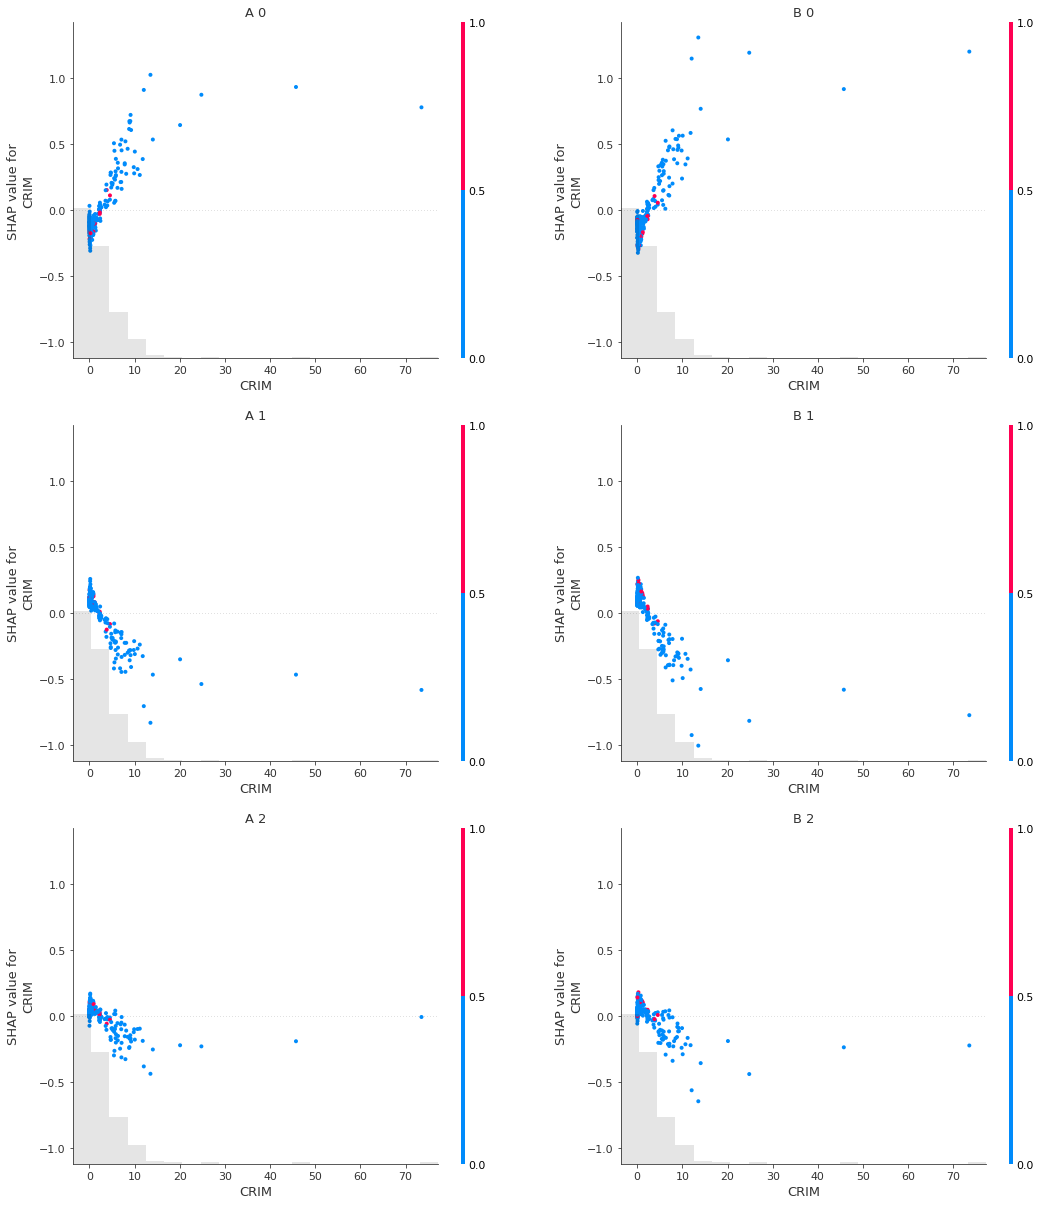

In [114]:
plot_next_feature()

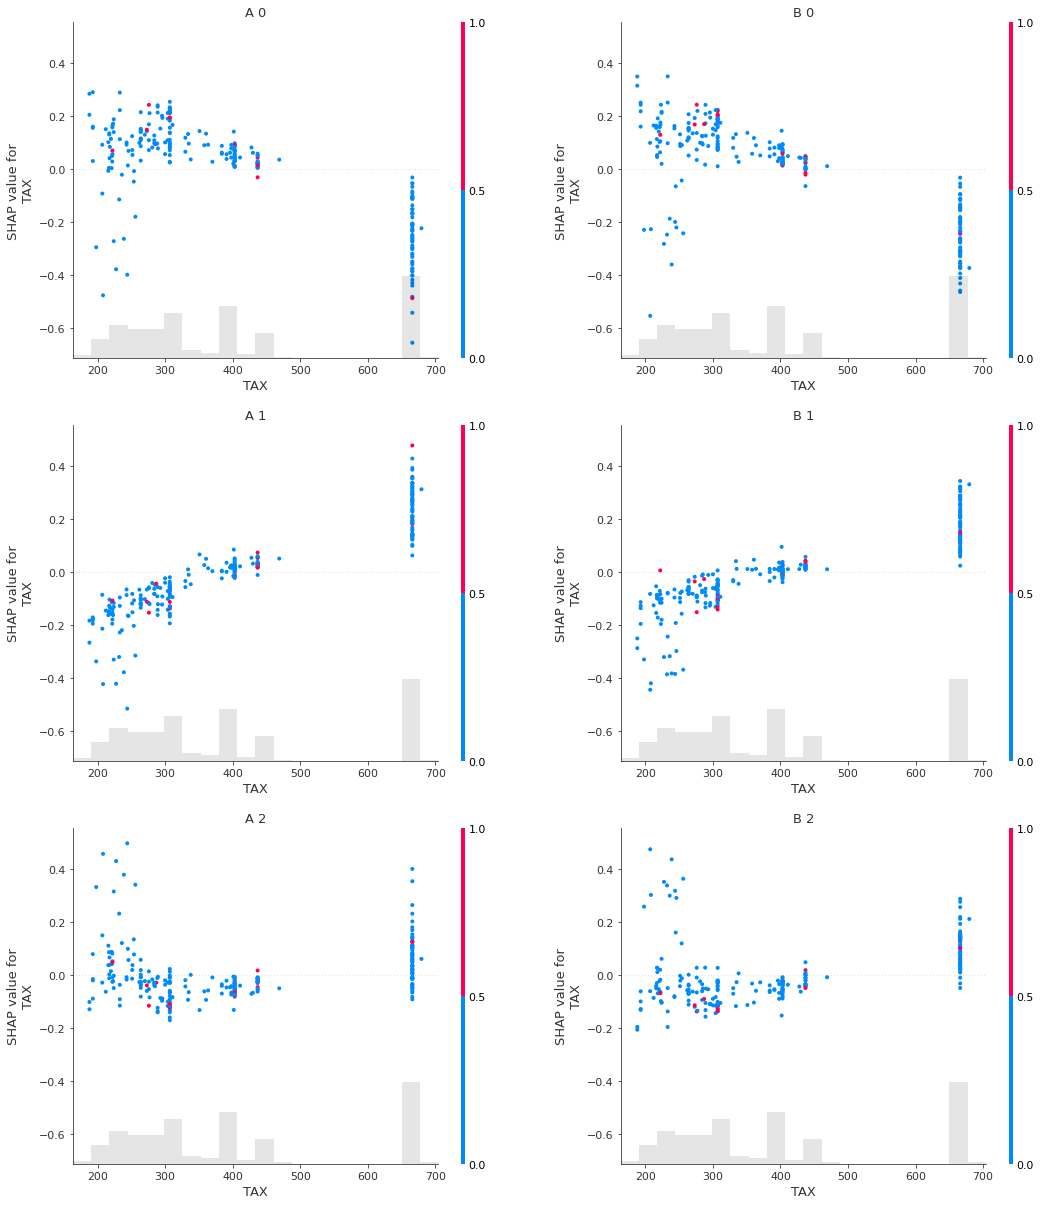

In [115]:
plot_next_feature()

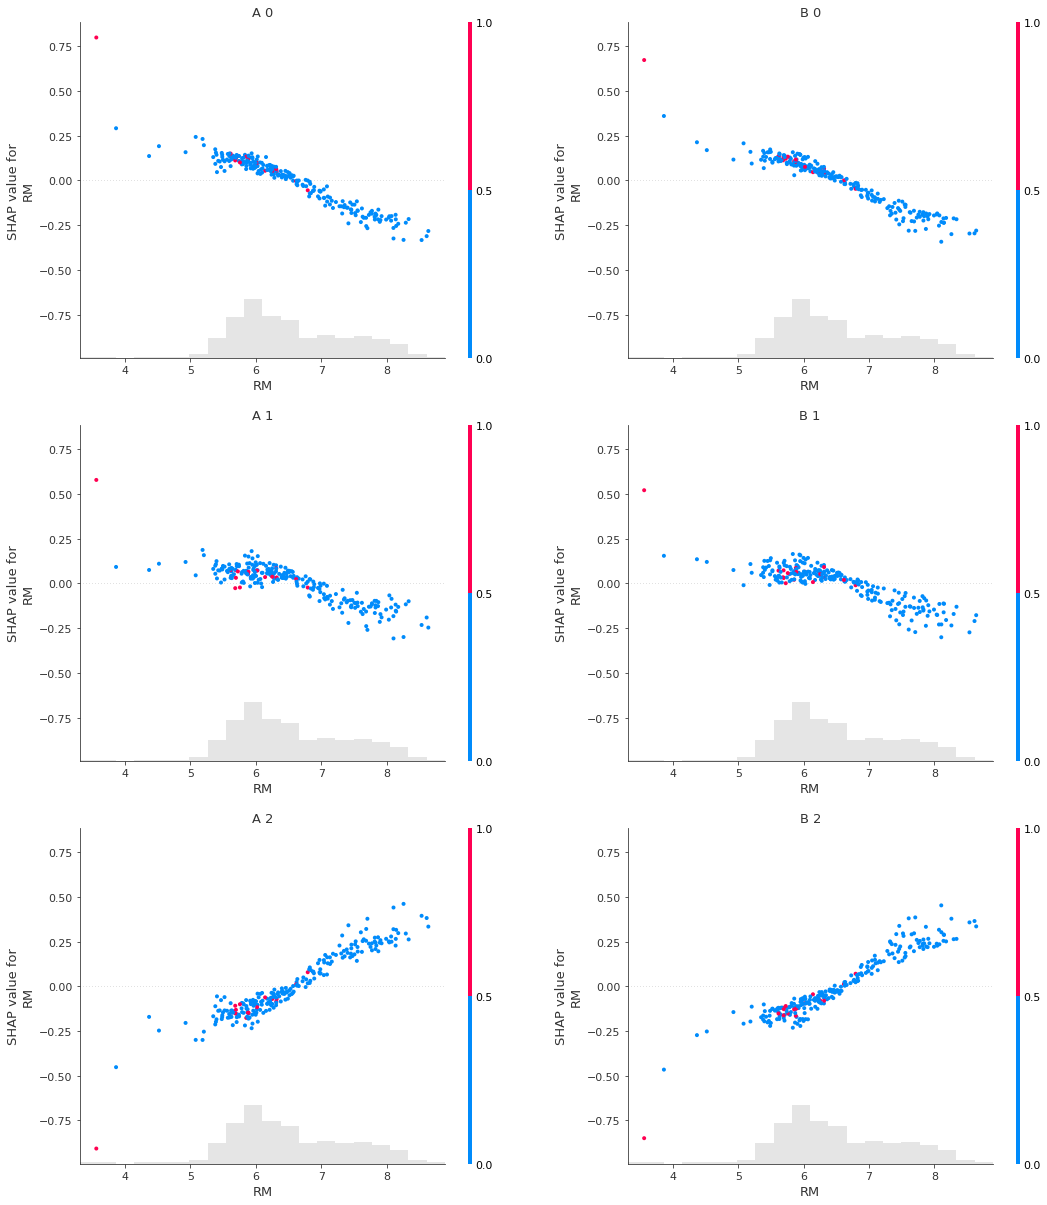

In [116]:
plot_next_feature()

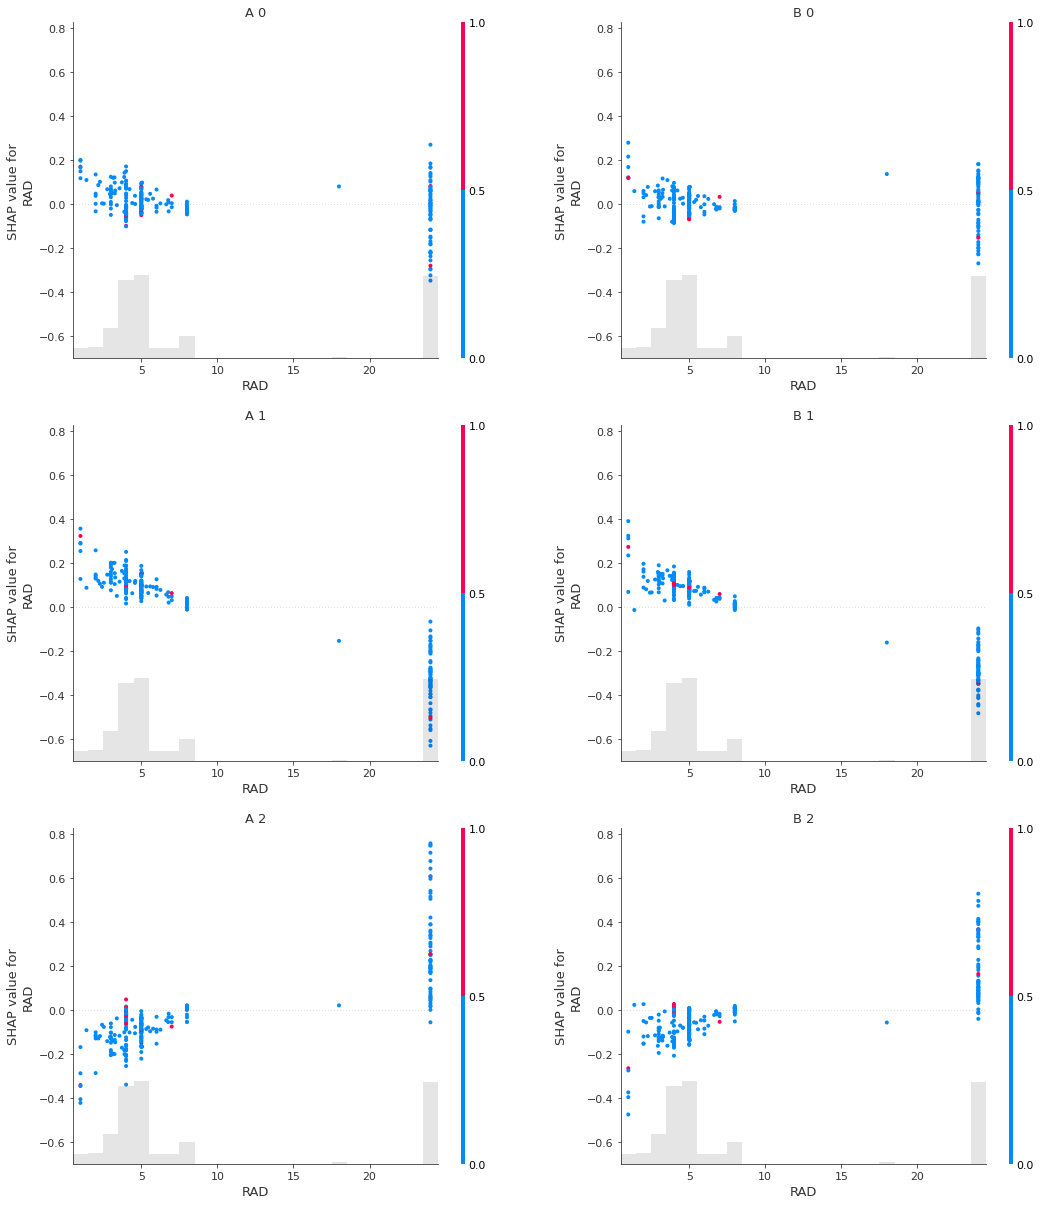

In [117]:
plot_next_feature()

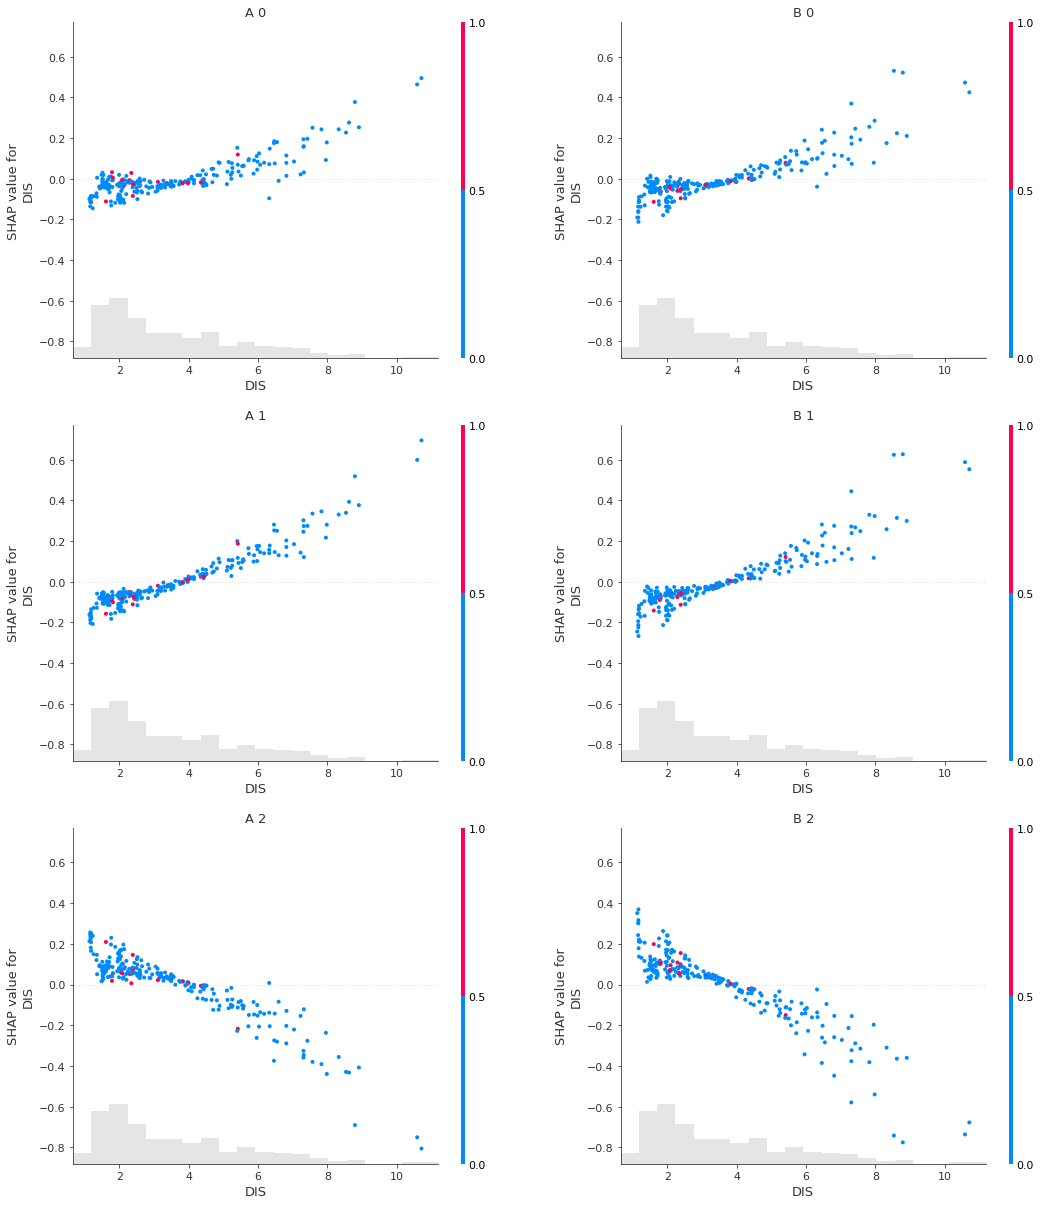

In [118]:
plot_next_feature()

AGE has more differences than the other features. It has linear effects for both classifiers, but with opposite directions.

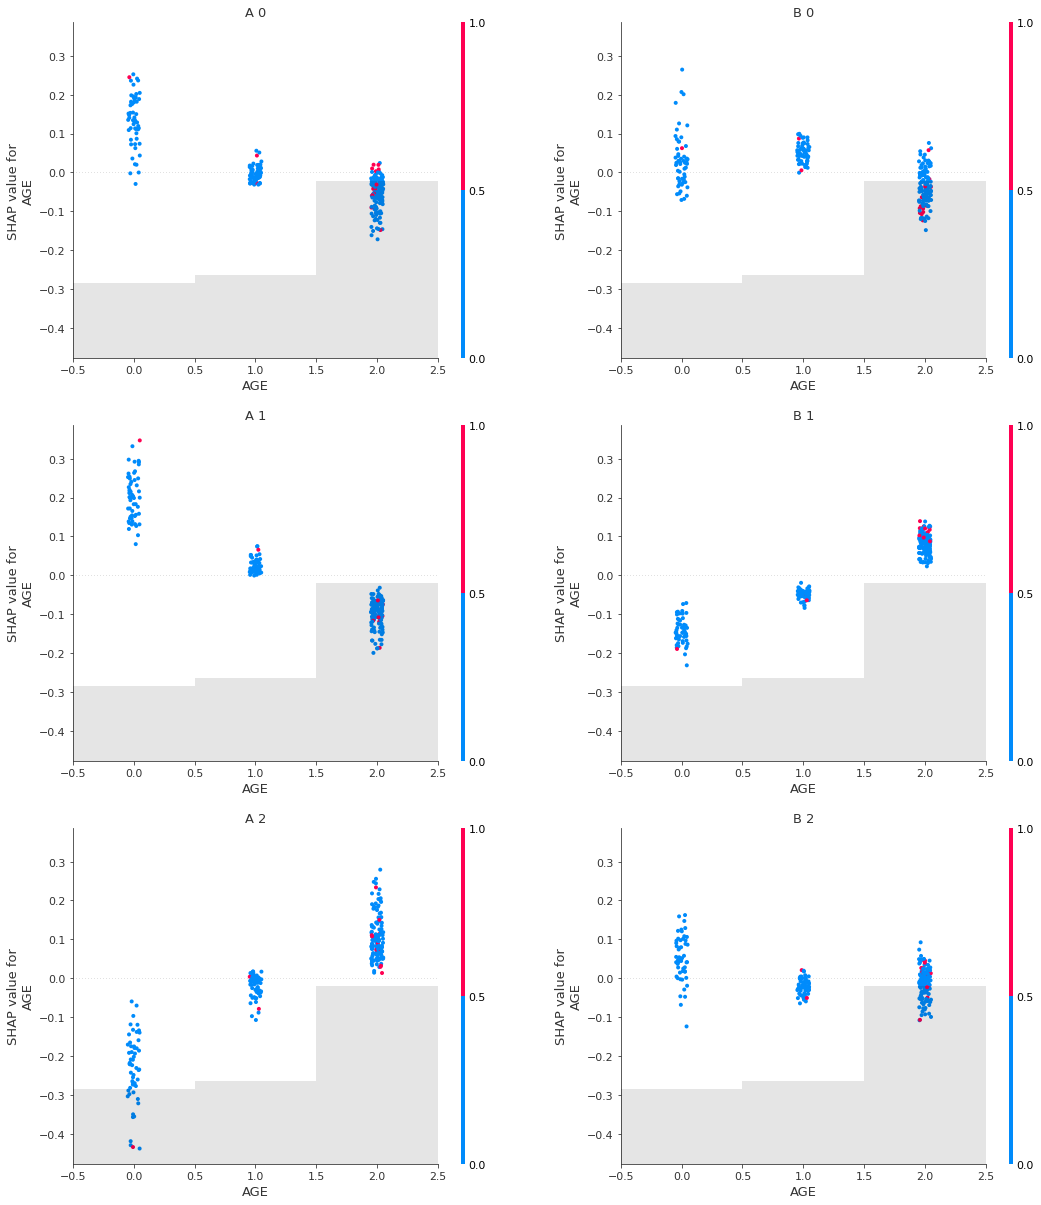

In [119]:
plot_next_feature()

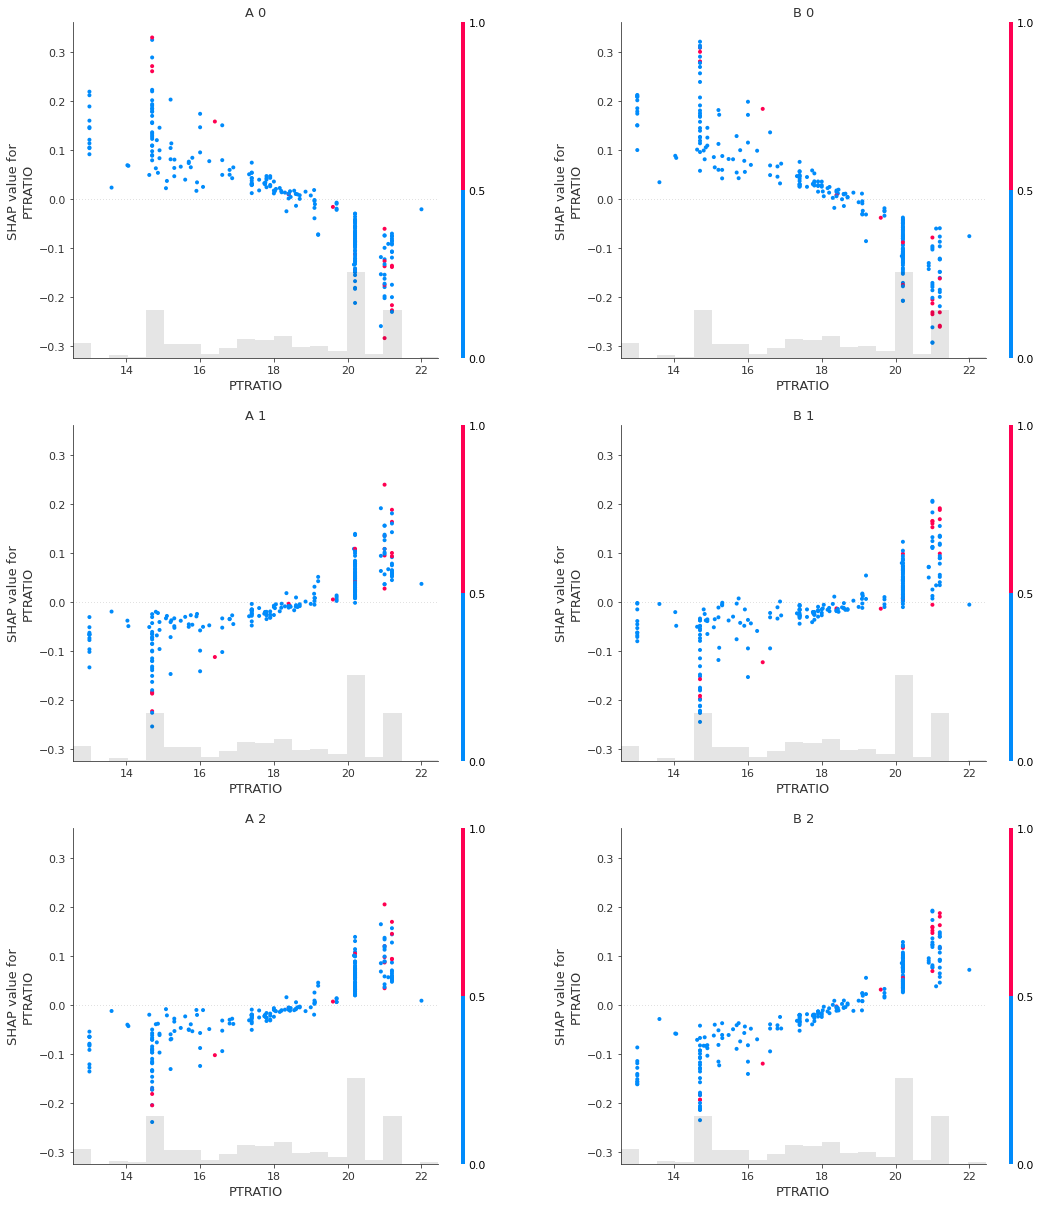

In [120]:
plot_next_feature()

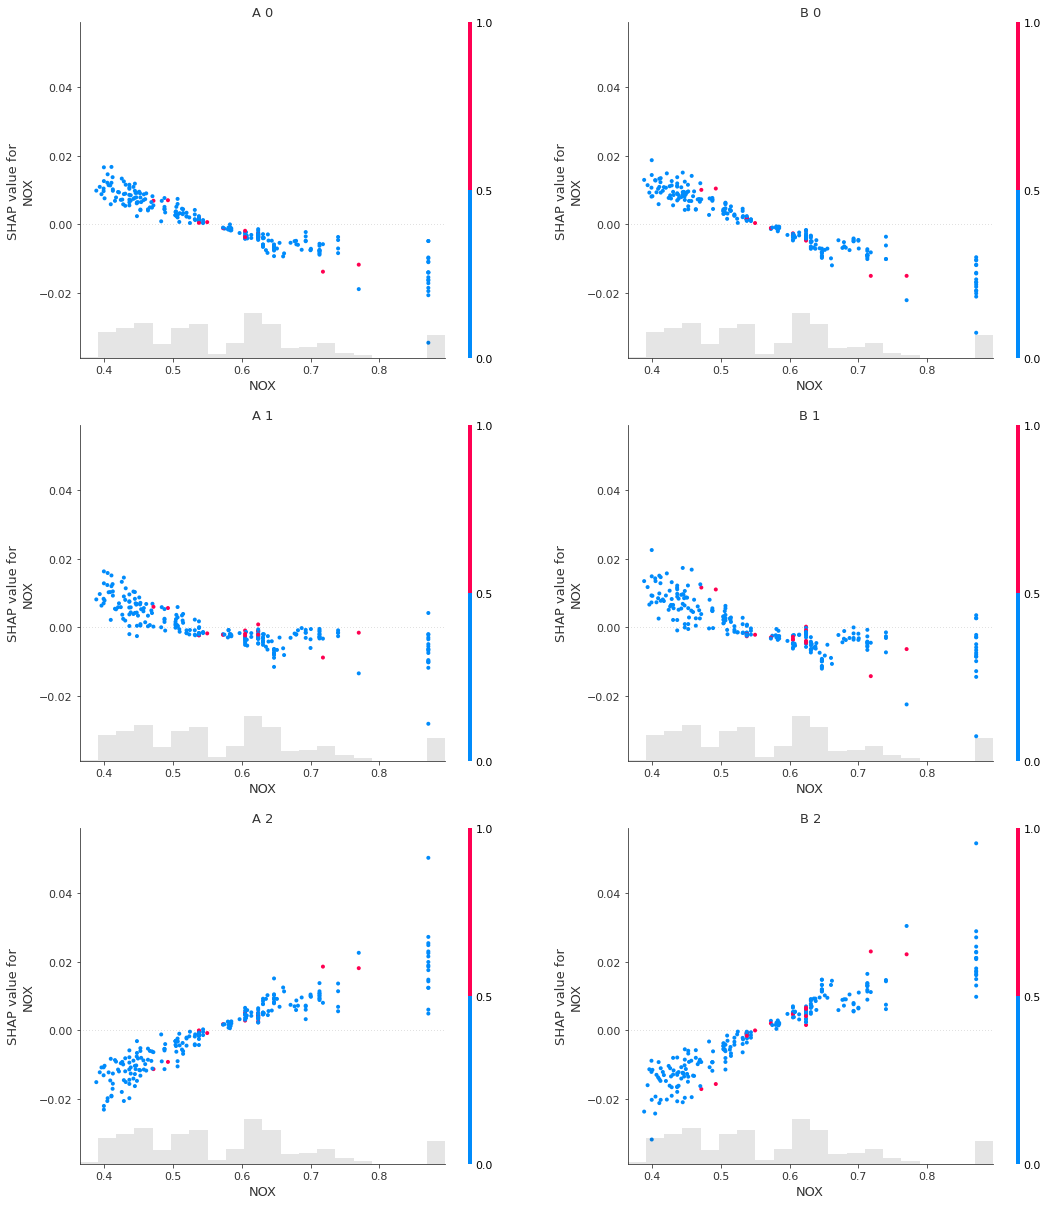

In [121]:
plot_next_feature()

## SHAP-based Difference Classifier Explanations

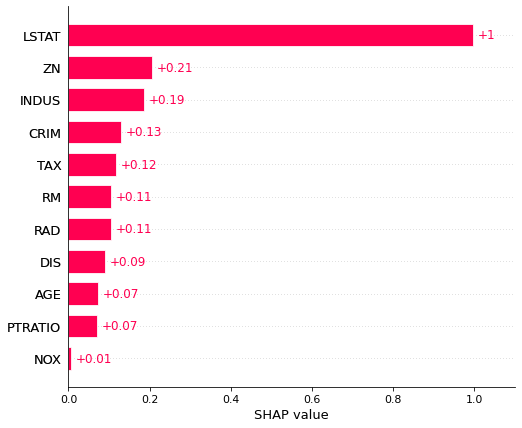

In [5]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.log_odds)
global_feature_order = feature_order
plot_feature_importance_bar(feature_importances)

In [105]:
X.iloc[:, feature_order].describe()

LSTAT          ZN       INDUS        CRIM         TAX          RM  \
count  246.000000  246.000000  246.000000  246.000000  246.000000  246.000000   
mean    11.736981   12.841063   11.718208    2.720010  403.132604    6.511388   
std      7.372550   25.552540    7.290396    6.388147  165.416533    0.889747   
min      1.763949    0.000000    1.210000    0.009060  188.000000    3.561000   
25%      5.008267    0.000000    4.243588    0.099321  273.000000    5.882000   
50%      9.950000    0.000000    9.900000    0.540032  362.186013    6.315500   
75%     17.091674   20.000000   18.100000    3.181873  461.000000    7.134552   
max     36.980000  100.000000   25.650000   73.534100  679.526743    8.638029   

              RAD         DIS         AGE     PTRATIO         NOX  
count  246.000000  246.000000  246.000000  246.000000  246.000000  
mean     9.346908    3.501706    1.304878   18.125578    0.572581  
std      8.493772    2.007156    0.813494    2.524334    0.125307  
min      1.000000    1.137912    0.000000   13.000000    0.389000  
25%      4.000000    1.967365    1.000000   15.707491    0.462112  
50%      5.000000    2.866600    2.000000   18.571912    0.544000  
75%      8.000000    4.621654    2.000000   20.200000    0.638740  
max     24.000000   10.710300    2.000000   22.000000    0.871000

In [106]:
X['AGE'].value_counts()

2.0    130
1.0     61
0.0     55
Name: AGE, dtype: int64

The equality classes $(0,0)$ and $(2,2)$ have the highest mean absolute SHAP value, which means that the influences to and from these classes are highest. 

$(0,2)$ and $(2,0)$ have the least importances.

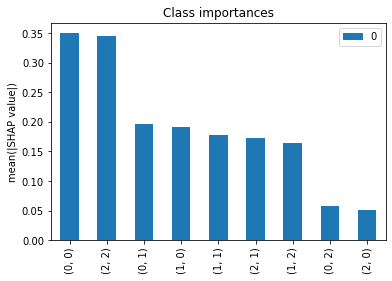

In [24]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.log_odds)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

In [25]:
class_order = np.sort(class_order[:-2])

In [96]:
def plot_next_feature():
    feature_idx = next(it)
    # plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, [feature_idx]], class_order=class_order)
    plot_feature_effects(explanations.mclass_diff.log_odds[:, [feature_idx], class_order[:4]], color=is_pred_diff)
    plot_feature_effects(explanations.mclass_diff.log_odds[:, [feature_idx], class_order[3:]], color=is_pred_diff)
it = iter(feature_order)

Difference classes $(0,1)$ and $(1,0)$ are at their peak between approx. 11 and 20, $(1,2)$ and $(2,1)$ in the range between approx. 5 and 10.

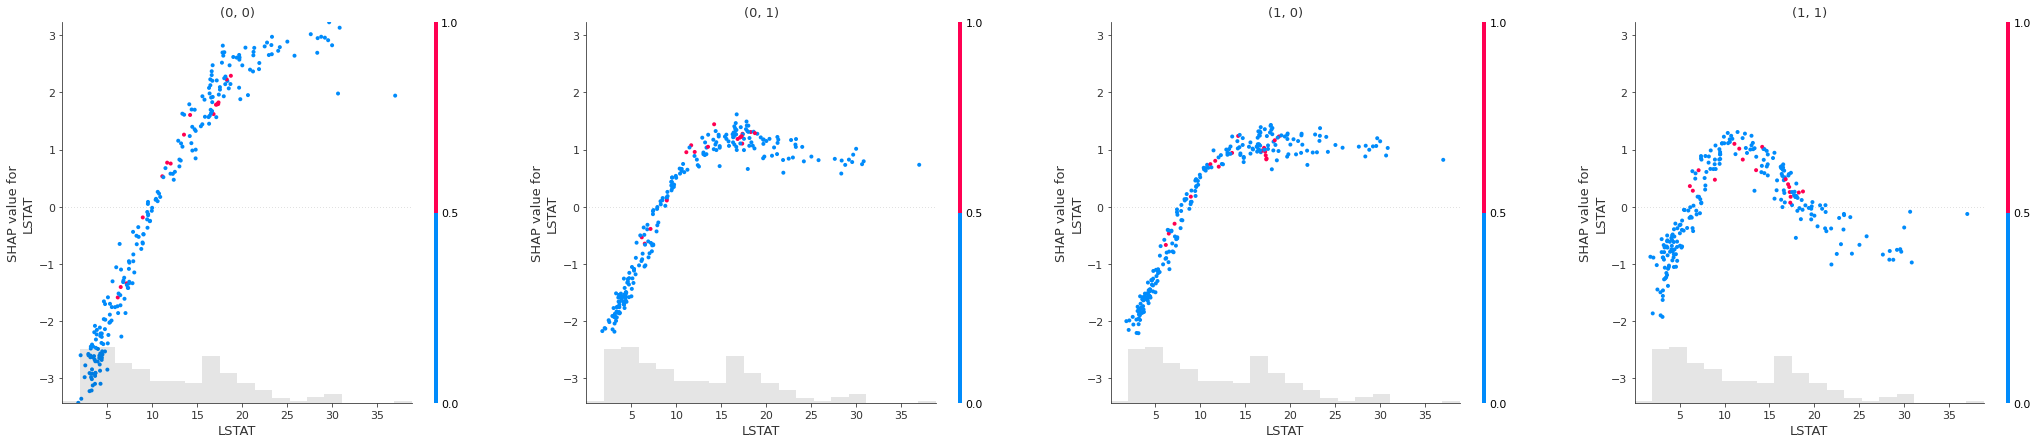

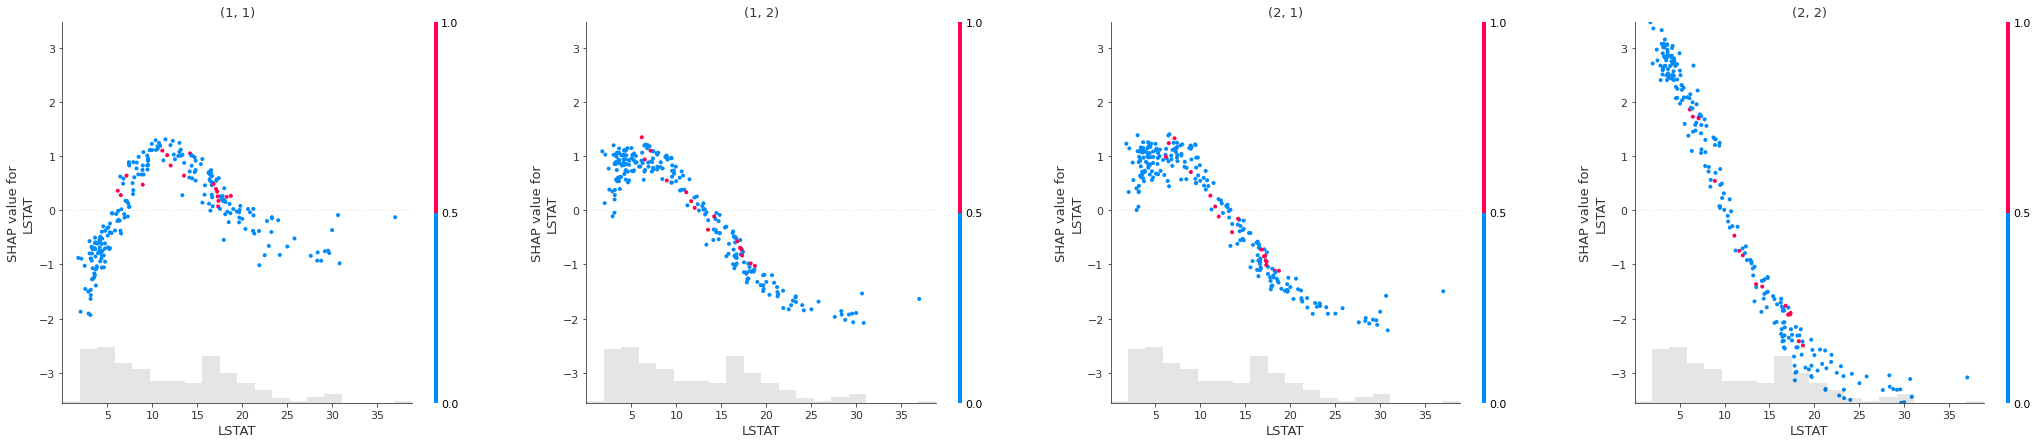

In [97]:
plot_next_feature()

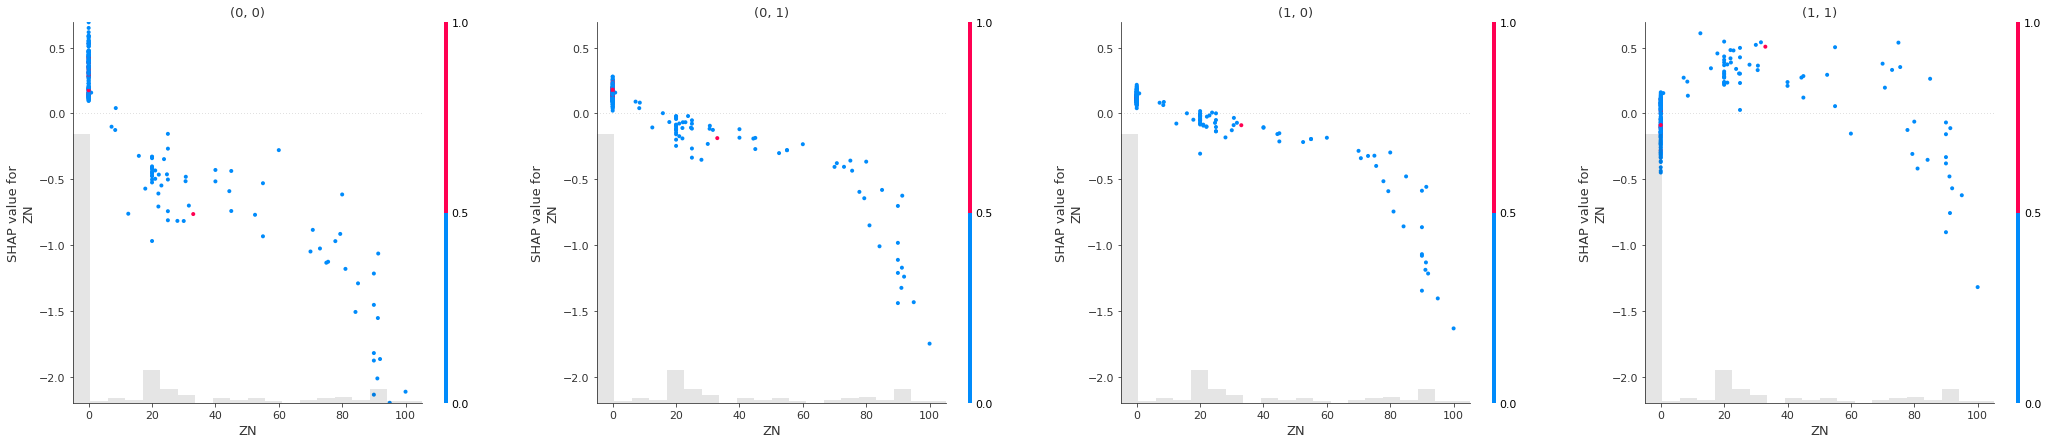

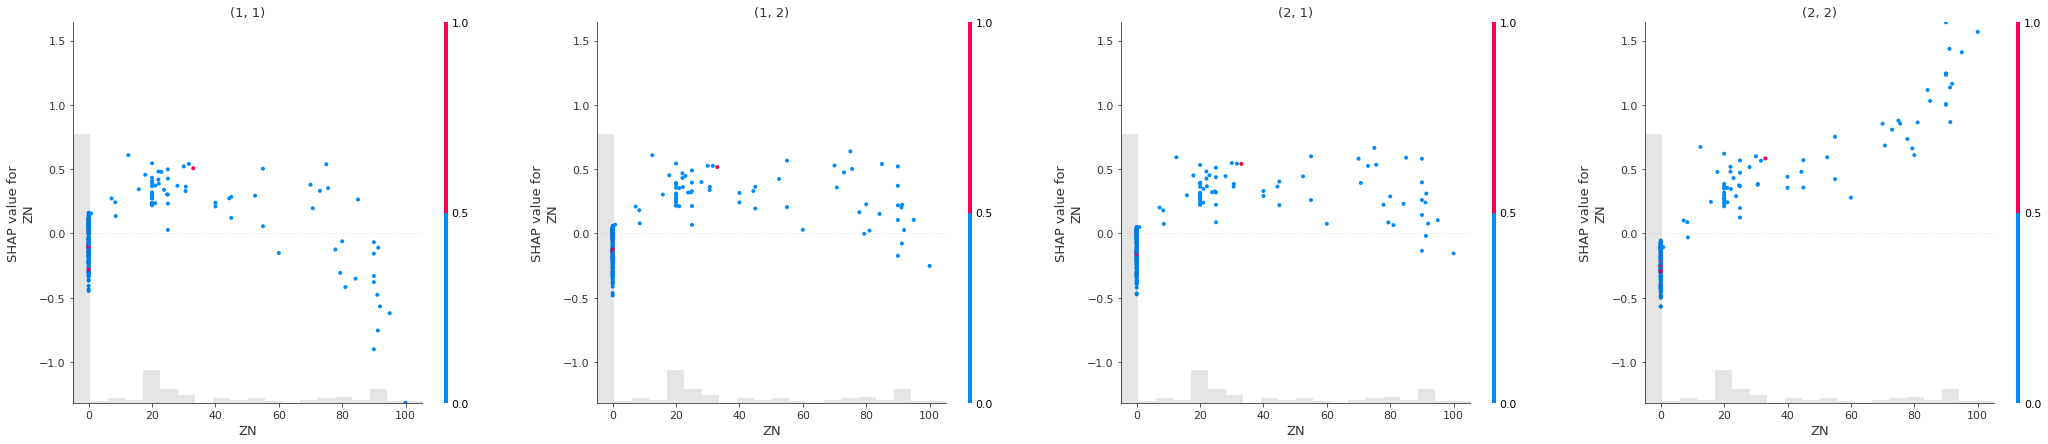

In [98]:
plot_next_feature()

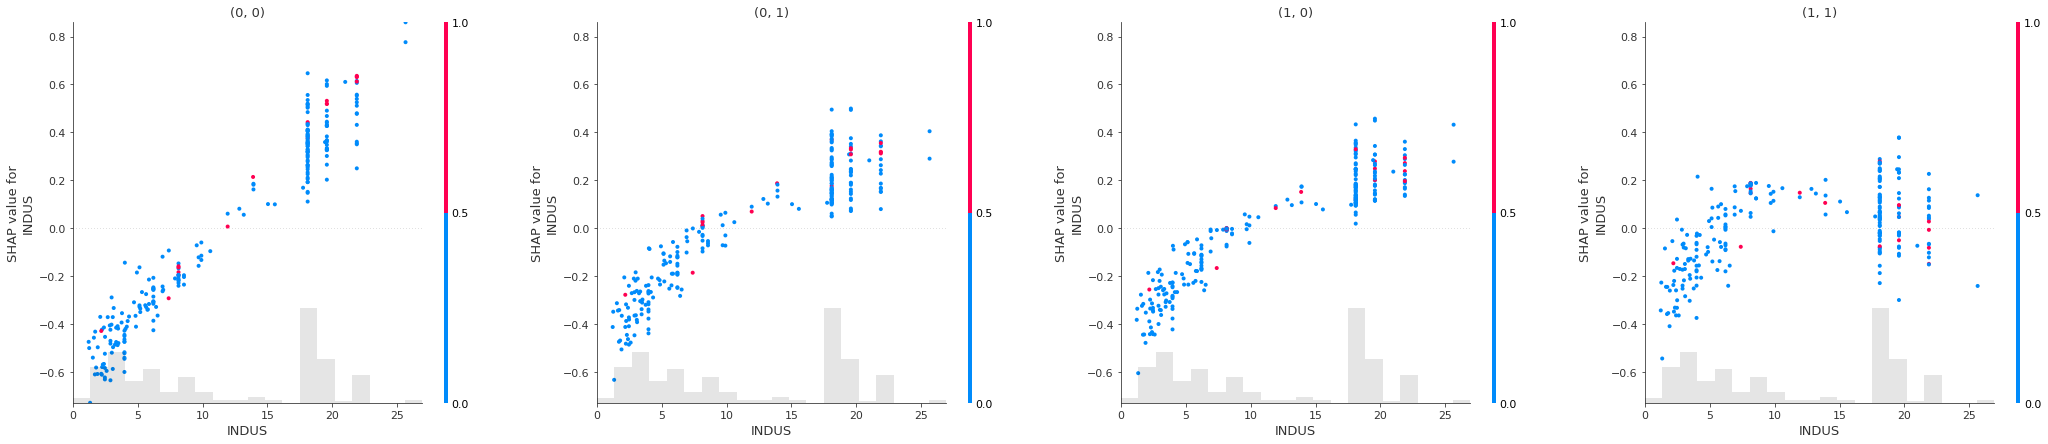

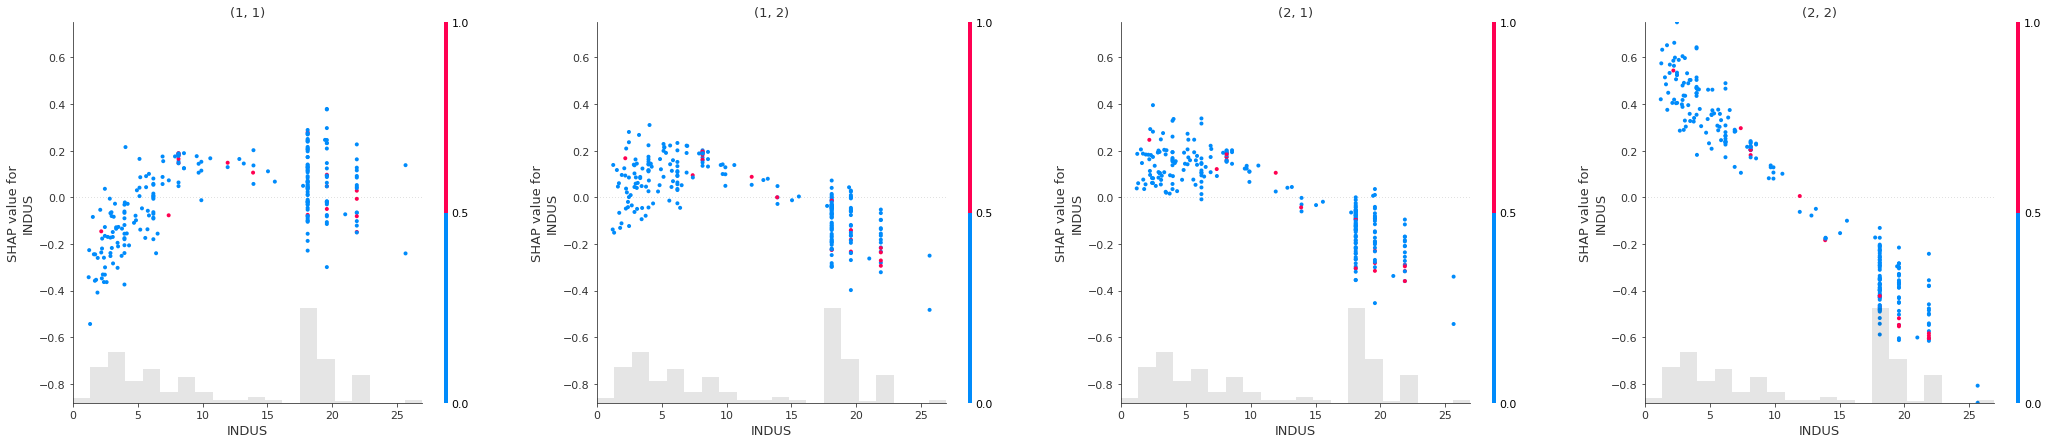

In [99]:
plot_next_feature()

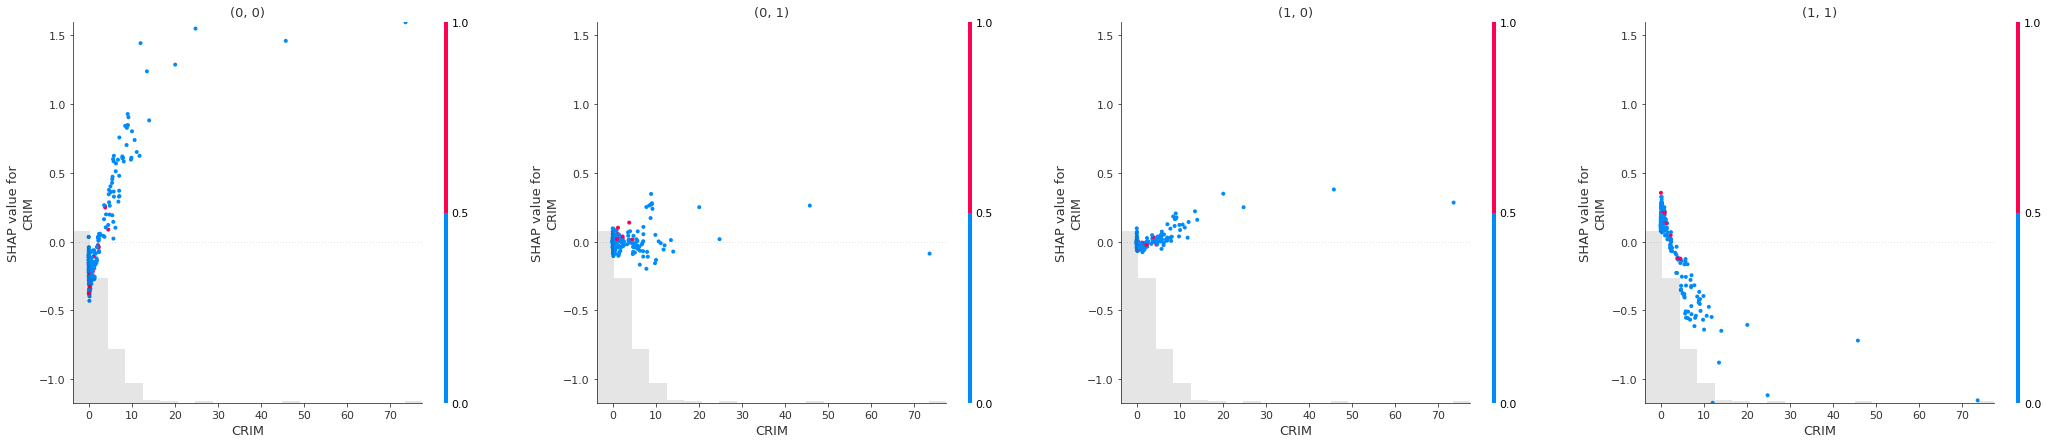

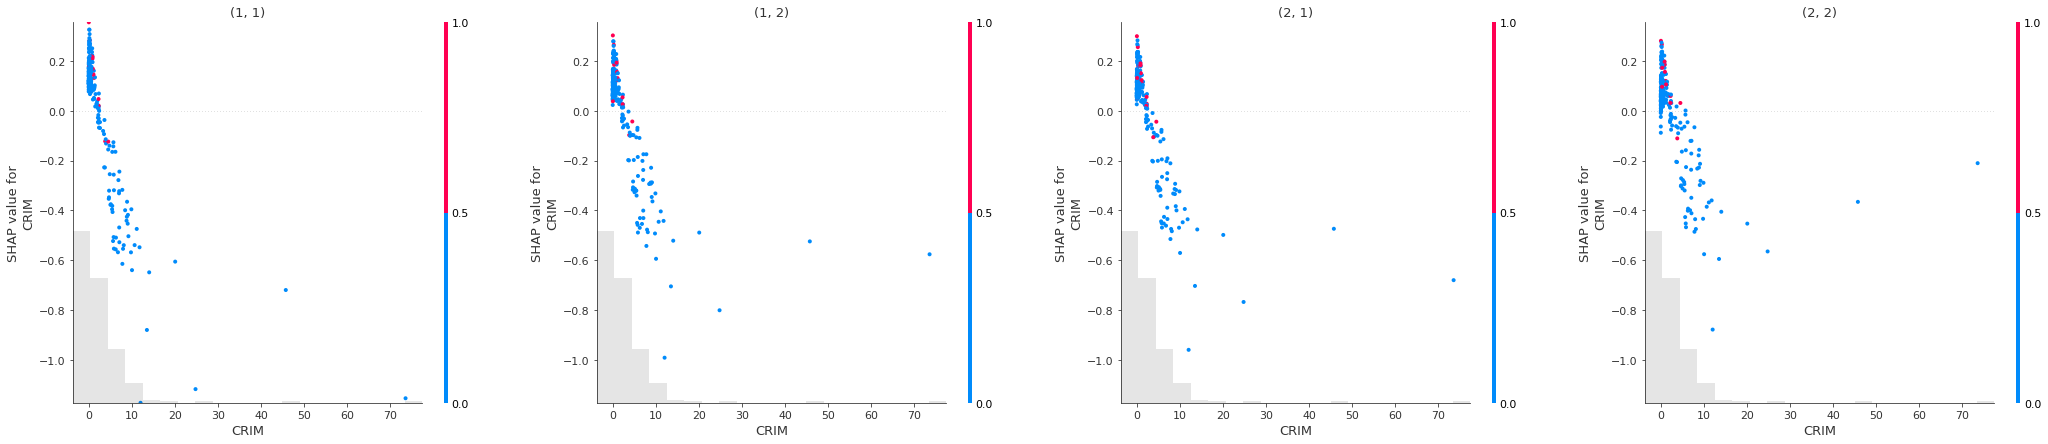

In [100]:
plot_next_feature()

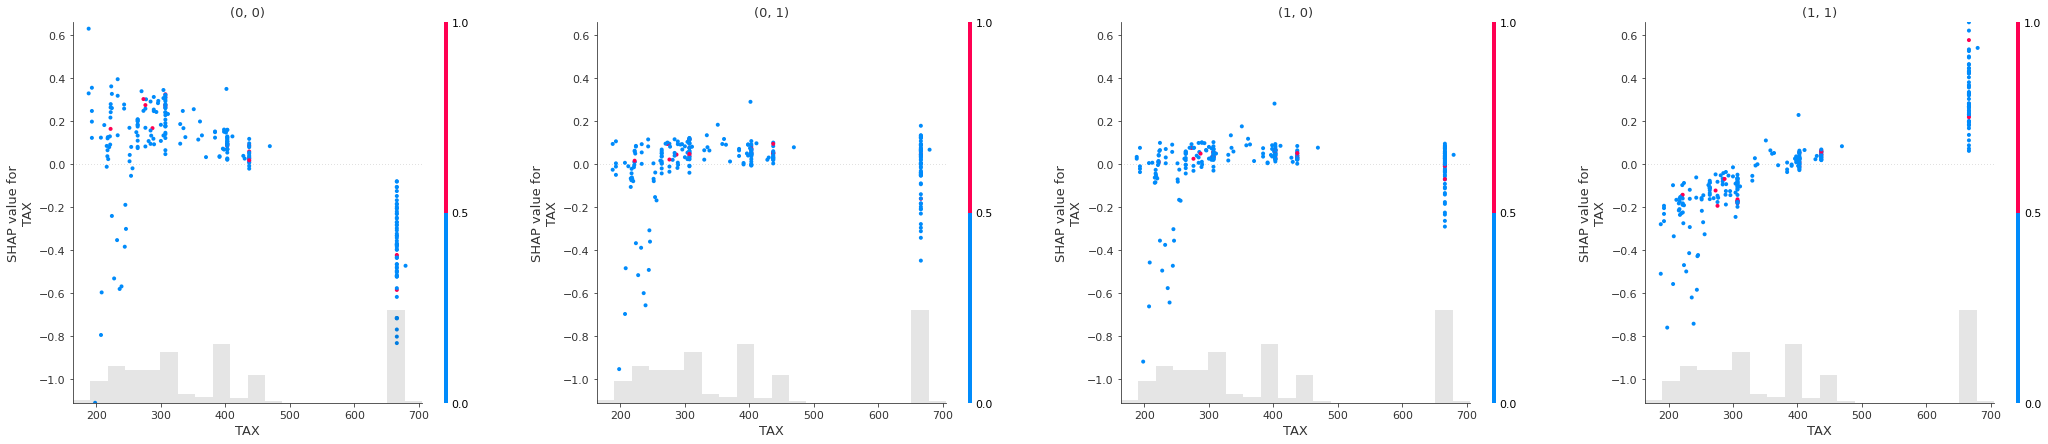

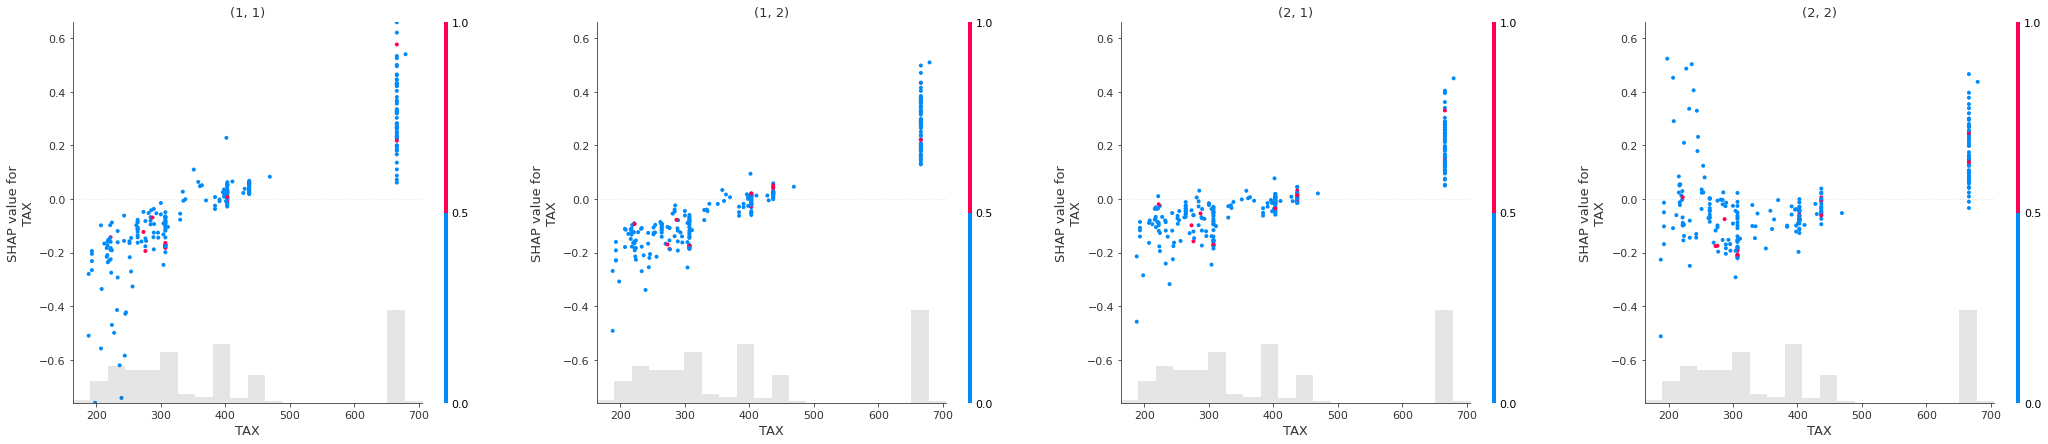

In [101]:
plot_next_feature()

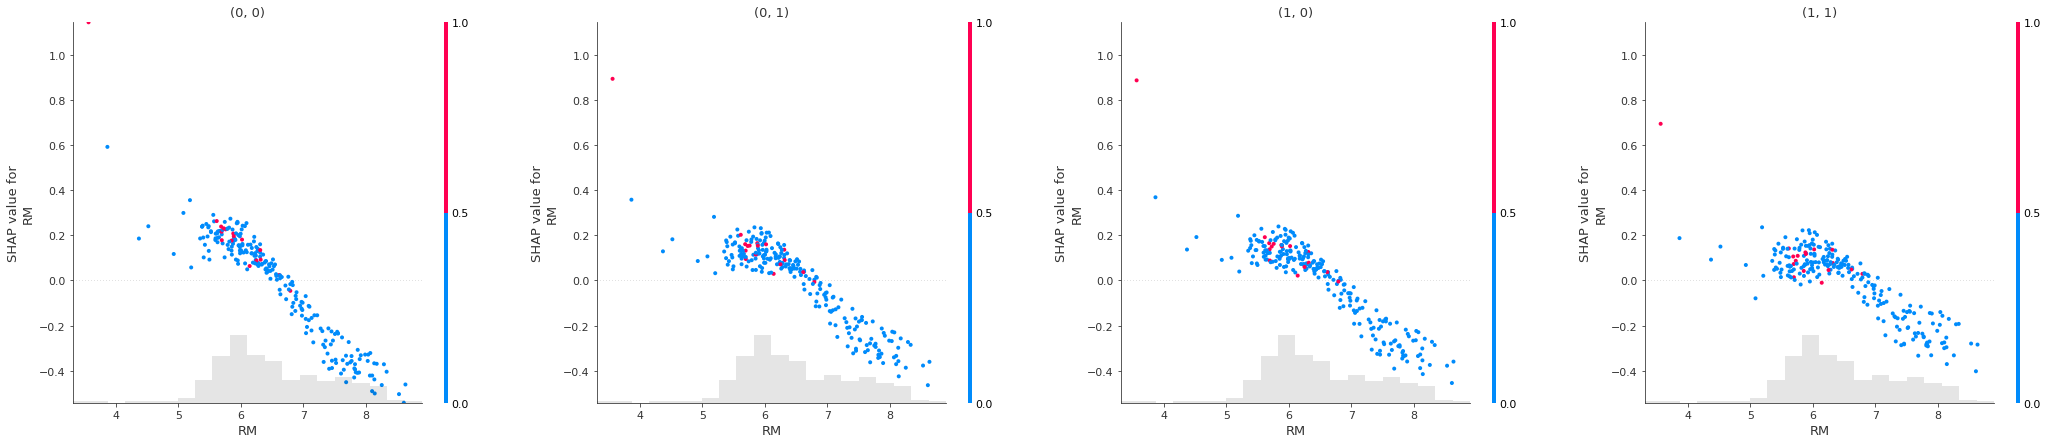

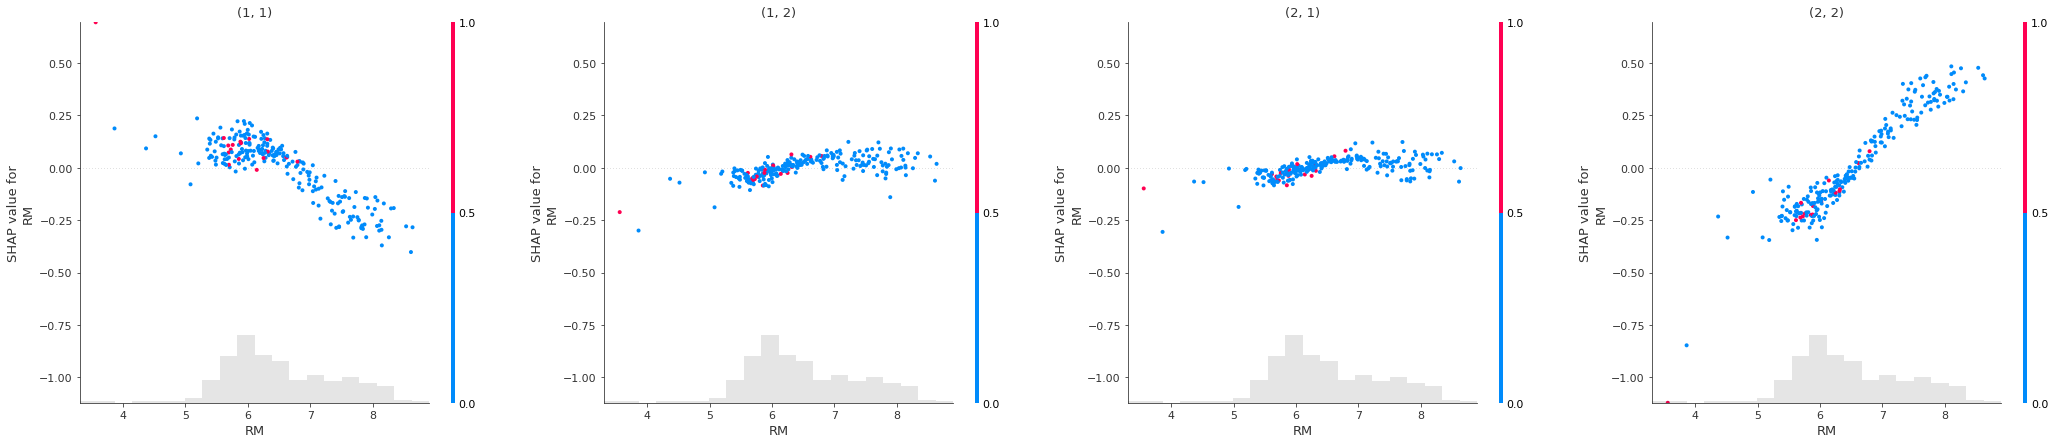

In [102]:
plot_next_feature()

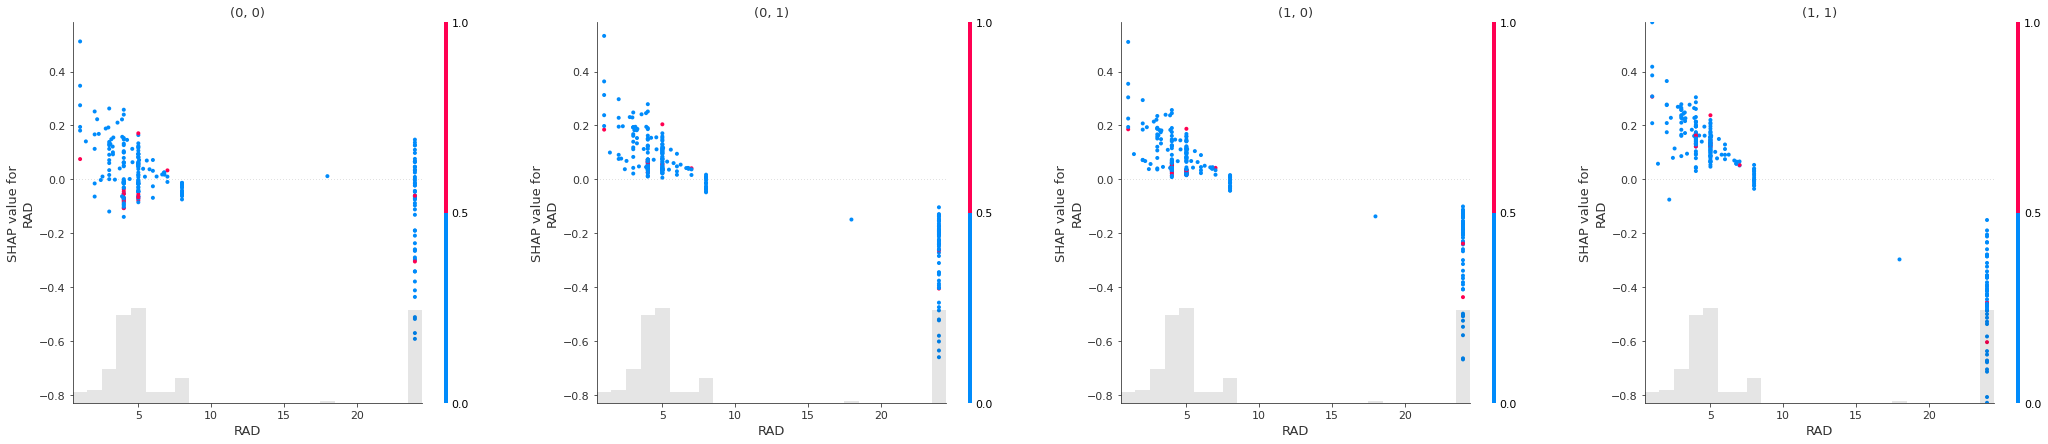

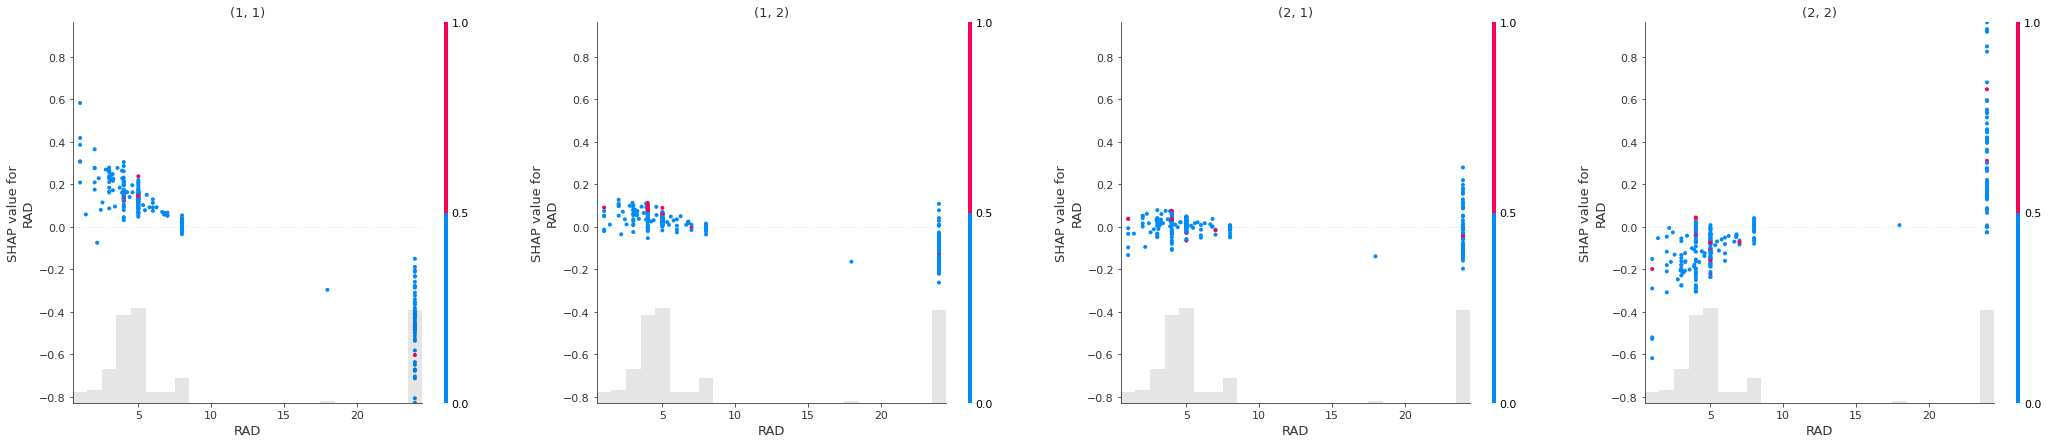

In [103]:
plot_next_feature()

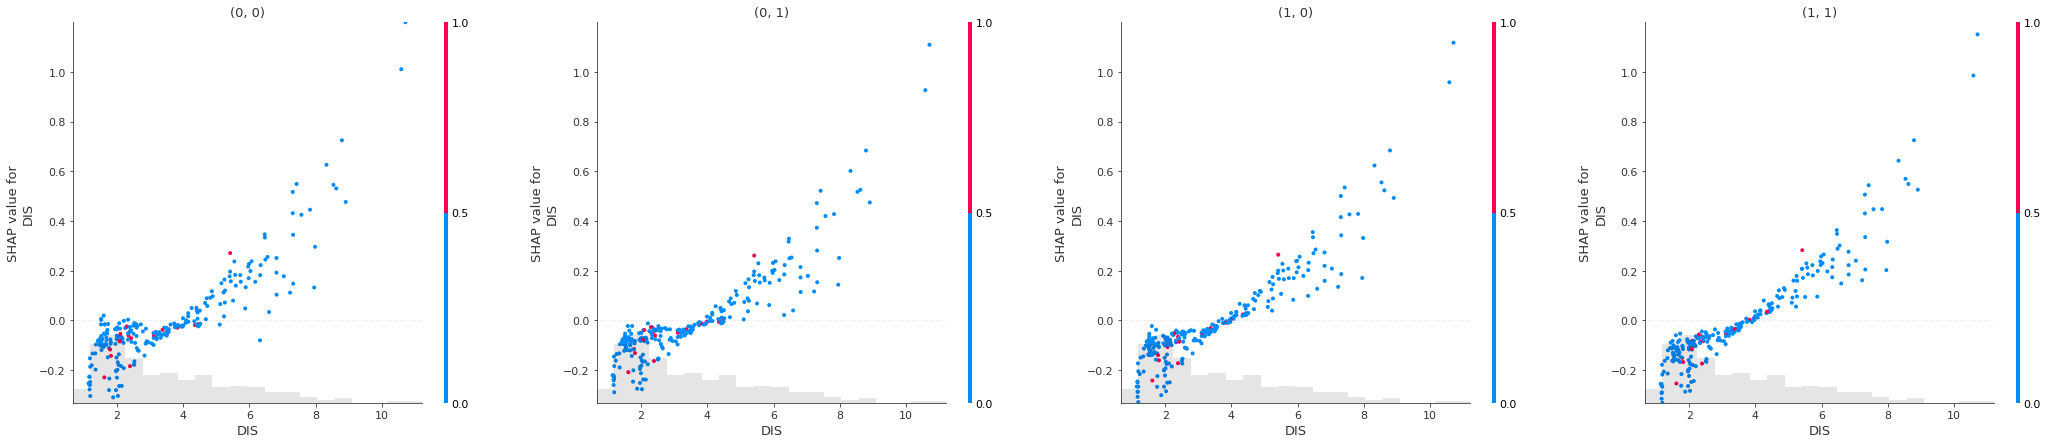

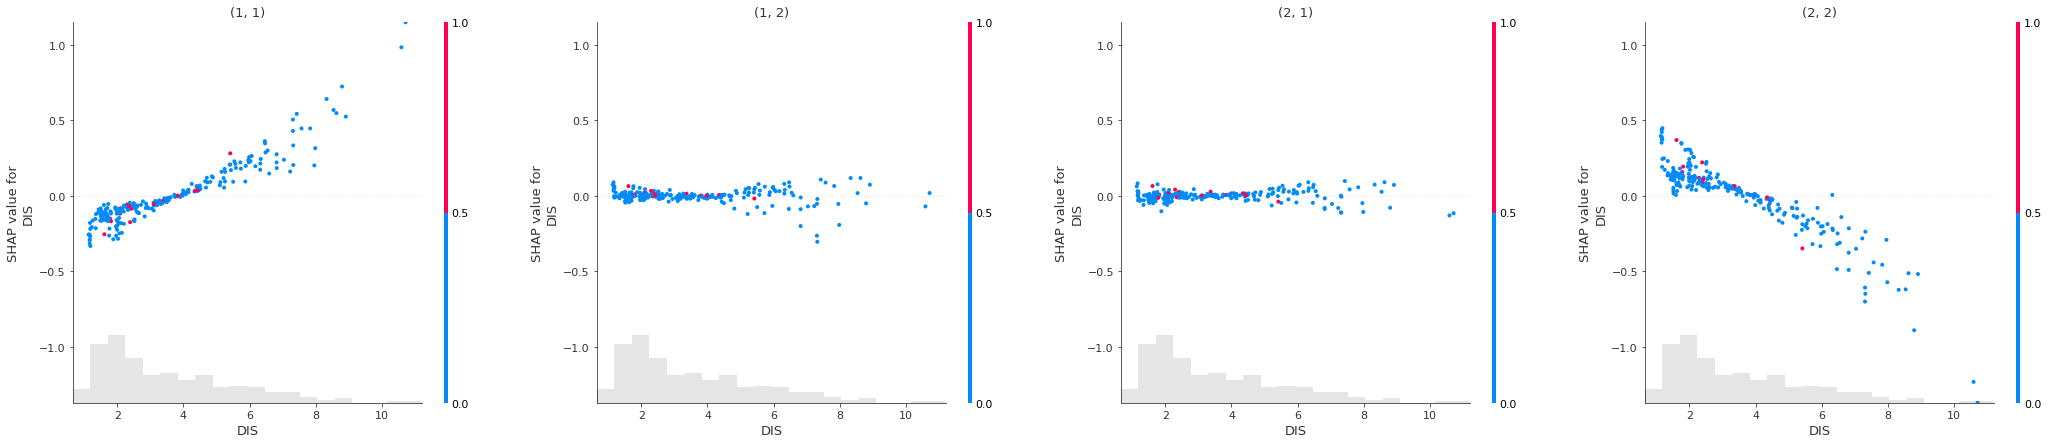

In [104]:
plot_next_feature()

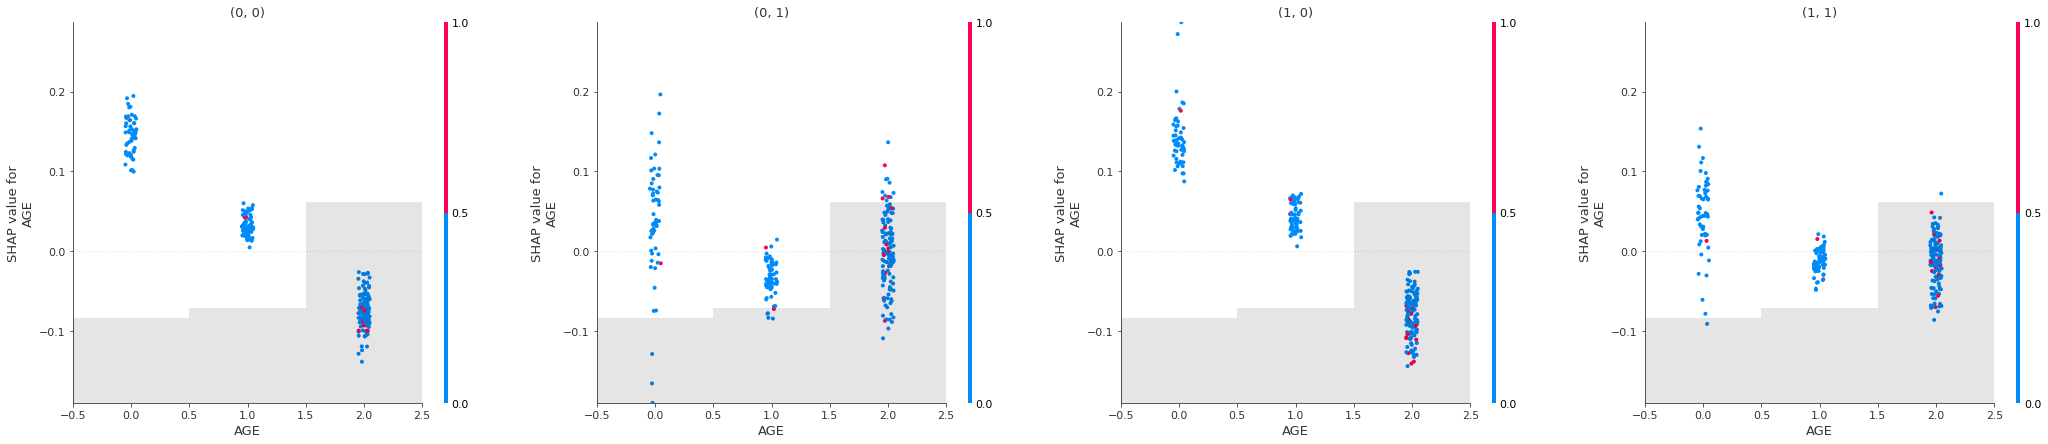

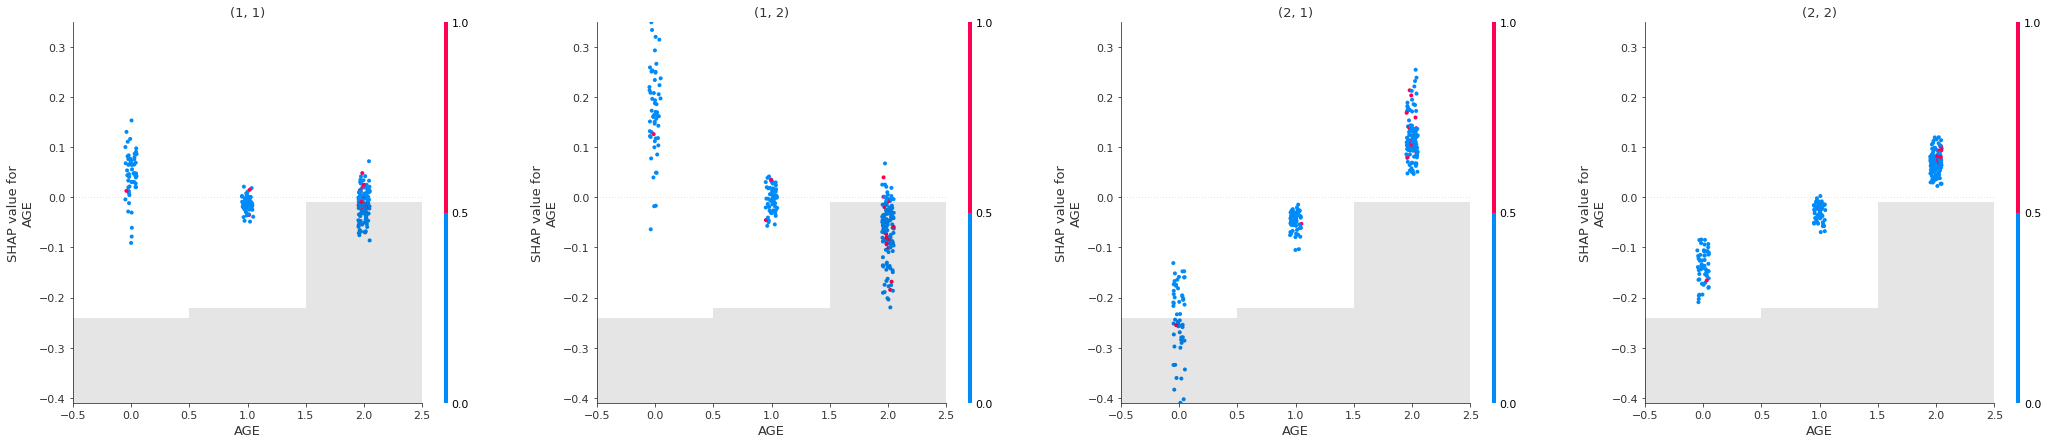

In [105]:
plot_next_feature()

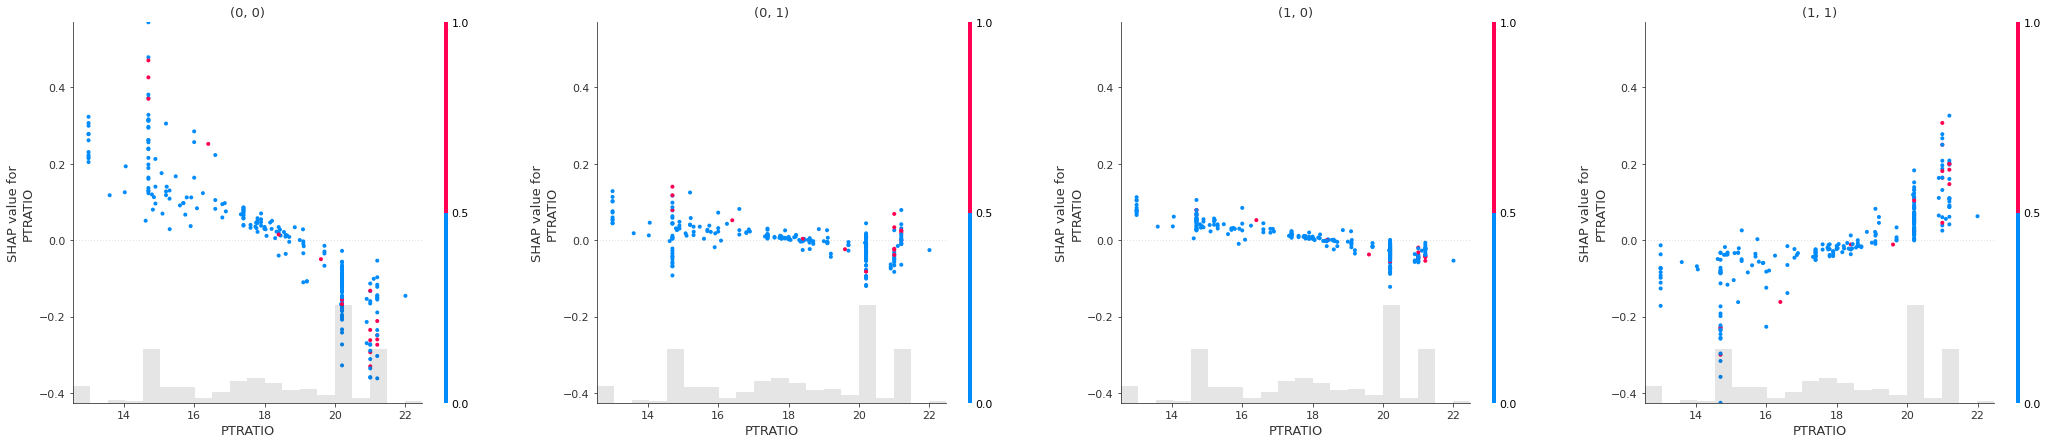

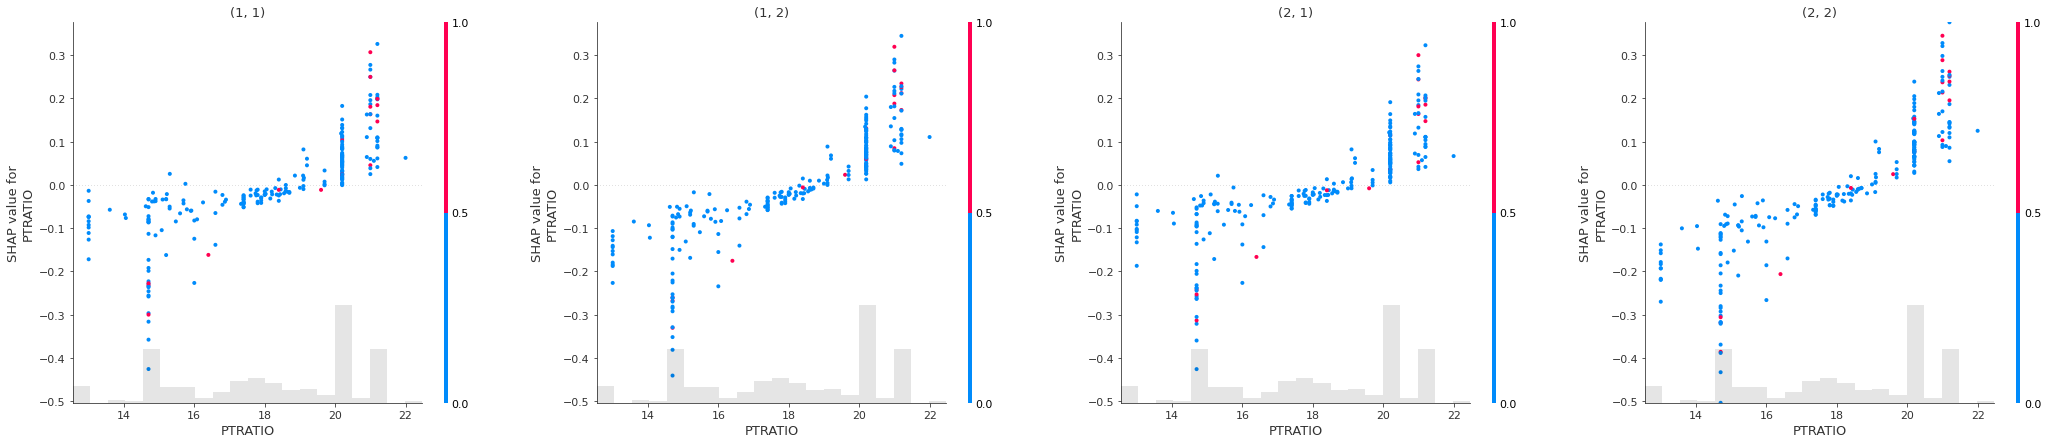

In [106]:
plot_next_feature()

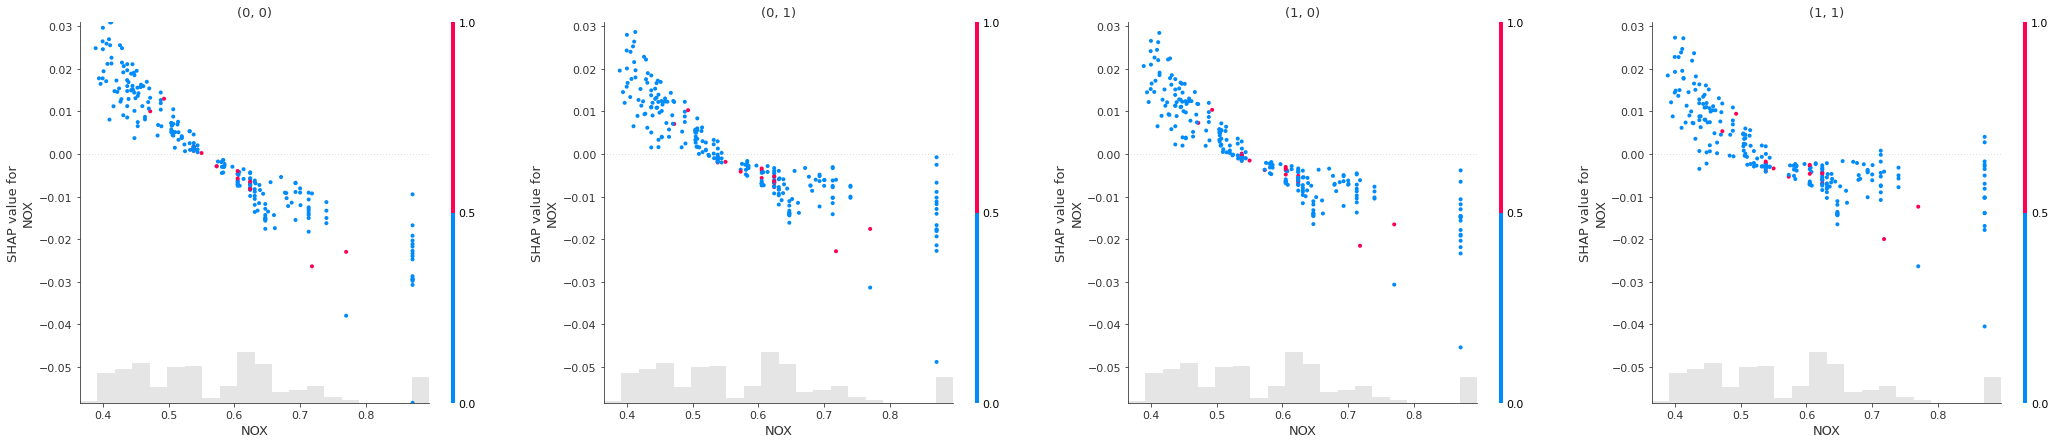

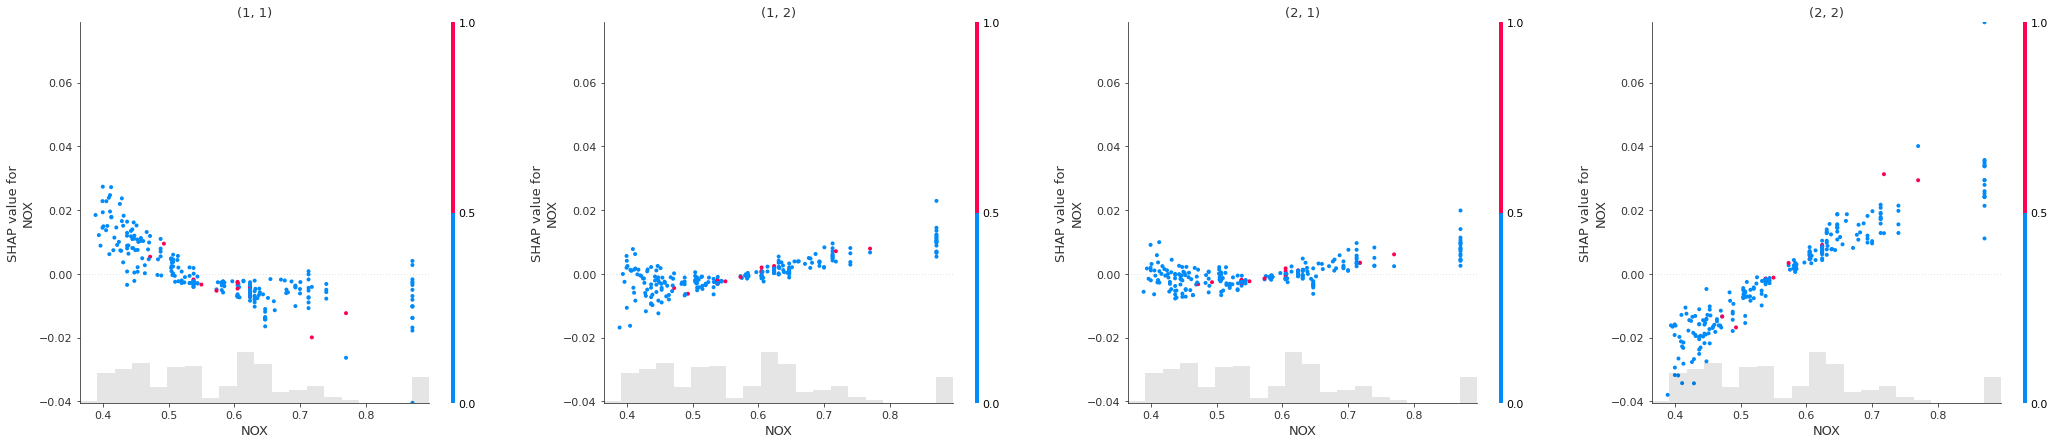

In [107]:
plot_next_feature()

# Local Explanations

## Clustering of $(0,1)$ SHAP Values

In [6]:
clustering = make_clustering(comparer, explanations.mclass_diff.log_odds, '(0, 1)', '(0, 0)', '(1, 1)')

node #490 (level 0)
(2, 2)    95
(0, 0)    76
(1, 1)    58
(0, 1)    13
(2, 1)     3
(1, 2)     1
dtype: int64


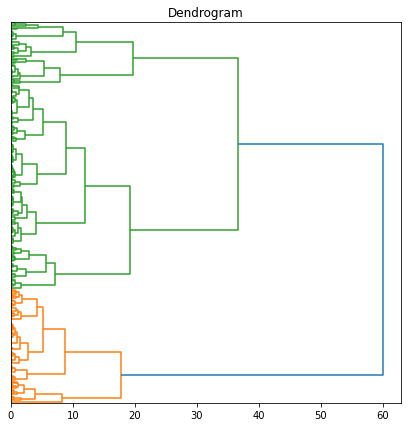

In [7]:
clustering.plot_dendrogram()

In [8]:
clustering.go_down()

node #486 (level 1)
(2, 2)    74
dtype: int64


In [9]:
clustering.get_next()

node #490 (level 0)
(2, 2)    95
(0, 0)    76
(1, 1)    58
(0, 1)    13
(2, 1)     3
(1, 2)     1
dtype: int64
node #489 (level 1)
(0, 0)    76
(1, 1)    58
(2, 2)    21
(0, 1)    13
(2, 1)     3
(1, 2)     1
dtype: int64


In [10]:
clustering.go_down()

node #487 (level 2)
(0, 0)    76
(1, 1)    42
(0, 1)    13
(2, 1)     1
dtype: int64


Cluster characteristics:
- $8.9 < LSTAT$
- $ZN ≤ 75$
- $2.1 < INDUS$
- $RM < 7.3$ (not relevant)
- $2 ≤ RAD$ (not relevant)
- $DIS < 8.0$ (not relevant)

Differences:
- $11.1 ≤ LSTAT < 18.8$
- $ZN=0$
- $8.1 < INDUS < 21.9$
- $CRIM < 3.9$
- $276 ≤ TAX$
- $RM < 6.4$
- $4 ≤ RAD$
- $DIS < 4.5$
- $1 ≤ AGE$

Counterfactuals:
- $LSTAT=19.2 \rightarrow (0,0)$
- $LSTAT=10.2 \rightarrow (1,1)$

In [11]:
for feature in global_feature_order:
    print(comparer.feature_names[feature])
    display(clustering.describe_feature(feature))

LSTAT


global   local-all  local-diff
count  246.000000  132.000000   13.000000
mean    11.736981   17.368099   15.570054
std      7.372550    5.428295    2.686952
min      1.763949    8.930000   11.100000
25%      5.008267   13.522389   13.510000
50%      9.950000   16.679814   17.066695
75%     17.091674   19.669258   17.310000
max     36.980000   36.980000   18.720000

ZN


global   local-all  local-diff
count  246.000000  132.000000        13.0
mean    12.841063    2.946970         0.0
std     25.552540   10.250351         0.0
min      0.000000    0.000000         0.0
25%      0.000000    0.000000         0.0
50%      0.000000    0.000000         0.0
75%     20.000000    0.000000         0.0
max    100.000000   75.000000         0.0

INDUS


global   local-all  local-diff
count  246.000000  132.000000   13.000000
mean    11.718208   15.300350   16.219231
std      7.290396    6.073803    6.003980
min      1.210000    2.180000    8.140000
25%      4.243588    8.455000    8.140000
50%      9.900000   18.100000   19.580000
75%     18.100000   19.580000   21.890000
max     25.650000   25.650000   21.890000

CRIM


global   local-all  local-diff
count  246.000000  132.000000   13.000000
mean     2.720010    3.886162    1.316509
std      6.388147    8.217986    1.073462
min      0.009060    0.013600    0.045600
25%      0.099321    0.274255    0.626837
50%      0.540032    1.241007    0.976170
75%      3.181873    4.852276    2.242360
max     73.534100   73.534100    3.836840

TAX


global   local-all  local-diff
count  246.000000  132.000000   13.000000
mean   403.132604  454.190692  394.384615
std    165.416533  163.211777  102.396727
min    188.000000  188.000000  276.000000
25%    273.000000  307.000000  307.000000
50%    362.186013  403.000000  403.000000
75%    461.000000  666.000000  437.000000
max    679.526743  679.526743  666.000000

RM


global   local-all  local-diff
count  246.000000  132.000000   13.000000
mean     6.511388    5.940515    5.886624
std      0.889747    0.494892    0.230000
min      3.561000    3.863000    5.614909
25%      5.882000    5.644087    5.695859
50%      6.315500    5.923168    5.854000
75%      7.134552    6.266802    6.020228
max      8.638029    7.225003    6.319000

RAD


global   local-all  local-diff
count  246.000000  132.000000   13.000000
mean     9.346908   10.994087    5.846154
std      8.493772    9.204465    5.474884
min      1.000000    2.000000    4.000000
25%      4.000000    4.000000    4.000000
50%      5.000000    5.000000    4.000000
75%      8.000000   24.000000    5.000000
max     24.000000   24.000000   24.000000

DIS


global   local-all  local-diff
count  246.000000  132.000000   13.000000
mean     3.501706    2.949451    2.840883
std      2.007156    1.608747    0.974075
min      1.137912    1.358000    1.788300
25%      1.967365    1.725646    2.100000
50%      2.866600    2.338527    2.388700
75%      4.621654    3.775059    3.820836
max     10.710300    7.980900    4.441690

AGE


global   local-all  local-diff
count  246.000000  132.000000   13.000000
mean     1.304878    1.643939    1.923077
std      0.813494    0.619438    0.277350
min      0.000000    0.000000    1.000000
25%      1.000000    1.000000    2.000000
50%      2.000000    2.000000    2.000000
75%      2.000000    2.000000    2.000000
max      2.000000    2.000000    2.000000

PTRATIO


global   local-all  local-diff
count  246.000000  132.000000   13.000000
mean    18.125578   19.005839   19.192308
std      2.524334    2.311809    2.865735
min     13.000000   13.000000   14.700000
25%     15.707491   17.875000   16.400000
50%     18.571912   20.200000   21.000000
75%     20.200000   20.900000   21.200000
max     22.000000   21.200000   21.200000

NOX


global   local-all  local-diff
count  246.000000  132.000000   13.000000
mean     0.572581    0.623291    0.598692
std      0.125307    0.124747    0.063987
min      0.389000    0.405000    0.538000
25%      0.462112    0.538000    0.538000
50%      0.544000    0.624000    0.605000
75%      0.638740    0.700000    0.624000
max      0.871000    0.871000    0.770000

In [14]:
clustering.test(LSTAT=8.9)

before  after
(0, 1)    13.0    NaN
(1, 1)     NaN   12.0
(2, 2)     NaN    1.0

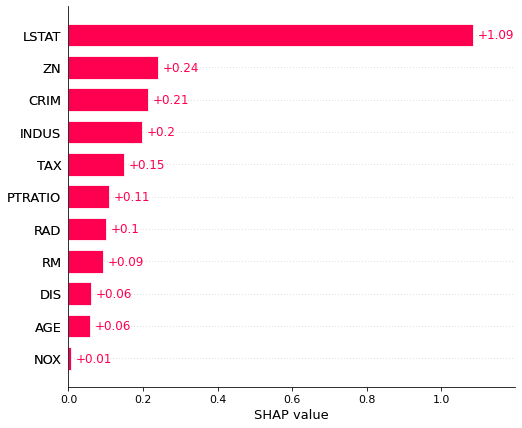

In [15]:
feature_order, feature_importances = calc_feature_order(clustering.shap_values[:, :, clustering.classes])
plot_feature_importance_bar(feature_importances)

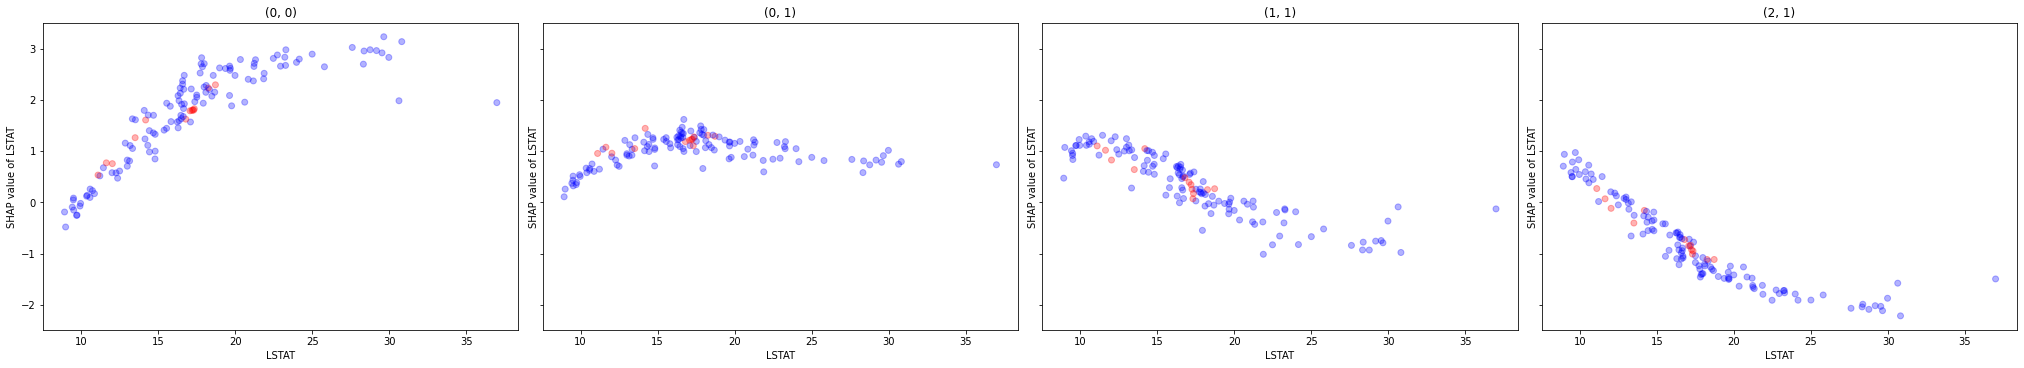

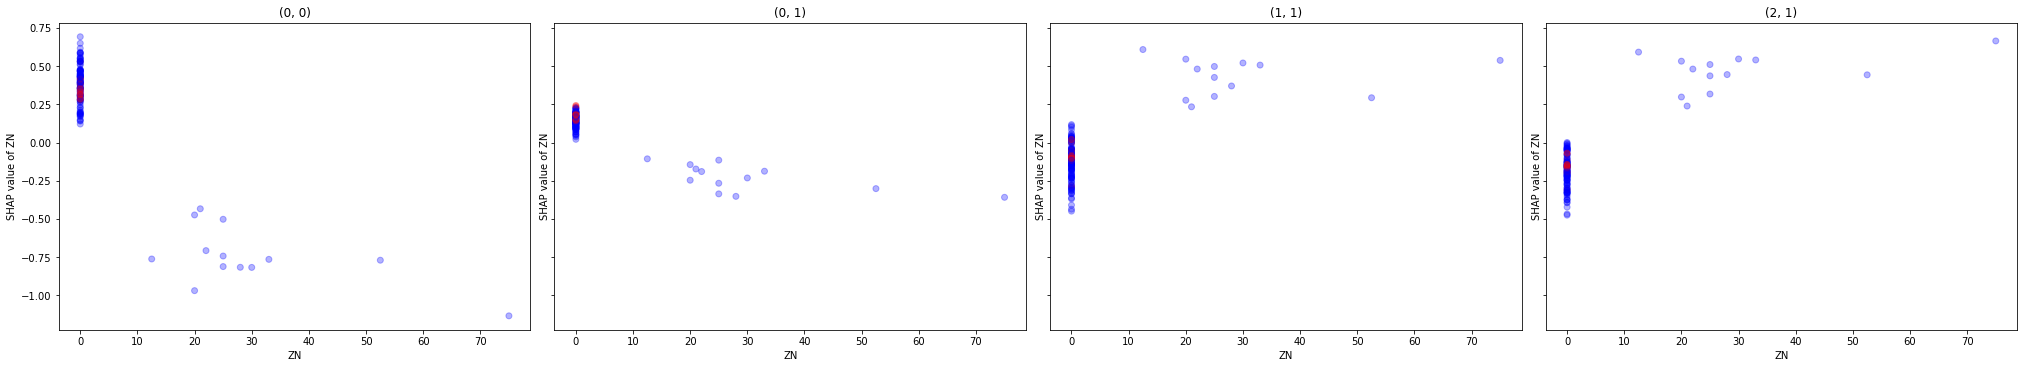

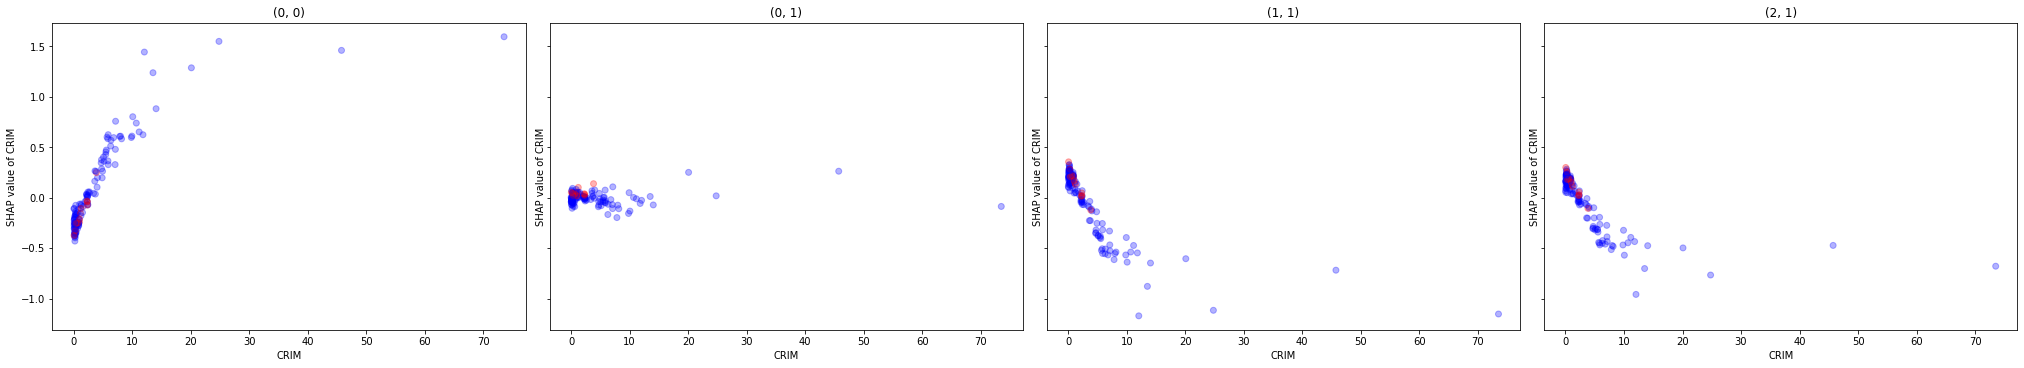

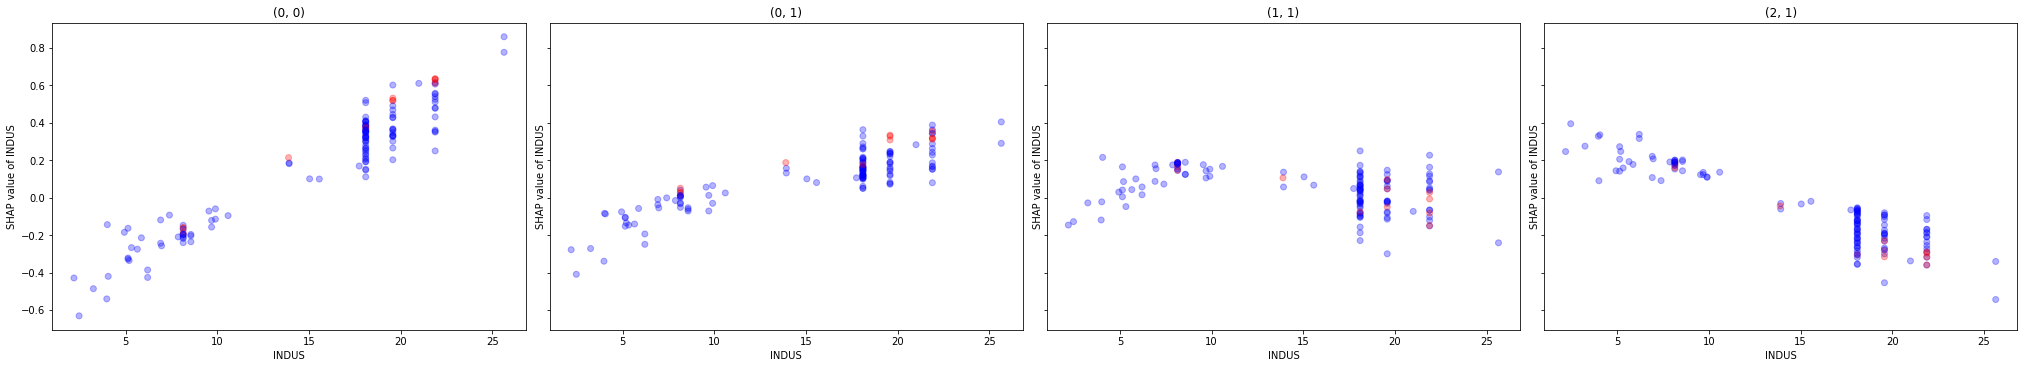

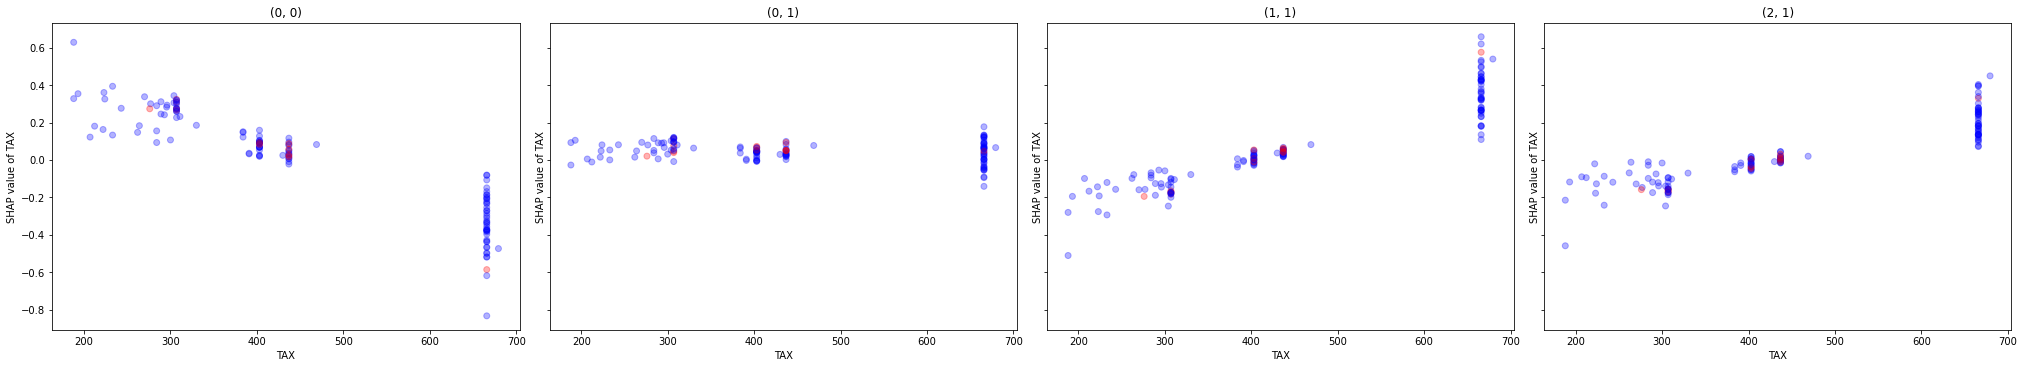

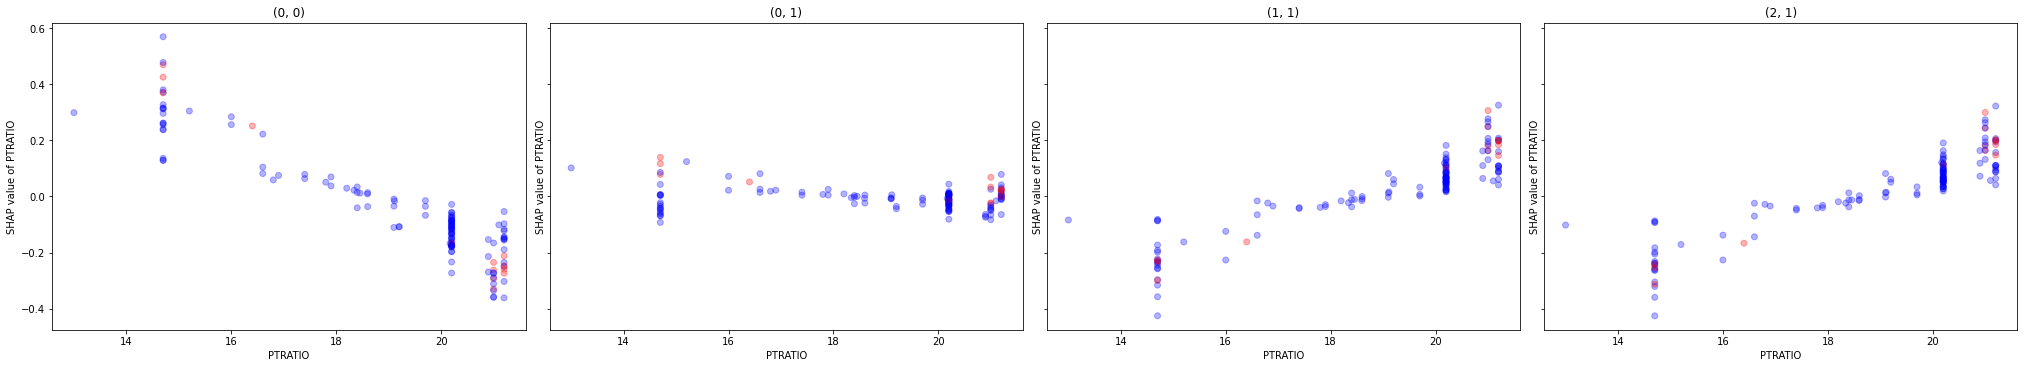

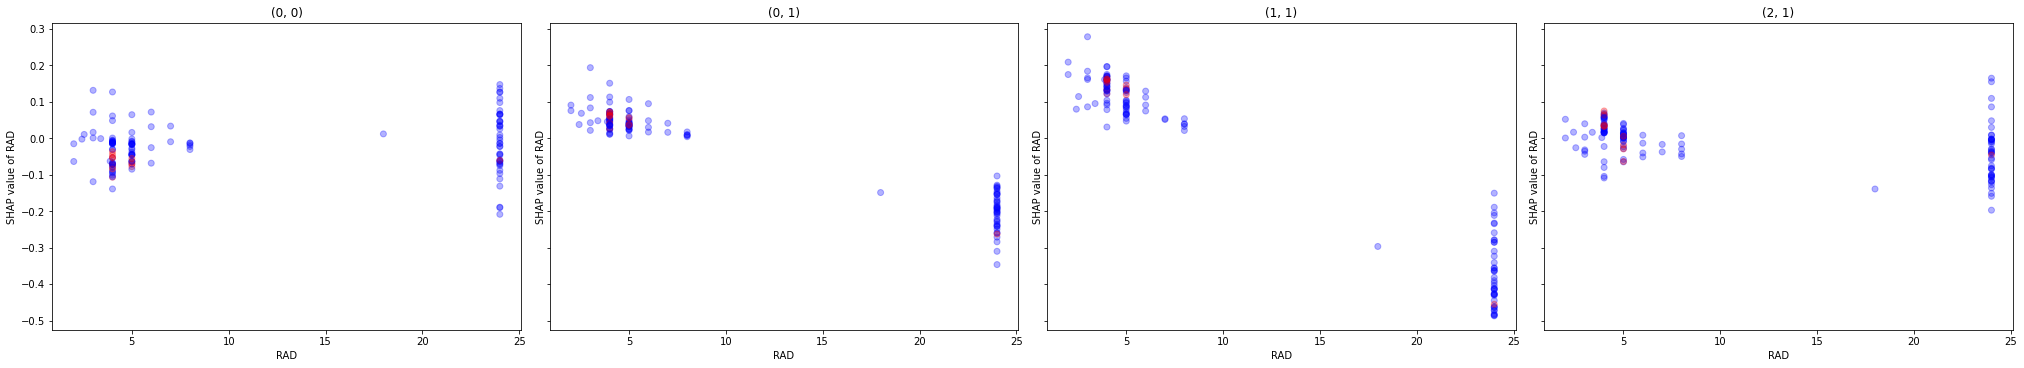

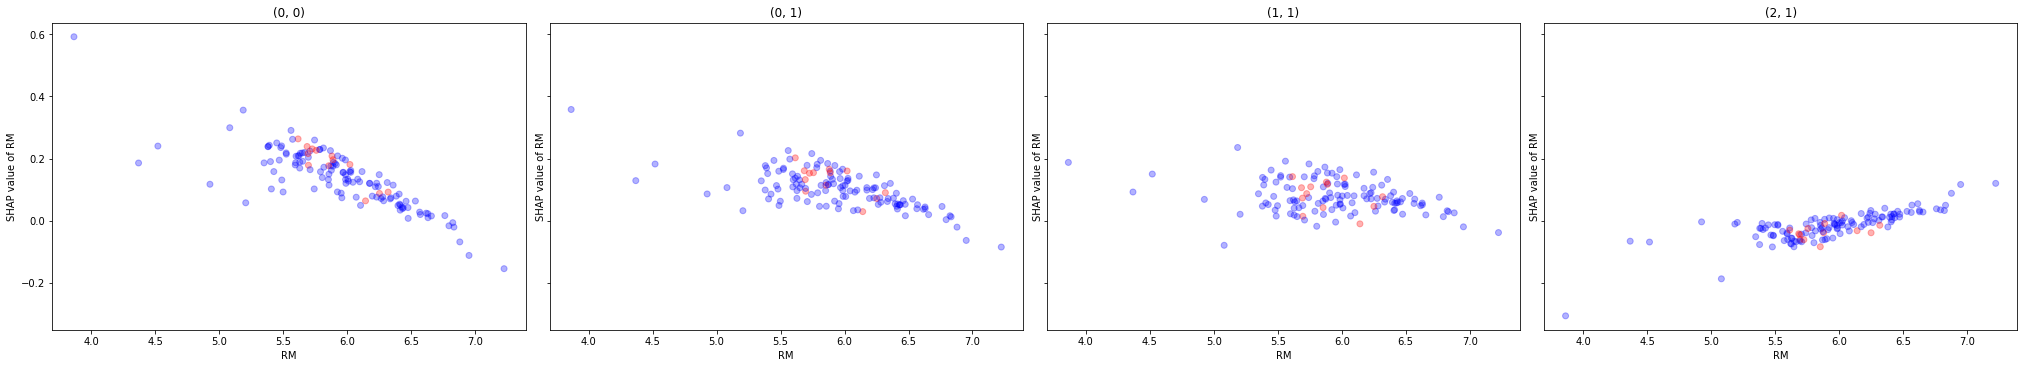

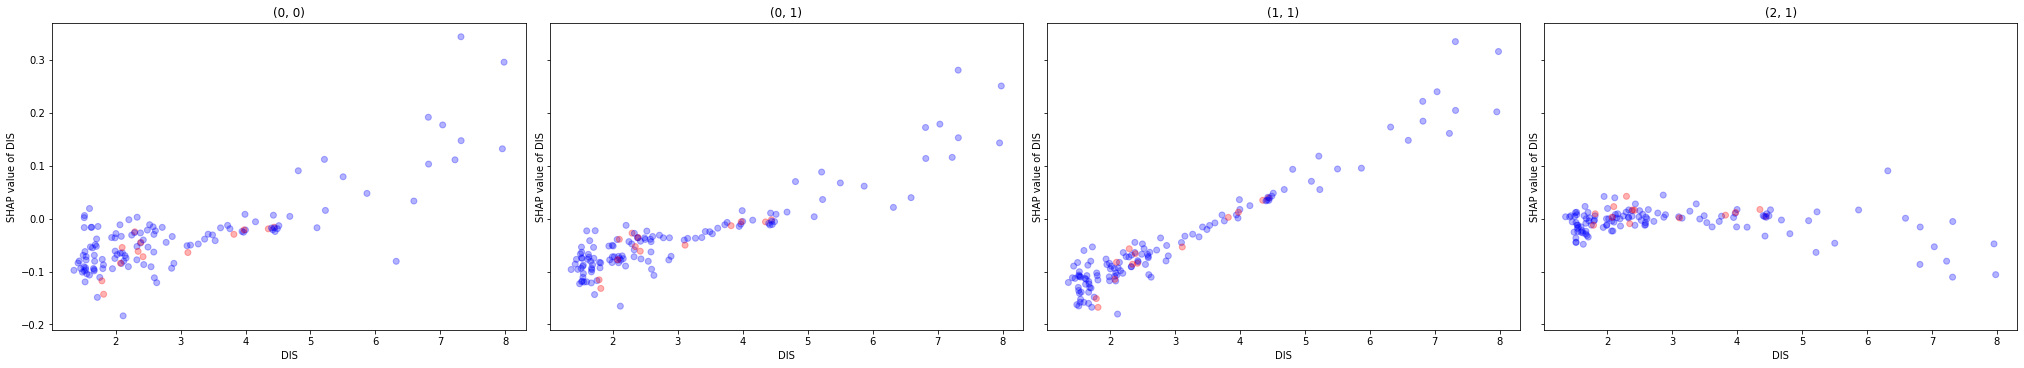

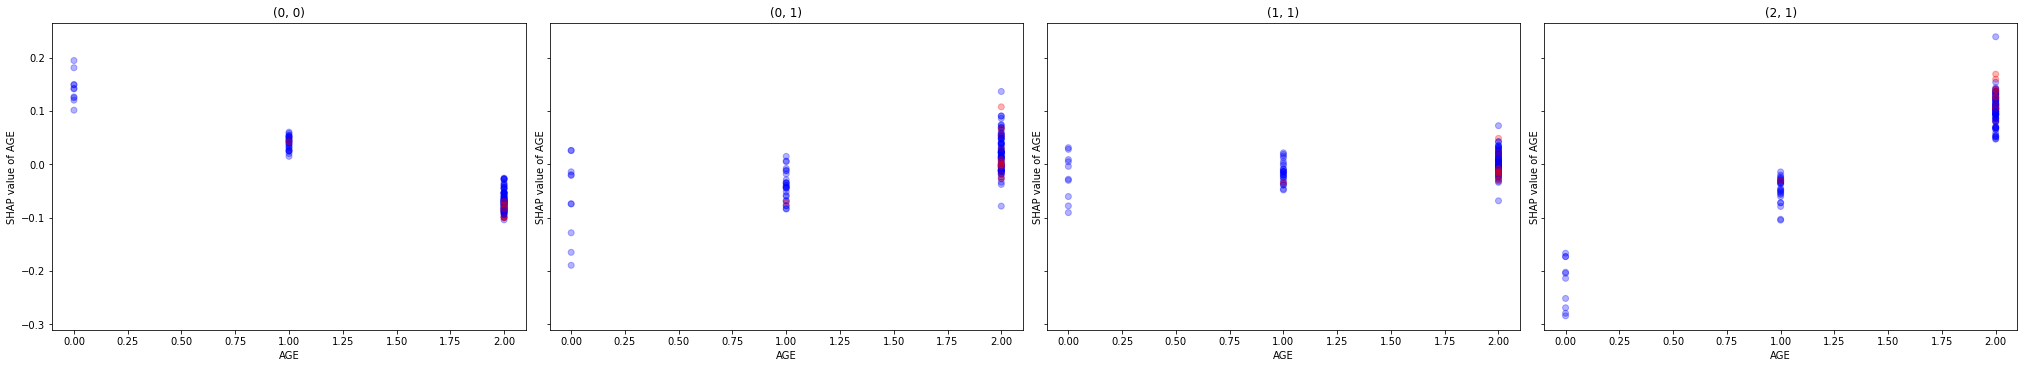

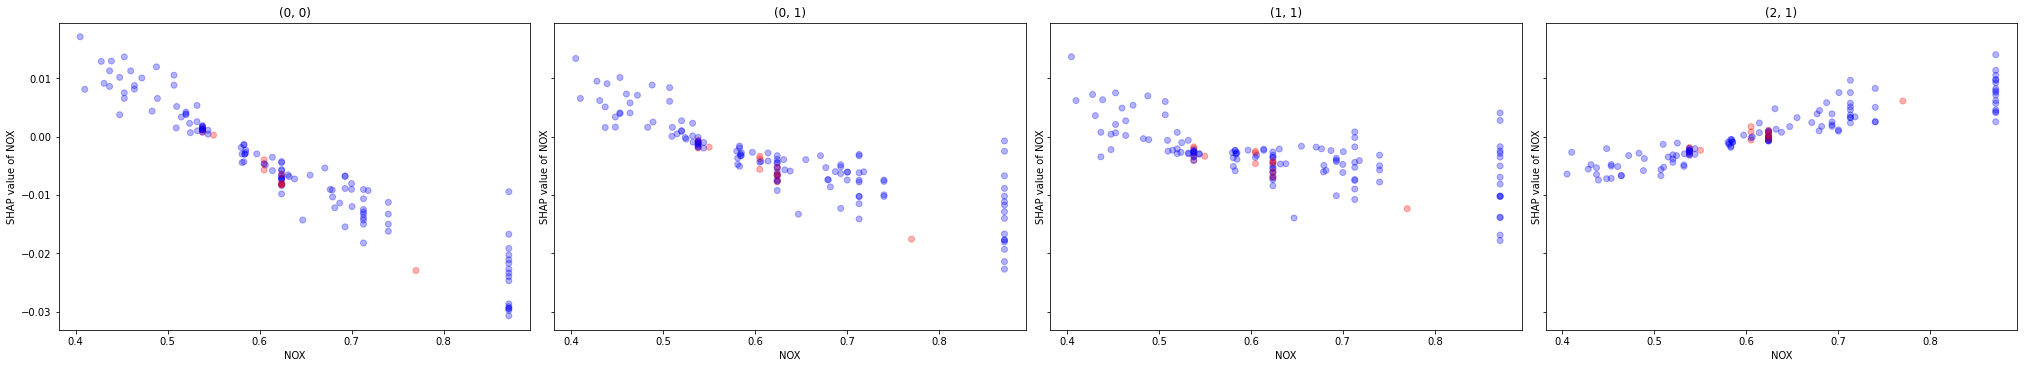

In [16]:
for feature in feature_order:
    clustering.plot_feature(feature, alpha=0.3)

In [26]:
clustering.test(LSTAT=19.2)

before  after
(0, 0)     NaN   13.0
(0, 1)    13.0    NaN

In [37]:
clustering.test(LSTAT=10.2)

before  after
(0, 1)    13.0    NaN
(1, 1)     NaN   13.0

## Clustering of $(1,2)$ SHAP Values

In [40]:
clustering = make_clustering(comparer, explanations.mclass_diff.log_odds, '(1, 2)', '(1, 1)', '(2, 2)')

node #490 (level 0)
(2, 2)    95
(0, 0)    76
(1, 1)    58
(0, 1)    13
(2, 1)     3
(1, 2)     1
dtype: int64


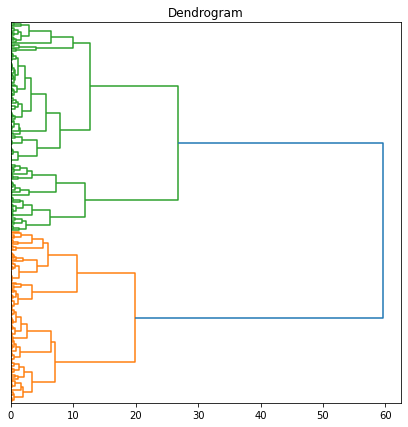

In [41]:
clustering.plot_dendrogram()

In [42]:
clustering.go_down()

node #488 (level 1)
(0, 0)    76
(1, 1)    22
(0, 1)    13
dtype: int64


In [43]:
clustering.get_next()

node #490 (level 0)
(2, 2)    95
(0, 0)    76
(1, 1)    58
(0, 1)    13
(2, 1)     3
(1, 2)     1
dtype: int64
node #489 (level 1)
(2, 2)    95
(1, 1)    36
(2, 1)     3
(1, 2)     1
dtype: int64


Cluster:
- $LSTAT ≤ 13$
- $INDUS < 19.6$
- $CRIM < 9.3$
- $193 ≤ TAX$

Differences: $LSTAT=6.2, ZN=0, INDUS=7.4, RAD=6.3, TAX=287, DIS=5.4, RM=6.3, AGE=0$

Counterfactuals:
- $LSTAT=6.3 \rightarrow (1,1)$
- $LSTAT=4 \rightarrow (2,2)$

In [51]:
clustering.test(LSTAT=13)

before  after
(1, 1)     NaN    1.0
(1, 2)     1.0    NaN

In [44]:
for feature in global_feature_order:
    print(comparer.feature_names[feature])
    display(clustering.describe_feature(feature))

LSTAT


global   local-all  local-diff
count  246.000000  135.000000        1.00
mean    11.736981    6.034002        6.15
std      7.372550    2.649901         NaN
min      1.763949    1.763949        6.15
25%      5.008267    3.763708        6.15
50%      9.950000    5.284880        6.15
75%     17.091674    7.877776        6.15
max     36.980000   13.000000        6.15

ZN


global   local-all  local-diff
count  246.000000  135.000000         1.0
mean    12.841063   21.847418         0.0
std     25.552540   30.819650         NaN
min      0.000000    0.000000         0.0
25%      0.000000    0.000000         0.0
50%      0.000000    0.000000         0.0
75%     20.000000   29.290053         0.0
max    100.000000  100.000000         0.0

INDUS


global   local-all  local-diff
count  246.000000  135.000000        1.00
mean    11.718208    7.767896        7.38
std      7.290396    6.165247         NaN
min      1.210000    1.210000        7.38
25%      4.243588    3.032571        7.38
50%      9.900000    5.320000        7.38
75%     18.100000   11.930000        7.38
max     25.650000   19.580000        7.38

CRIM


global   local-all  local-diff
count  246.000000  135.000000     1.00000
mean     2.720010    1.287289     0.30347
std      6.388147    2.482328         NaN
min      0.009060    0.009060     0.30347
25%      0.099321    0.054880     0.30347
50%      0.540032    0.159360     0.30347
75%      3.181873    0.625142     0.30347
max     73.534100    9.232300     0.30347

TAX


global   local-all  local-diff
count  246.000000  135.000000         1.0
mean   403.132604  345.014587       287.0
std    165.416533  146.857011         NaN
min    188.000000  193.000000       287.0
25%    273.000000  245.374270       287.0
50%    362.186013  293.000000       287.0
75%    461.000000  398.000000       287.0
max    679.526743  666.000000       287.0

RM


global   local-all  local-diff
count  246.000000  135.000000       1.000
mean     6.511388    7.038970       6.312
std      0.889747    0.799154         NaN
min      3.561000    3.561000       6.312
25%      5.882000    6.390000       6.312
50%      6.315500    7.045824       6.312
75%      7.134552    7.668430       6.312
max      8.638029    8.638029       6.312

RAD


global   local-all  local-diff
count  246.000000  135.000000         1.0
mean     9.346908    7.511114         5.0
std      8.493772    7.101807         NaN
min      1.000000    1.000000         5.0
25%      4.000000    4.000000         5.0
50%      5.000000    5.000000         5.0
75%      8.000000    7.500000         5.0
max     24.000000   24.000000         5.0

DIS


global   local-all  local-diff
count  246.000000  135.000000      1.0000
mean     3.501706    4.128834      5.4159
std      2.007156    2.144014         NaN
min      1.137912    1.137912      5.4159
25%      1.967365    2.410900      5.4159
50%      2.866600    3.615000      5.4159
75%      4.621654    5.522310      5.4159
max     10.710300   10.710300      5.4159

AGE


global   local-all  local-diff
count  246.000000  135.000000         1.0
mean     1.304878    0.896296         0.0
std      0.813494    0.803668         NaN
min      0.000000    0.000000         0.0
25%      1.000000    0.000000         0.0
50%      2.000000    1.000000         0.0
75%      2.000000    2.000000         0.0
max      2.000000    2.000000         0.0

PTRATIO


global   local-all  local-diff
count  246.000000  135.000000         1.0
mean    18.125578   17.299716        19.6
std      2.524334    2.351445         NaN
min     13.000000   13.000000        19.6
25%     15.707491   15.260161        19.6
50%     18.571912   17.400000        19.6
75%     20.200000   19.095215        19.6
max     22.000000   22.000000        19.6

NOX


global   local-all  local-diff
count  246.000000  135.000000       1.000
mean     0.572581    0.513059       0.493
std      0.125307    0.092454         NaN
min      0.389000    0.389000       0.493
25%      0.462112    0.438000       0.493
50%      0.544000    0.493000       0.493
75%      0.638740    0.595000       0.493
max      0.871000    0.871000       0.493

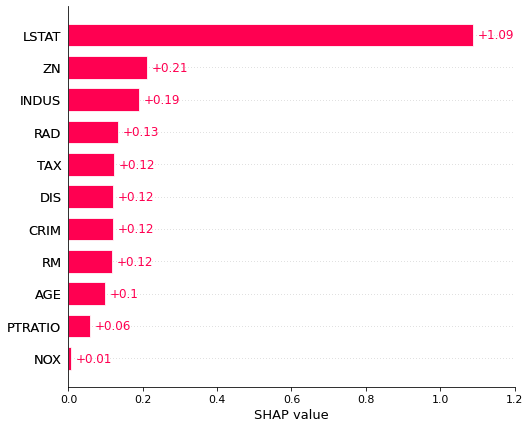

In [45]:
feature_order, feature_importances = calc_feature_order(clustering.shap_values[:, :, clustering.classes])
plot_feature_importance_bar(feature_importances)

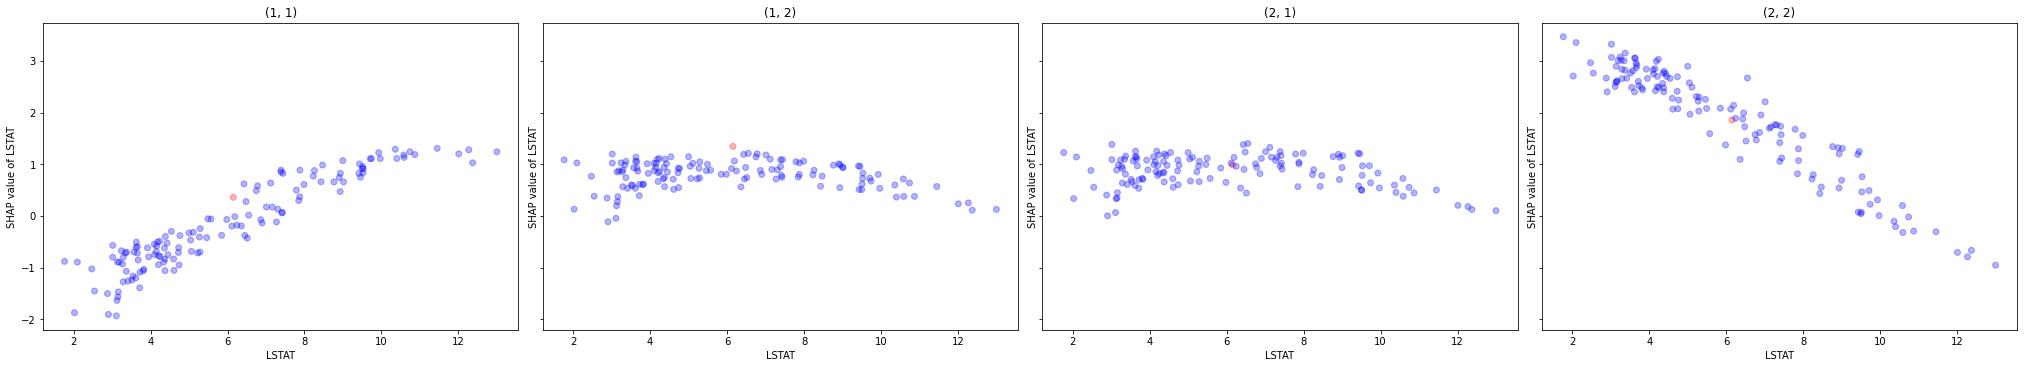

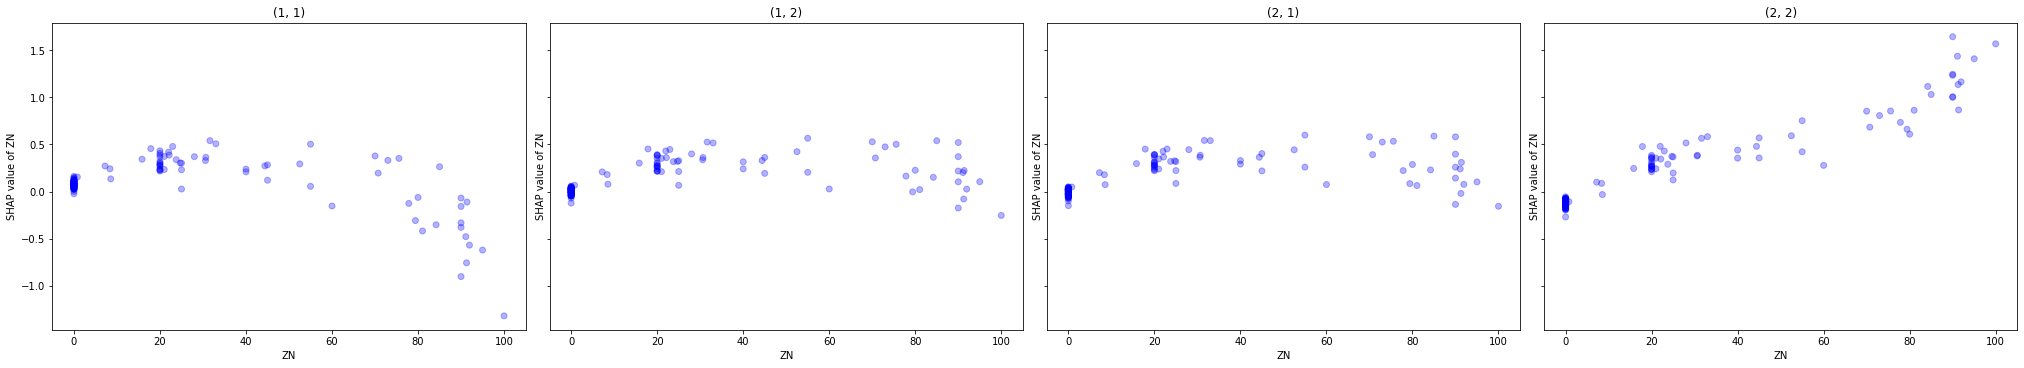

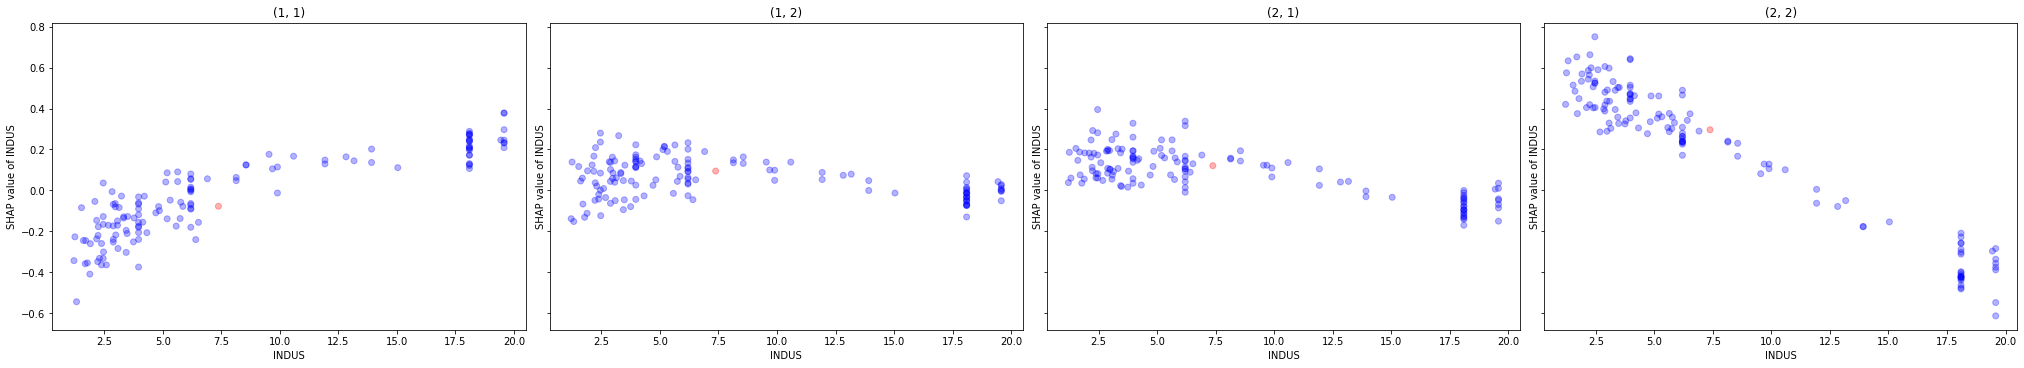

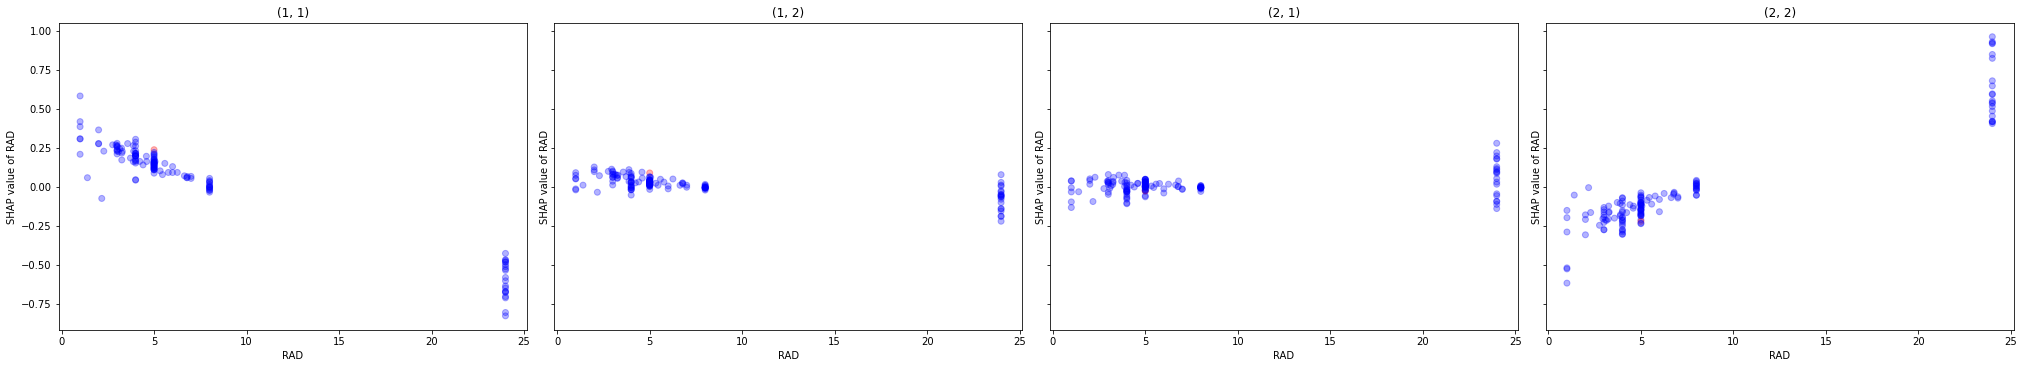

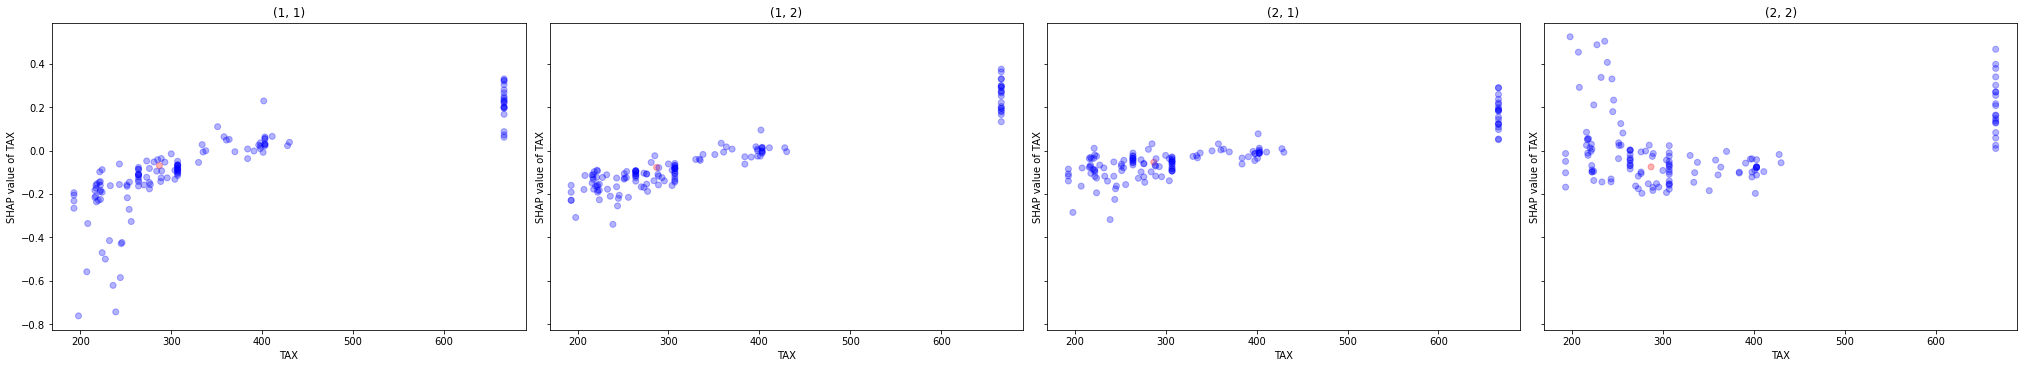

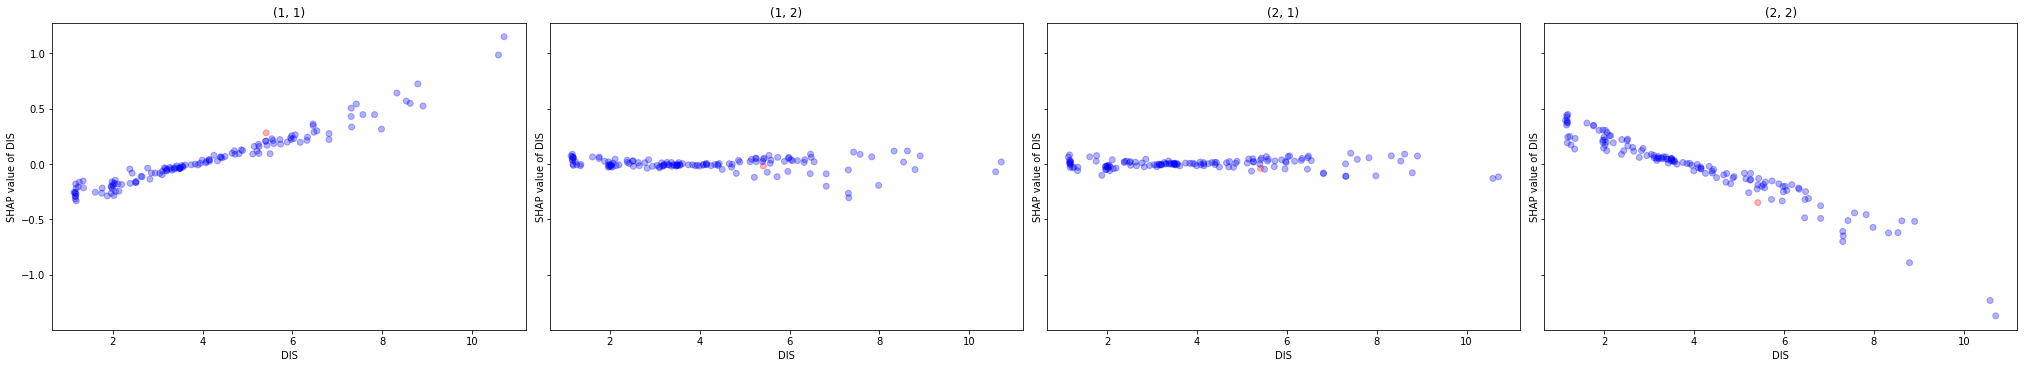

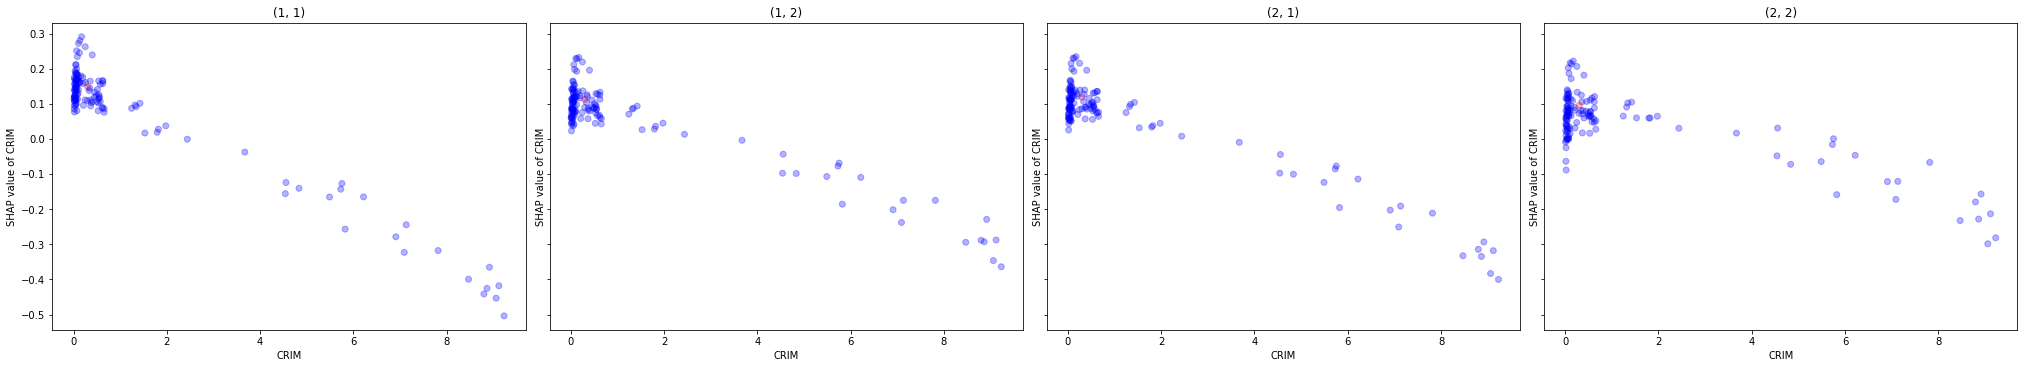

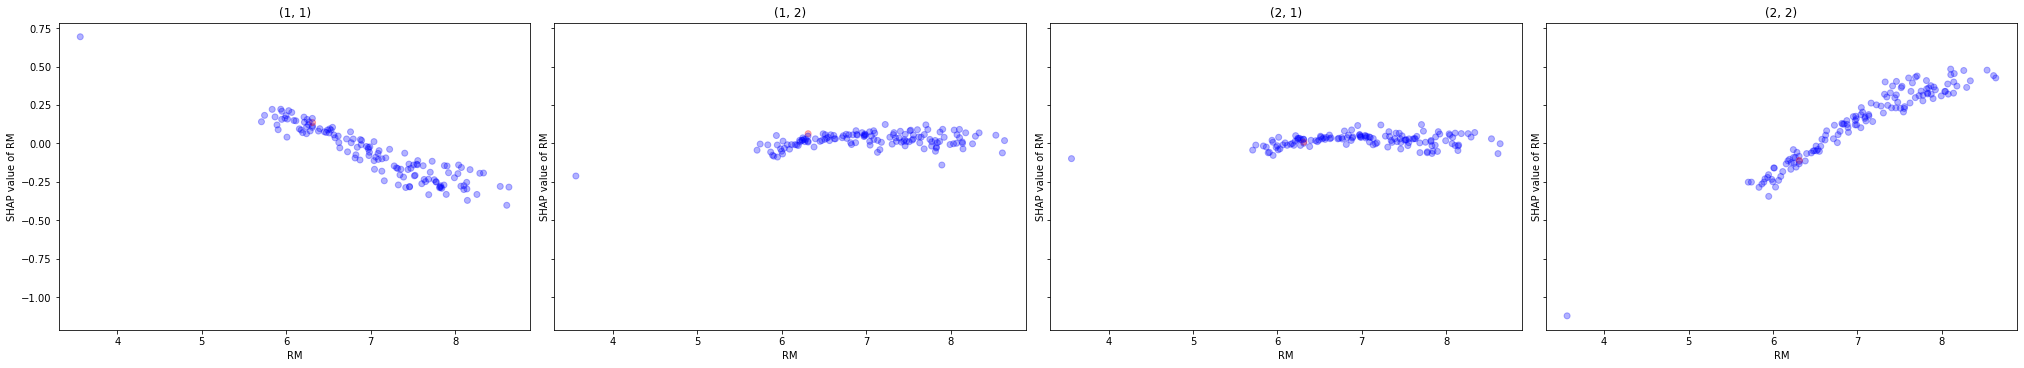

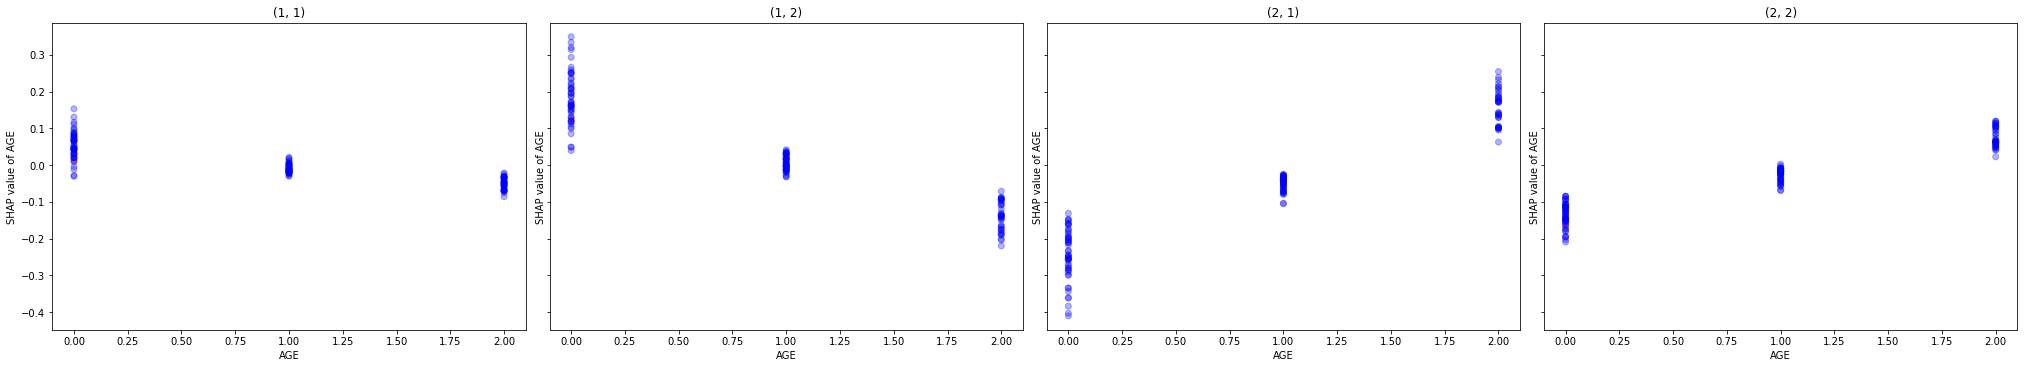

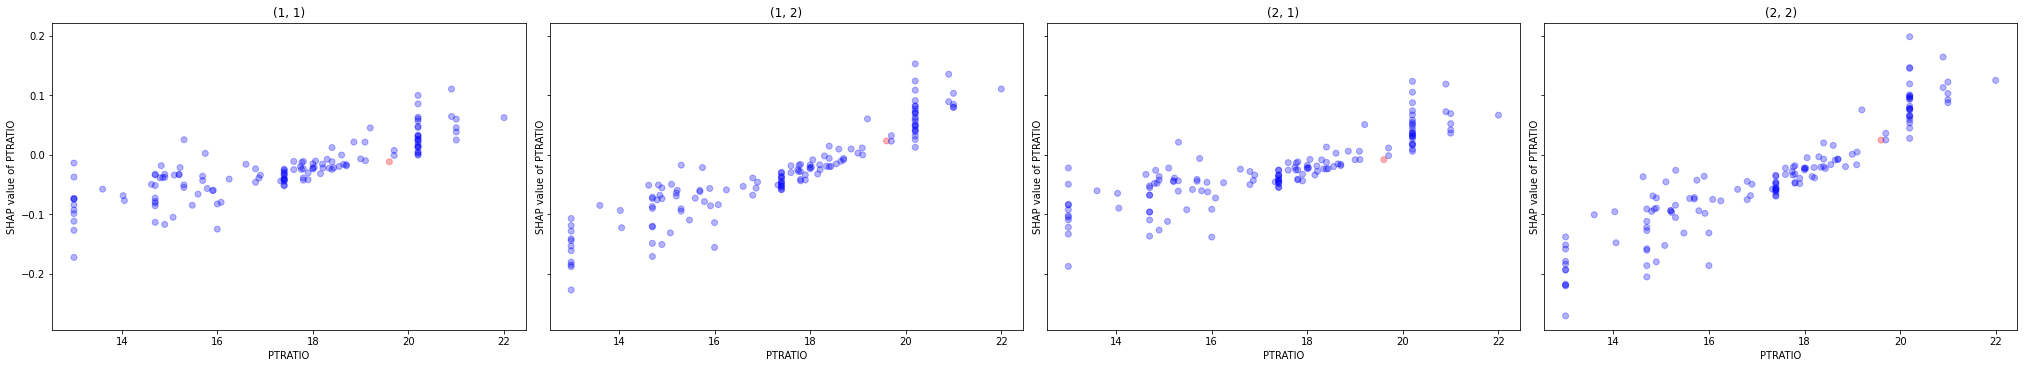

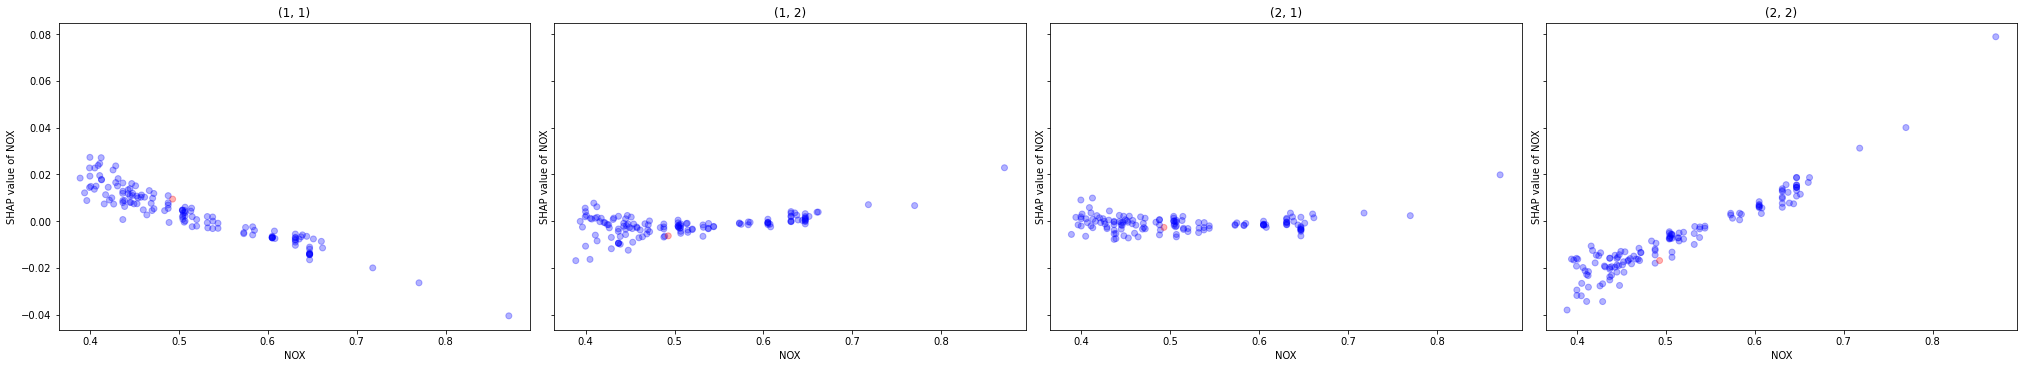

In [46]:
for feature in feature_order:
    clustering.plot_feature(feature, alpha=0.3)

In [50]:
clustering.test(LSTAT=4)

before  after
(1, 2)     1.0    NaN
(2, 2)     NaN    1.0

In [57]:
clustering.test(LSTAT=6.3)

before  after
(1, 1)     NaN    1.0
(1, 2)     1.0    NaN

## Clustering of $(2,1)$ SHAP Values

In [58]:
clustering = make_clustering(comparer, explanations.mclass_diff.log_odds, '(2, 1)', '(1, 1)', '(2, 2)')

node #490 (level 0)
(2, 2)    95
(0, 0)    76
(1, 1)    58
(0, 1)    13
(2, 1)     3
(1, 2)     1
dtype: int64


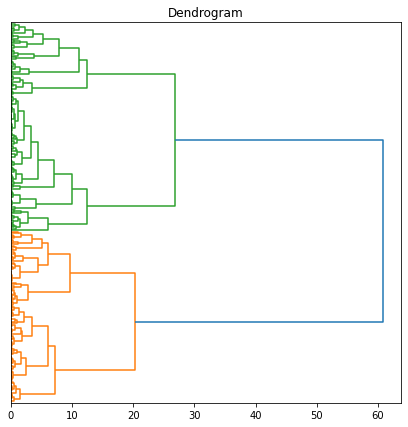

In [59]:
clustering.plot_dendrogram()

In [60]:
clustering.go_down()

node #488 (level 1)
(0, 0)    76
(1, 1)    22
(0, 1)    13
dtype: int64


In [61]:
clustering.get_next()

node #490 (level 0)
(2, 2)    95
(0, 0)    76
(1, 1)    58
(0, 1)    13
(2, 1)     3
(1, 2)     1
dtype: int64
node #489 (level 1)
(2, 2)    95
(1, 1)    36
(2, 1)     3
(1, 2)     1
dtype: int64


Cluster:
- $LSTAT ≤ 13$
- $INDUS < 19.6$
- $CRIM < 9.3$
- $193 ≤ TAX$

Differences:
- $6.4 < LSTAT < 9.0$
- $ZN ≤ 33$
- $CRIM < 4.6$ (not relevant)
- $222 ≤ TAX$
- $RM < 6.8$
- $1.6 < DIS < 3.4$
- $1 ≤ AGE$
- $18.4 ≤ PTRATIO ≤ 12$ (not relevant)

Counterfactuals:
- $LSTAT=9.1 \rightarrow (1,1)$
- $LSTAT=5.9 \rightarrow (2,2)$

In [51]:
clustering.test(LSTAT=13)

before  after
(1, 1)     NaN    1.0
(1, 2)     1.0    NaN

In [62]:
for feature in global_feature_order:
    print(comparer.feature_names[feature])
    display(clustering.describe_feature(feature))

LSTAT


global   local-all  local-diff
count  246.000000  135.000000    3.000000
mean    11.736981    6.034002    7.510000
std      7.372550    2.649901    1.270708
min      1.763949    1.763949    6.480000
25%      5.008267    3.763708    6.800000
50%      9.950000    5.284880    7.120000
75%     17.091674    7.877776    8.025000
max     36.980000   13.000000    8.930000

ZN


global   local-all  local-diff
count  246.000000  135.000000    3.000000
mean    12.841063   21.847418   11.000000
std     25.552540   30.819650   19.052559
min      0.000000    0.000000    0.000000
25%      0.000000    0.000000    0.000000
50%      0.000000    0.000000    0.000000
75%     20.000000   29.290053   16.500000
max    100.000000  100.000000   33.000000

INDUS


global   local-all  local-diff
count  246.000000  135.000000    3.000000
mean    11.718208    7.767896   10.736667
std      7.290396    6.165247    8.026807
min      1.210000    1.210000    2.180000
25%      4.243588    3.032571    7.055000
50%      9.900000    5.320000   11.930000
75%     18.100000   11.930000   15.015000
max     25.650000   19.580000   18.100000

CRIM


global   local-all  local-diff
count  246.000000  135.000000    3.000000
mean     2.720010    1.287289    1.573417
std      6.388147    2.482328    2.583026
min      0.009060    0.009060    0.054790
25%      0.099321    0.054880    0.082190
50%      0.540032    0.159360    0.109590
75%      3.181873    0.625142    2.332730
max     73.534100    9.232300    4.555870

TAX


global   local-all  local-diff
count  246.000000  135.000000     3.00000
mean   403.132604  345.014587   387.00000
std    165.416533  146.857011   242.96296
min    188.000000  193.000000   222.00000
25%    273.000000  245.374270   247.50000
50%    362.186013  293.000000   273.00000
75%    461.000000  398.000000   469.50000
max    679.526743  666.000000   666.00000

RM


global   local-all  local-diff
count  246.000000  135.000000     3.00000
mean     6.511388    7.038970     5.65700
std      0.889747    0.799154     1.81737
min      3.561000    3.561000     3.56100
25%      5.882000    6.390000     5.08850
50%      6.315500    7.045824     6.61600
75%      7.134552    7.668430     6.70500
max      8.638029    8.638029     6.79400

RAD


global   local-all  local-diff
count  246.000000  135.000000    3.000000
mean     9.346908    7.511114   10.666667
std      8.493772    7.101807   11.930353
min      1.000000    1.000000    1.000000
25%      4.000000    4.000000    4.000000
50%      5.000000    5.000000    7.000000
75%      8.000000    7.500000   15.500000
max     24.000000   24.000000   24.000000

DIS


global   local-all  local-diff
count  246.000000  135.000000    3.000000
mean     3.501706    4.128834    2.457367
std      2.007156    2.144014    0.880399
min      1.137912    1.137912    1.613200
25%      1.967365    2.410900    2.001050
50%      2.866600    3.615000    2.388900
75%      4.621654    5.522310    2.879450
max     10.710300   10.710300    3.370000

AGE


global   local-all  local-diff
count  246.000000  135.000000    3.000000
mean     1.304878    0.896296    1.666667
std      0.813494    0.803668    0.577350
min      0.000000    0.000000    1.000000
25%      1.000000    0.000000    1.500000
50%      2.000000    1.000000    2.000000
75%      2.000000    2.000000    2.000000
max      2.000000    2.000000    2.000000

PTRATIO


global   local-all  local-diff
count  246.000000  135.000000    3.000000
mean    18.125578   17.299716   19.866667
std      2.524334    2.351445    1.331666
min     13.000000   13.000000   18.400000
25%     15.707491   15.260161   19.300000
50%     18.571912   17.400000   20.200000
75%     20.200000   19.095215   20.600000
max     22.000000   22.000000   21.000000

NOX


global   local-all  local-diff
count  246.000000  135.000000    3.000000
mean     0.572581    0.513059    0.587667
std      0.125307    0.092454    0.123654
min      0.389000    0.389000    0.472000
25%      0.462112    0.438000    0.522500
50%      0.544000    0.493000    0.573000
75%      0.638740    0.595000    0.645500
max      0.871000    0.871000    0.718000

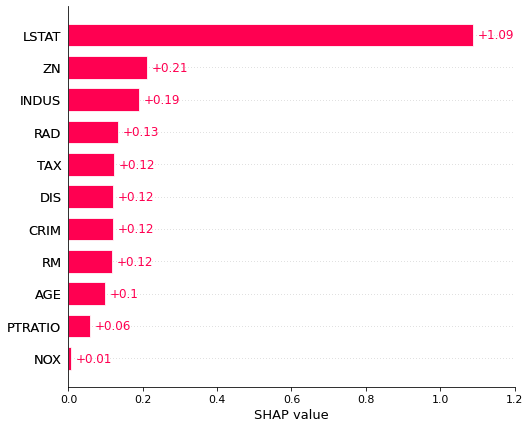

In [63]:
feature_order, feature_importances = calc_feature_order(clustering.shap_values[:, :, clustering.classes])
plot_feature_importance_bar(feature_importances)

In [69]:
clustering.test(LSTAT=5.9)

before  after
(2, 1)     3.0    NaN
(2, 2)     NaN    3.0

In [74]:
clustering.test(LSTAT=9.1)

before  after
(1, 1)     NaN    3.0
(2, 1)     3.0    NaN

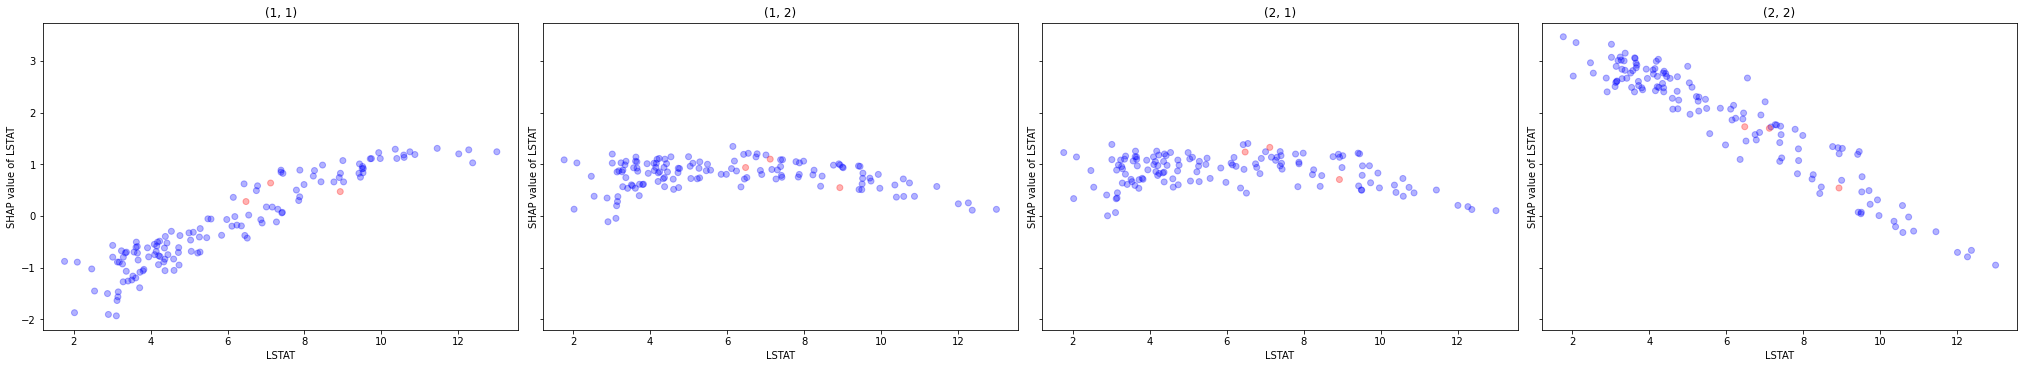

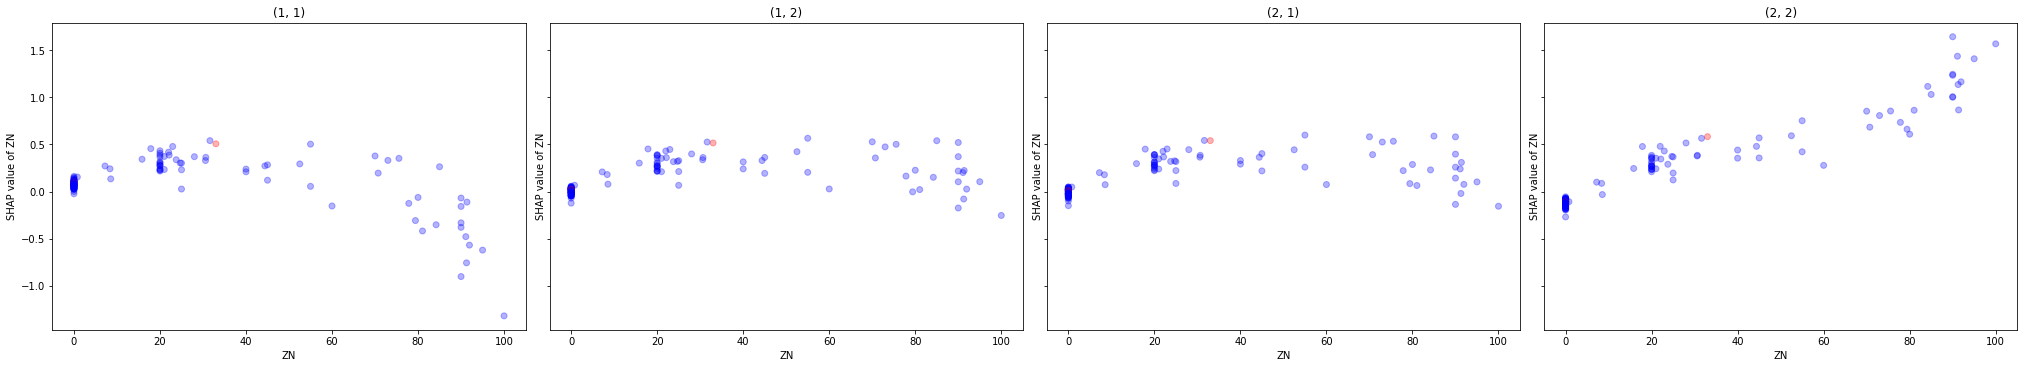

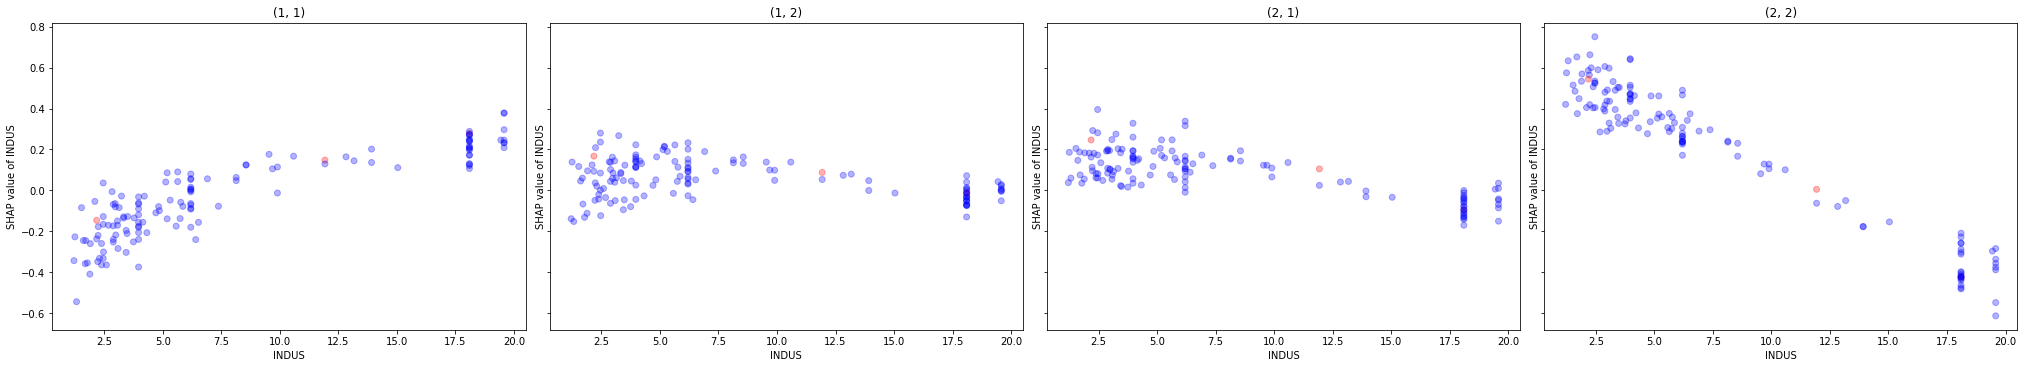

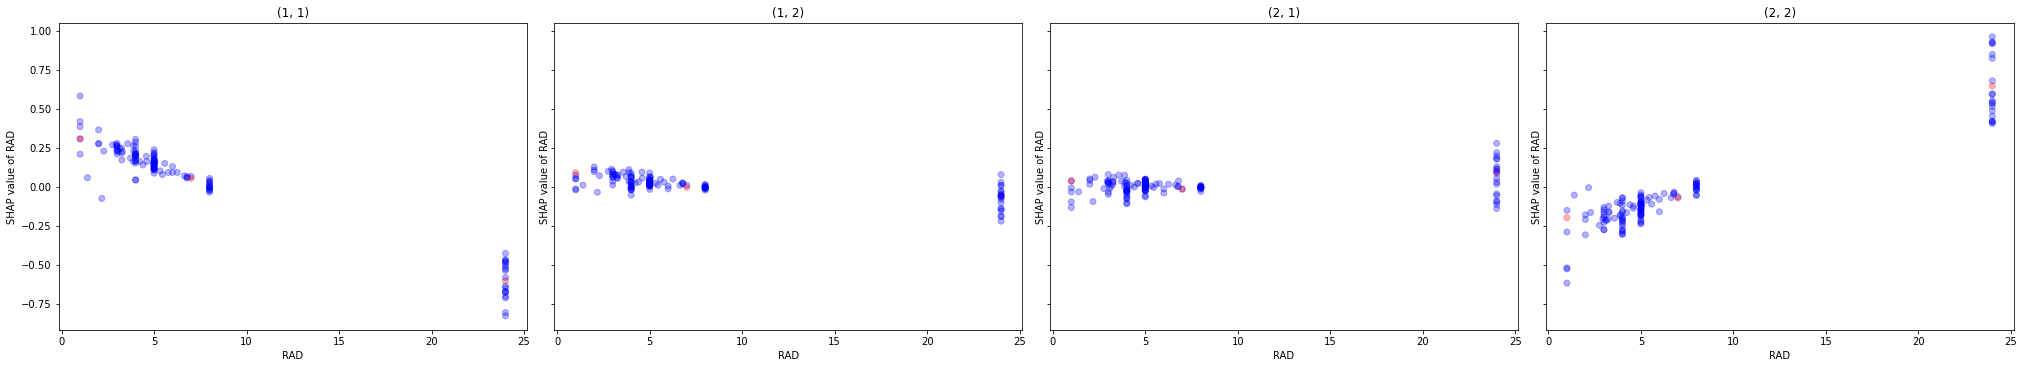

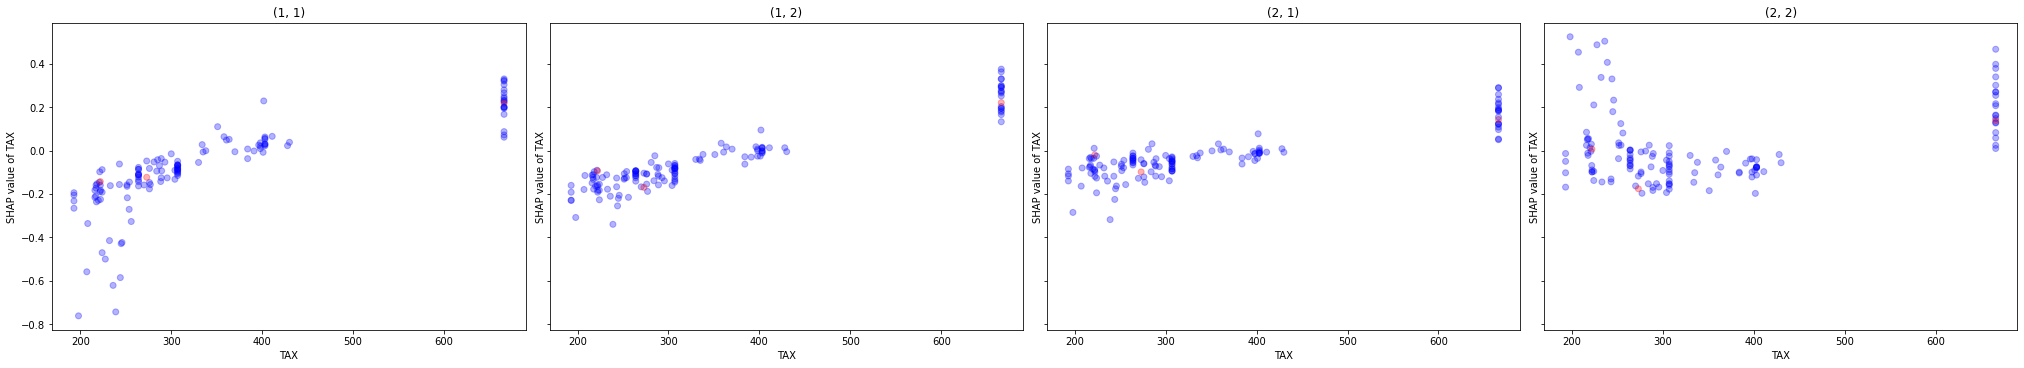

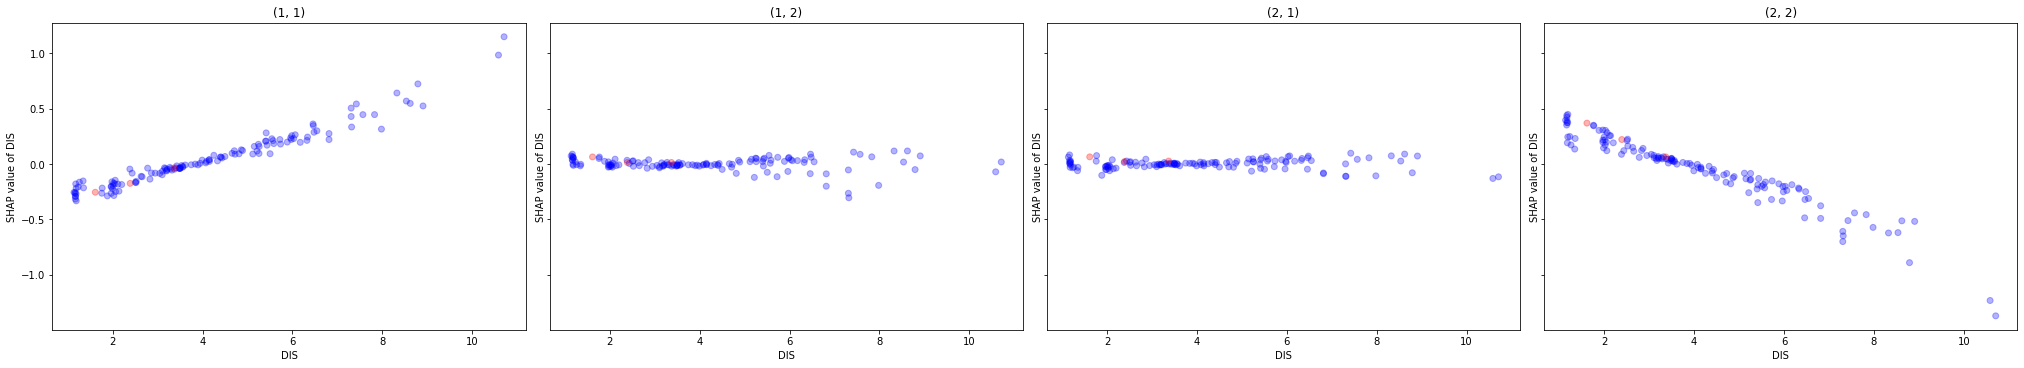

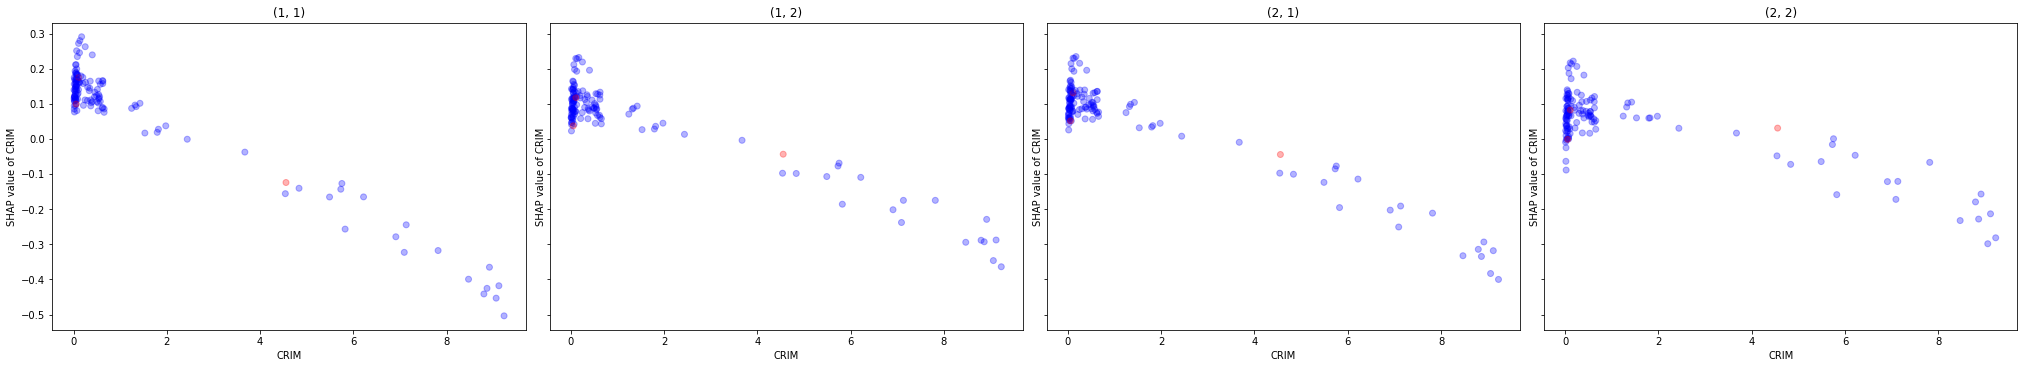

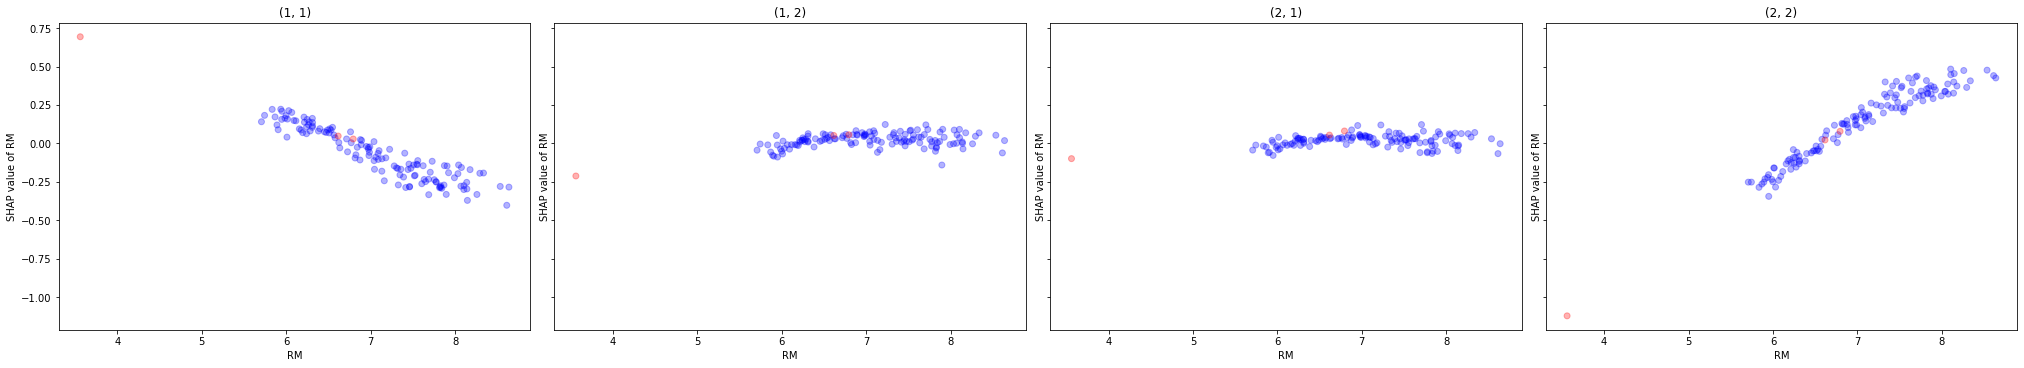

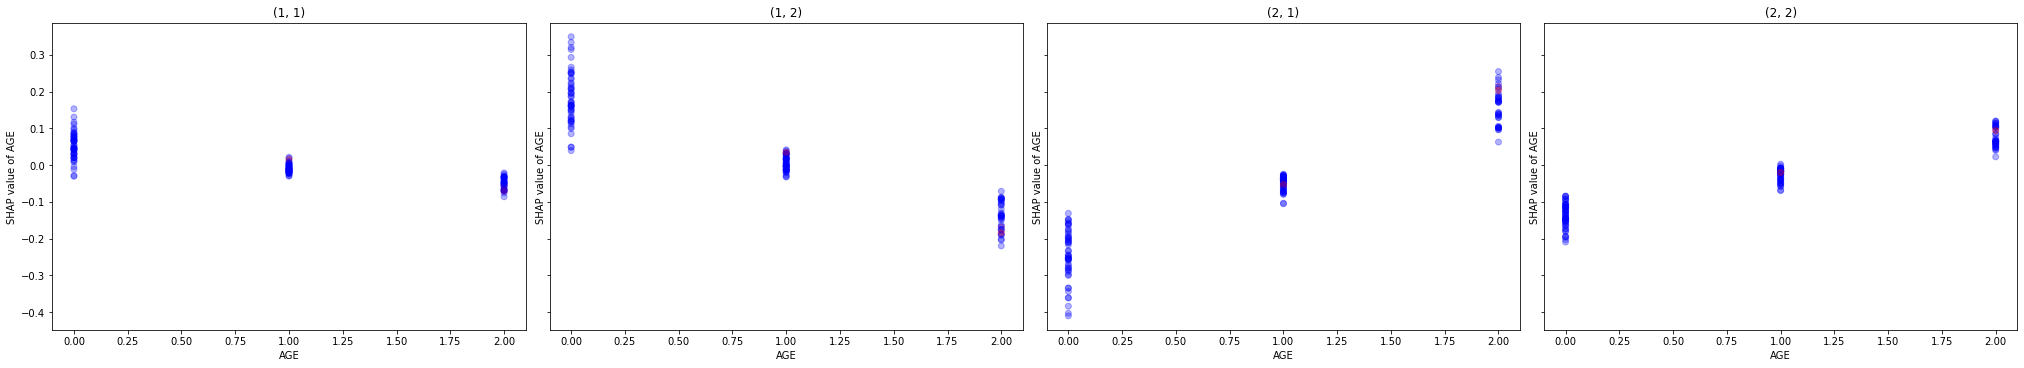

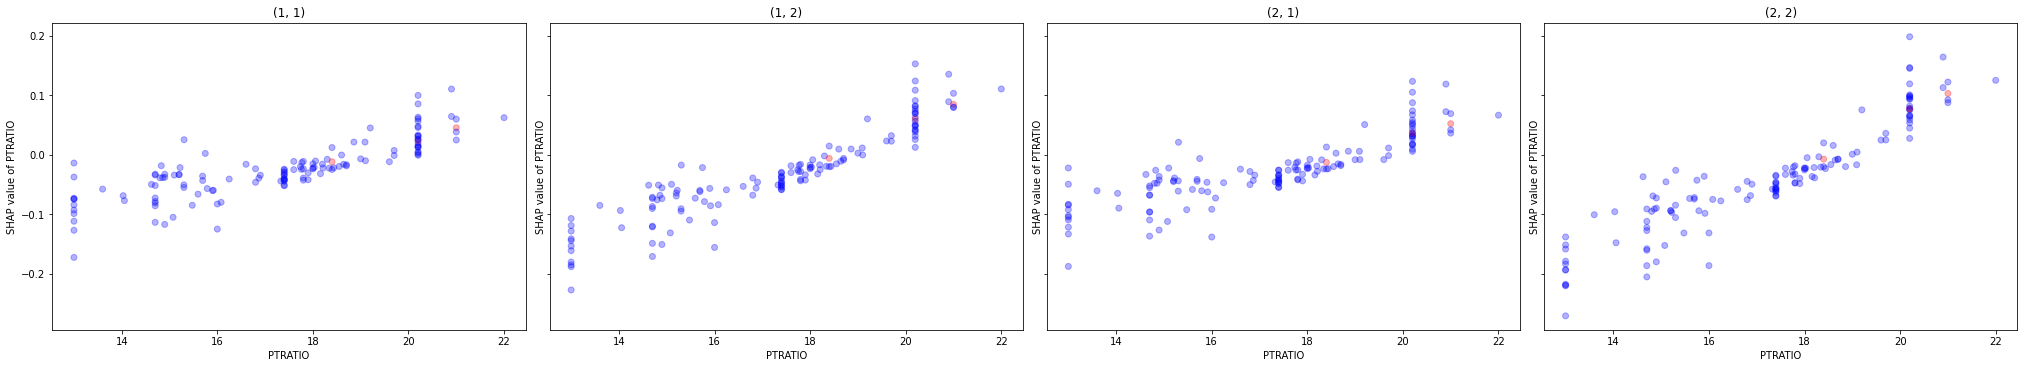

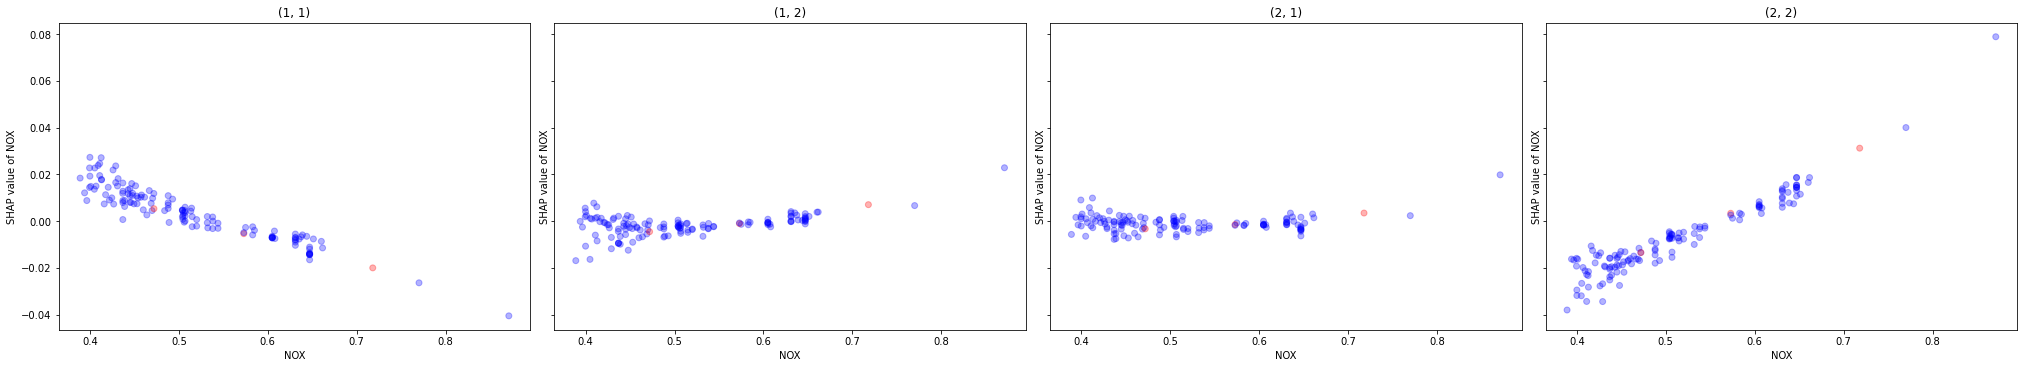

In [64]:
for feature in feature_order:
    clustering.plot_feature(feature, alpha=0.3)